##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/video/video_classification"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/video/video_classification.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/video/video_classification.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/video/video_classification.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>
</td>
</table>

# 使用 3D 卷积神经网络 (CNN) 进行视频分类

本教程演示了如何使用 [UCF101](https://www.crcv.ucf.edu/data/UCF101.php) 动作识别数据集训练一个用于视频分类的 3D 卷积神经网络。3D CNN 使用三维过滤器来执行卷积。内核能够在三个维度上滑动，而在 2D CNN 中，它可以在两个维度上滑动。此模型基于 D. Tran 等人在 [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3)（2017 年）中发表的工作。在本教程中，您将完成以下任务：

- 构建输入流水线
- 使用 Keras 函数式 API 构建具有残差连接的 3D 卷积神经网络模型
- 训练模型
- 评估和测试模型

## 安装

首先，安装和导入一些必要的库，包括：用于检查 ZIP 文件内容的 [remotezip](https://github.com/gtsystem/python-remotezip)，用于使用进度条的 [tqdm](https://github.com/tqdm/tqdm)，用于处理视频文件的 [OpenCV](https://opencv.org/)，用于执行更复杂张量运算的 [einops](https://github.com/arogozhnikov/einops/tree/master/docs)，以及用于在 Jupyter 笔记本中嵌入数据的 [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs)。

In [2]:
!pip install remotezip tqdm opencv-python einops

  Using cached remotezip-0.12.1-py3-none-any.whl


  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


In [3]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers


2023-11-07 18:08:39.970660: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 18:08:39.970710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 18:08:39.972243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 加载并预处理视频数据

下面的隐藏单元定义了从 UCF-101 数据集下载数据切片并将其加载到 `tf.data.Dataset` 中的函数。可以在[加载视频数据教程](../load_data/video.ipynb)中详细了解特定的预处理步骤，此教程将更详细地介绍此代码。

In [4]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [5]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10}, 
                        download_dir = download_dir)

train :


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:00<01:05,  4.57it/s]

  1%|          | 2/300 [00:00<00:45,  6.61it/s]

  1%|          | 3/300 [00:00<00:41,  7.23it/s]

  1%|▏         | 4/300 [00:00<00:39,  7.46it/s]

  2%|▏         | 5/300 [00:00<00:41,  7.18it/s]

  2%|▏         | 6/300 [00:00<00:44,  6.62it/s]

  2%|▏         | 7/300 [00:01<00:51,  5.73it/s]

  3%|▎         | 9/300 [00:01<00:40,  7.27it/s]

  4%|▎         | 11/300 [00:01<00:32,  8.95it/s]

  4%|▍         | 13/300 [00:01<00:29,  9.73it/s]

  5%|▌         | 15/300 [00:01<00:30,  9.39it/s]

  5%|▌         | 16/300 [00:01<00:31,  9.13it/s]

  6%|▌         | 18/300 [00:02<00:32,  8.74it/s]

  6%|▋         | 19/300 [00:02<00:37,  7.42it/s]

  7%|▋         | 20/300 [00:02<00:39,  7.15it/s]

  7%|▋         | 21/300 [00:02<00:36,  7.61it/s]

  8%|▊         | 23/300 [00:02<00:30,  9.08it/s]

  8%|▊         | 24/300 [00:02<00:31,  8.82it/s]

  8%|▊         | 25/300 [00:03<00:32,  8.50it/s]

  9%|▊         | 26/300 [00:03<00:35,  7.62it/s]

  9%|▉         | 28/300 [00:03<00:34,  7.81it/s]

 10%|▉         | 29/300 [00:03<00:37,  7.32it/s]

 10%|█         | 30/300 [00:03<00:39,  6.85it/s]

 10%|█         | 31/300 [00:03<00:37,  7.25it/s]

 11%|█         | 33/300 [00:04<00:32,  8.34it/s]

 11%|█▏        | 34/300 [00:04<00:30,  8.67it/s]

 12%|█▏        | 35/300 [00:04<00:30,  8.75it/s]

 12%|█▏        | 37/300 [00:04<00:25, 10.38it/s]

 13%|█▎        | 39/300 [00:04<00:26,  9.73it/s]

 13%|█▎        | 40/300 [00:04<00:29,  8.89it/s]

 14%|█▎        | 41/300 [00:05<00:29,  8.78it/s]

 14%|█▍        | 43/300 [00:05<00:25, 10.10it/s]

 15%|█▌        | 45/300 [00:05<00:22, 11.24it/s]

 16%|█▌        | 47/300 [00:05<00:29,  8.56it/s]

 16%|█▌        | 48/300 [00:05<00:30,  8.29it/s]

 17%|█▋        | 50/300 [00:05<00:26,  9.55it/s]

 17%|█▋        | 52/300 [00:06<00:24,  9.95it/s]

 18%|█▊        | 54/300 [00:06<00:29,  8.28it/s]

 19%|█▊        | 56/300 [00:06<00:26,  9.31it/s]

 19%|█▉        | 58/300 [00:06<00:28,  8.48it/s]

 20%|█▉        | 59/300 [00:07<00:27,  8.68it/s]

 20%|██        | 61/300 [00:07<00:26,  8.88it/s]

 21%|██        | 62/300 [00:07<00:28,  8.45it/s]

 21%|██        | 63/300 [00:07<00:29,  8.15it/s]

 21%|██▏       | 64/300 [00:07<00:31,  7.50it/s]

 22%|██▏       | 65/300 [00:07<00:31,  7.44it/s]

 22%|██▏       | 66/300 [00:07<00:31,  7.32it/s]

 23%|██▎       | 68/300 [00:08<00:25,  9.08it/s]

 23%|██▎       | 69/300 [00:08<00:25,  9.00it/s]

 24%|██▎       | 71/300 [00:08<00:25,  9.05it/s]

 24%|██▍       | 72/300 [00:08<00:29,  7.60it/s]

 24%|██▍       | 73/300 [00:08<00:30,  7.55it/s]

 25%|██▍       | 74/300 [00:08<00:32,  7.01it/s]

 25%|██▌       | 76/300 [00:09<00:25,  8.84it/s]

 26%|██▌       | 77/300 [00:09<00:27,  8.00it/s]

 26%|██▌       | 78/300 [00:09<00:28,  7.76it/s]

 26%|██▋       | 79/300 [00:09<00:29,  7.50it/s]

 27%|██▋       | 80/300 [00:09<00:31,  6.97it/s]

 27%|██▋       | 82/300 [00:09<00:24,  8.87it/s]

 28%|██▊       | 83/300 [00:10<00:26,  8.15it/s]

 28%|██▊       | 85/300 [00:10<00:23,  9.09it/s]

 29%|██▉       | 87/300 [00:10<00:23,  9.16it/s]

 30%|██▉       | 89/300 [00:10<00:25,  8.39it/s]

 30%|███       | 90/300 [00:10<00:26,  7.79it/s]

 30%|███       | 91/300 [00:10<00:25,  8.15it/s]

 31%|███       | 92/300 [00:11<00:26,  7.92it/s]

 31%|███▏      | 94/300 [00:11<00:23,  8.59it/s]

 32%|███▏      | 95/300 [00:11<00:26,  7.73it/s]

 32%|███▏      | 96/300 [00:11<00:25,  7.85it/s]

 33%|███▎      | 98/300 [00:11<00:22,  9.11it/s]

 33%|███▎      | 100/300 [00:11<00:20,  9.94it/s]

 34%|███▍      | 102/300 [00:12<00:19, 10.09it/s]

 35%|███▍      | 104/300 [00:12<00:22,  8.79it/s]

 35%|███▌      | 106/300 [00:12<00:21,  9.06it/s]

 36%|███▌      | 108/300 [00:12<00:20,  9.52it/s]

 37%|███▋      | 110/300 [00:12<00:18, 10.13it/s]

 37%|███▋      | 112/300 [00:13<00:20,  9.12it/s]

 38%|███▊      | 114/300 [00:13<00:19,  9.37it/s]

 39%|███▊      | 116/300 [00:13<00:19,  9.37it/s]

 39%|███▉      | 118/300 [00:13<00:17, 10.58it/s]

 40%|████      | 120/300 [00:14<00:18,  9.92it/s]

 41%|████      | 122/300 [00:14<00:16, 10.64it/s]

 41%|████▏     | 124/300 [00:14<00:20,  8.46it/s]

 42%|████▏     | 126/300 [00:14<00:19,  8.86it/s]

 43%|████▎     | 128/300 [00:14<00:17,  9.57it/s]

 43%|████▎     | 130/300 [00:15<00:16, 10.13it/s]

 44%|████▍     | 132/300 [00:15<00:17,  9.85it/s]

 45%|████▍     | 134/300 [00:15<00:15, 10.58it/s]

 45%|████▌     | 136/300 [00:15<00:16, 10.08it/s]

 46%|████▌     | 138/300 [00:15<00:14, 10.84it/s]

 47%|████▋     | 140/300 [00:16<00:16,  9.81it/s]

 47%|████▋     | 142/300 [00:16<00:14, 10.98it/s]

 48%|████▊     | 144/300 [00:16<00:14, 10.66it/s]

 49%|████▊     | 146/300 [00:16<00:13, 11.39it/s]

 49%|████▉     | 148/300 [00:16<00:12, 12.12it/s]

 50%|█████     | 150/300 [00:16<00:13, 10.80it/s]

 51%|█████     | 152/300 [00:17<00:14, 10.03it/s]

 51%|█████▏    | 154/300 [00:17<00:15,  9.41it/s]

 52%|█████▏    | 155/300 [00:17<00:15,  9.22it/s]

 52%|█████▏    | 156/300 [00:17<00:17,  8.14it/s]

 53%|█████▎    | 158/300 [00:17<00:16,  8.56it/s]

 53%|█████▎    | 159/300 [00:18<00:16,  8.79it/s]

 54%|█████▎    | 161/300 [00:18<00:16,  8.34it/s]

 54%|█████▍    | 162/300 [00:18<00:16,  8.23it/s]

 54%|█████▍    | 163/300 [00:18<00:16,  8.28it/s]

 55%|█████▍    | 164/300 [00:18<00:15,  8.55it/s]

 55%|█████▌    | 166/300 [00:18<00:13,  9.67it/s]

 56%|█████▌    | 167/300 [00:18<00:13,  9.52it/s]

 56%|█████▋    | 169/300 [00:19<00:13,  9.99it/s]

 57%|█████▋    | 170/300 [00:19<00:14,  9.08it/s]

 57%|█████▋    | 171/300 [00:19<00:14,  8.97it/s]

 58%|█████▊    | 173/300 [00:19<00:13,  9.31it/s]

 58%|█████▊    | 175/300 [00:19<00:11, 10.45it/s]

 59%|█████▉    | 177/300 [00:20<00:14,  8.47it/s]

 59%|█████▉    | 178/300 [00:20<00:14,  8.14it/s]

 60%|█████▉    | 179/300 [00:20<00:14,  8.37it/s]

 60%|██████    | 180/300 [00:20<00:19,  6.10it/s]

 60%|██████    | 181/300 [00:20<00:18,  6.47it/s]

 61%|██████    | 182/300 [00:20<00:17,  6.87it/s]

 61%|██████▏   | 184/300 [00:21<00:15,  7.45it/s]

 62%|██████▏   | 185/300 [00:21<00:14,  7.69it/s]

 62%|██████▏   | 187/300 [00:21<00:13,  8.10it/s]

 63%|██████▎   | 189/300 [00:21<00:13,  8.23it/s]

 63%|██████▎   | 190/300 [00:21<00:13,  8.16it/s]

 64%|██████▎   | 191/300 [00:21<00:12,  8.49it/s]

 64%|██████▍   | 193/300 [00:22<00:13,  7.94it/s]

 65%|██████▍   | 194/300 [00:22<00:14,  7.38it/s]

 65%|██████▌   | 196/300 [00:22<00:13,  7.44it/s]

 66%|██████▌   | 198/300 [00:22<00:11,  8.65it/s]

 67%|██████▋   | 200/300 [00:22<00:10,  9.77it/s]

 67%|██████▋   | 202/300 [00:23<00:10,  9.39it/s]

 68%|██████▊   | 204/300 [00:23<00:10,  9.54it/s]

 68%|██████▊   | 205/300 [00:23<00:10,  9.09it/s]

 69%|██████▉   | 207/300 [00:23<00:09, 10.23it/s]

 70%|██████▉   | 209/300 [00:23<00:11,  7.98it/s]

 70%|███████   | 211/300 [00:24<00:09,  8.98it/s]

 71%|███████   | 213/300 [00:24<00:10,  8.50it/s]

 71%|███████▏  | 214/300 [00:24<00:09,  8.73it/s]

 72%|███████▏  | 215/300 [00:24<00:10,  8.49it/s]

 72%|███████▏  | 216/300 [00:24<00:10,  8.00it/s]

 72%|███████▏  | 217/300 [00:24<00:10,  8.20it/s]

 73%|███████▎  | 218/300 [00:25<00:11,  7.37it/s]

 73%|███████▎  | 219/300 [00:25<00:10,  7.65it/s]

 74%|███████▎  | 221/300 [00:25<00:09,  8.74it/s]

 74%|███████▍  | 223/300 [00:25<00:08,  8.93it/s]

 75%|███████▍  | 224/300 [00:25<00:09,  8.40it/s]

 75%|███████▌  | 225/300 [00:25<00:08,  8.58it/s]

 75%|███████▌  | 226/300 [00:25<00:09,  8.16it/s]

 76%|███████▌  | 228/300 [00:26<00:07,  9.24it/s]

 77%|███████▋  | 230/300 [00:26<00:06, 10.55it/s]

 77%|███████▋  | 232/300 [00:26<00:06, 10.53it/s]

 78%|███████▊  | 234/300 [00:26<00:06,  9.82it/s]

 79%|███████▊  | 236/300 [00:26<00:05, 10.70it/s]

 79%|███████▉  | 238/300 [00:27<00:05, 10.80it/s]

 80%|████████  | 240/300 [00:27<00:05, 10.42it/s]

 81%|████████  | 242/300 [00:27<00:06,  9.35it/s]

 81%|████████  | 243/300 [00:27<00:06,  8.90it/s]

 81%|████████▏ | 244/300 [00:27<00:07,  7.81it/s]

 82%|████████▏ | 245/300 [00:28<00:07,  7.28it/s]

 82%|████████▏ | 246/300 [00:28<00:07,  7.15it/s]

 82%|████████▏ | 247/300 [00:28<00:07,  6.94it/s]

 83%|████████▎ | 249/300 [00:28<00:05,  8.96it/s]

 83%|████████▎ | 250/300 [00:28<00:06,  7.61it/s]

 84%|████████▍ | 252/300 [00:28<00:05,  8.76it/s]

 84%|████████▍ | 253/300 [00:28<00:05,  8.12it/s]

 85%|████████▌ | 255/300 [00:29<00:04,  9.76it/s]

 86%|████████▌ | 257/300 [00:29<00:04, 10.60it/s]

 86%|████████▋ | 259/300 [00:29<00:03, 10.84it/s]

 87%|████████▋ | 261/300 [00:29<00:03, 10.99it/s]

 88%|████████▊ | 263/300 [00:29<00:03,  9.48it/s]

 88%|████████▊ | 265/300 [00:30<00:03, 10.44it/s]

 89%|████████▉ | 267/300 [00:30<00:02, 11.51it/s]

 90%|████████▉ | 269/300 [00:30<00:02, 11.73it/s]

 90%|█████████ | 271/300 [00:30<00:02, 11.64it/s]

 91%|█████████ | 273/300 [00:30<00:02, 10.68it/s]

 92%|█████████▏| 275/300 [00:31<00:02,  9.85it/s]

 92%|█████████▏| 277/300 [00:31<00:02,  8.43it/s]

 93%|█████████▎| 279/300 [00:31<00:02,  8.84it/s]

 93%|█████████▎| 280/300 [00:31<00:02,  8.74it/s]

 94%|█████████▍| 282/300 [00:31<00:02,  8.30it/s]

 95%|█████████▍| 284/300 [00:32<00:01,  9.34it/s]

 95%|█████████▌| 285/300 [00:32<00:01,  8.14it/s]

 95%|█████████▌| 286/300 [00:32<00:01,  7.37it/s]

 96%|█████████▌| 287/300 [00:32<00:01,  7.15it/s]

 96%|█████████▌| 288/300 [00:32<00:01,  6.44it/s]

 96%|█████████▋| 289/300 [00:32<00:01,  6.27it/s]

 97%|█████████▋| 291/300 [00:33<00:01,  7.06it/s]

 98%|█████████▊| 293/300 [00:33<00:00,  8.88it/s]

 98%|█████████▊| 295/300 [00:33<00:00,  9.05it/s]

 99%|█████████▊| 296/300 [00:33<00:00,  8.34it/s]

 99%|█████████▉| 298/300 [00:33<00:00,  8.50it/s]

100%|█████████▉| 299/300 [00:34<00:00,  7.71it/s]

100%|██████████| 300/300 [00:34<00:00,  8.77it/s]

val :


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:11,  8.38it/s]

  4%|▍         | 4/100 [00:00<00:10,  9.26it/s]

  5%|▌         | 5/100 [00:00<00:11,  8.60it/s]

  6%|▌         | 6/100 [00:00<00:11,  8.19it/s]

  7%|▋         | 7/100 [00:00<00:11,  8.36it/s]

  8%|▊         | 8/100 [00:00<00:11,  8.35it/s]

  9%|▉         | 9/100 [00:01<00:12,  7.32it/s]

 11%|█         | 11/100 [00:01<00:11,  7.68it/s]

 13%|█▎        | 13/100 [00:01<00:09,  9.05it/s]

 14%|█▍        | 14/100 [00:01<00:10,  8.46it/s]

 15%|█▌        | 15/100 [00:01<00:10,  8.22it/s]

 17%|█▋        | 17/100 [00:01<00:08,  9.70it/s]

 18%|█▊        | 18/100 [00:02<00:08,  9.64it/s]

 20%|██        | 20/100 [00:02<00:07, 10.95it/s]

 22%|██▏       | 22/100 [00:02<00:08,  9.10it/s]

 23%|██▎       | 23/100 [00:02<00:09,  8.30it/s]

 25%|██▌       | 25/100 [00:02<00:08,  8.82it/s]

 26%|██▌       | 26/100 [00:03<00:09,  7.71it/s]

 27%|██▋       | 27/100 [00:03<00:09,  7.39it/s]

 28%|██▊       | 28/100 [00:03<00:10,  6.60it/s]

 30%|███       | 30/100 [00:03<00:09,  7.08it/s]

 31%|███       | 31/100 [00:03<00:09,  7.55it/s]

 33%|███▎      | 33/100 [00:04<00:08,  7.65it/s]

 34%|███▍      | 34/100 [00:04<00:08,  7.72it/s]

 35%|███▌      | 35/100 [00:04<00:08,  7.65it/s]

 36%|███▌      | 36/100 [00:04<00:08,  7.40it/s]

 38%|███▊      | 38/100 [00:04<00:07,  8.39it/s]

 39%|███▉      | 39/100 [00:04<00:07,  8.30it/s]

 40%|████      | 40/100 [00:04<00:07,  8.45it/s]

 42%|████▏     | 42/100 [00:05<00:07,  8.23it/s]

 43%|████▎     | 43/100 [00:05<00:07,  7.38it/s]

 44%|████▍     | 44/100 [00:05<00:07,  7.44it/s]

 45%|████▌     | 45/100 [00:05<00:08,  6.69it/s]

 47%|████▋     | 47/100 [00:05<00:06,  8.36it/s]

 49%|████▉     | 49/100 [00:05<00:05,  9.03it/s]

 50%|█████     | 50/100 [00:06<00:05,  8.58it/s]

 51%|█████     | 51/100 [00:06<00:05,  8.34it/s]

 53%|█████▎    | 53/100 [00:06<00:05,  8.40it/s]

 54%|█████▍    | 54/100 [00:06<00:05,  8.55it/s]

 56%|█████▌    | 56/100 [00:06<00:05,  8.76it/s]

 57%|█████▋    | 57/100 [00:06<00:05,  8.12it/s]

 58%|█████▊    | 58/100 [00:07<00:05,  7.76it/s]

 59%|█████▉    | 59/100 [00:07<00:05,  7.87it/s]

 61%|██████    | 61/100 [00:07<00:04,  8.22it/s]

 62%|██████▏   | 62/100 [00:07<00:04,  8.34it/s]

 63%|██████▎   | 63/100 [00:07<00:04,  7.94it/s]

 65%|██████▌   | 65/100 [00:07<00:04,  8.74it/s]

 66%|██████▌   | 66/100 [00:08<00:04,  7.74it/s]

 67%|██████▋   | 67/100 [00:08<00:04,  7.35it/s]

 68%|██████▊   | 68/100 [00:08<00:04,  6.59it/s]

 69%|██████▉   | 69/100 [00:08<00:04,  7.21it/s]

 71%|███████   | 71/100 [00:08<00:03,  7.77it/s]

 72%|███████▏  | 72/100 [00:08<00:03,  7.33it/s]

 73%|███████▎  | 73/100 [00:09<00:04,  6.28it/s]

 75%|███████▌  | 75/100 [00:09<00:03,  7.23it/s]

 76%|███████▌  | 76/100 [00:09<00:03,  7.72it/s]

 77%|███████▋  | 77/100 [00:09<00:02,  7.87it/s]

 79%|███████▉  | 79/100 [00:09<00:02,  9.43it/s]

 81%|████████  | 81/100 [00:09<00:02,  8.95it/s]

 82%|████████▏ | 82/100 [00:10<00:02,  7.39it/s]

 83%|████████▎ | 83/100 [00:10<00:02,  7.16it/s]

 85%|████████▌ | 85/100 [00:10<00:01,  7.80it/s]

 86%|████████▌ | 86/100 [00:10<00:01,  7.98it/s]

 87%|████████▋ | 87/100 [00:10<00:01,  8.20it/s]

 89%|████████▉ | 89/100 [00:11<00:01,  9.01it/s]

 91%|█████████ | 91/100 [00:11<00:00,  9.61it/s]

 92%|█████████▏| 92/100 [00:11<00:00,  9.45it/s]

 94%|█████████▍| 94/100 [00:11<00:00, 10.18it/s]

 96%|█████████▌| 96/100 [00:11<00:00, 10.57it/s]

 98%|█████████▊| 98/100 [00:11<00:00,  9.74it/s]

 99%|█████████▉| 99/100 [00:12<00:00,  8.49it/s]

100%|██████████| 100/100 [00:12<00:00,  8.04it/s]

100%|██████████| 100/100 [00:12<00:00,  8.18it/s]

test :


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:13,  7.40it/s]

  3%|▎         | 3/100 [00:00<00:10,  8.99it/s]

  5%|▌         | 5/100 [00:00<00:09, 10.22it/s]

  7%|▋         | 7/100 [00:00<00:08, 10.76it/s]

  9%|▉         | 9/100 [00:01<00:12,  7.28it/s]

 10%|█         | 10/100 [00:01<00:12,  7.21it/s]

 12%|█▏        | 12/100 [00:01<00:10,  8.52it/s]

 13%|█▎        | 13/100 [00:01<00:09,  8.74it/s]

 15%|█▌        | 15/100 [00:01<00:08, 10.25it/s]

 17%|█▋        | 17/100 [00:01<00:07, 10.53it/s]

 19%|█▉        | 19/100 [00:01<00:07, 11.51it/s]

 21%|██        | 21/100 [00:02<00:06, 12.03it/s]

 23%|██▎       | 23/100 [00:02<00:08,  9.26it/s]

 25%|██▌       | 25/100 [00:02<00:09,  7.89it/s]

 26%|██▌       | 26/100 [00:02<00:10,  7.26it/s]

 27%|██▋       | 27/100 [00:03<00:10,  7.28it/s]

 28%|██▊       | 28/100 [00:03<00:09,  7.54it/s]

 29%|██▉       | 29/100 [00:03<00:10,  6.54it/s]

 30%|███       | 30/100 [00:03<00:11,  6.26it/s]

 31%|███       | 31/100 [00:03<00:10,  6.48it/s]

 32%|███▏      | 32/100 [00:03<00:09,  7.13it/s]

 33%|███▎      | 33/100 [00:04<00:09,  6.89it/s]

 34%|███▍      | 34/100 [00:04<00:10,  6.19it/s]

 35%|███▌      | 35/100 [00:04<00:09,  6.57it/s]

 36%|███▌      | 36/100 [00:04<00:09,  6.45it/s]

 38%|███▊      | 38/100 [00:04<00:07,  8.67it/s]

 39%|███▉      | 39/100 [00:04<00:07,  7.93it/s]

 41%|████      | 41/100 [00:05<00:07,  8.15it/s]

 42%|████▏     | 42/100 [00:05<00:07,  7.76it/s]

 44%|████▍     | 44/100 [00:05<00:06,  9.33it/s]

 46%|████▌     | 46/100 [00:05<00:05,  9.61it/s]

 47%|████▋     | 47/100 [00:05<00:05,  9.09it/s]

 48%|████▊     | 48/100 [00:05<00:05,  8.69it/s]

 50%|█████     | 50/100 [00:06<00:06,  8.12it/s]

 51%|█████     | 51/100 [00:06<00:05,  8.25it/s]

 53%|█████▎    | 53/100 [00:06<00:05,  9.06it/s]

 55%|█████▌    | 55/100 [00:06<00:05,  8.85it/s]

 56%|█████▌    | 56/100 [00:06<00:04,  9.01it/s]

 57%|█████▋    | 57/100 [00:06<00:05,  7.49it/s]

 58%|█████▊    | 58/100 [00:07<00:05,  7.76it/s]

 59%|█████▉    | 59/100 [00:07<00:05,  7.71it/s]

 60%|██████    | 60/100 [00:07<00:05,  7.39it/s]

 61%|██████    | 61/100 [00:07<00:05,  7.73it/s]

 63%|██████▎   | 63/100 [00:07<00:03,  9.40it/s]

 65%|██████▌   | 65/100 [00:07<00:03, 10.43it/s]

 67%|██████▋   | 67/100 [00:08<00:03,  8.71it/s]

 68%|██████▊   | 68/100 [00:08<00:04,  7.43it/s]

 69%|██████▉   | 69/100 [00:08<00:03,  7.82it/s]

 71%|███████   | 71/100 [00:08<00:03,  7.47it/s]

 73%|███████▎  | 73/100 [00:08<00:03,  7.77it/s]

 75%|███████▌  | 75/100 [00:09<00:03,  8.23it/s]

 77%|███████▋  | 77/100 [00:09<00:02,  8.73it/s]

 79%|███████▉  | 79/100 [00:09<00:02,  8.69it/s]

 80%|████████  | 80/100 [00:09<00:02,  8.80it/s]

 81%|████████  | 81/100 [00:09<00:02,  8.99it/s]

 82%|████████▏ | 82/100 [00:09<00:02,  8.48it/s]

 83%|████████▎ | 83/100 [00:10<00:02,  8.05it/s]

 84%|████████▍ | 84/100 [00:10<00:02,  7.52it/s]

 86%|████████▌ | 86/100 [00:10<00:01,  9.32it/s]

 87%|████████▋ | 87/100 [00:10<00:01,  8.62it/s]

 89%|████████▉ | 89/100 [00:10<00:01, 10.18it/s]

 91%|█████████ | 91/100 [00:10<00:01,  8.61it/s]

 92%|█████████▏| 92/100 [00:11<00:01,  6.99it/s]

 94%|█████████▍| 94/100 [00:11<00:00,  8.56it/s]

 96%|█████████▌| 96/100 [00:11<00:00,  8.72it/s]

 97%|█████████▋| 97/100 [00:11<00:00,  8.14it/s]

 98%|█████████▊| 98/100 [00:11<00:00,  8.17it/s]

 99%|█████████▉| 99/100 [00:11<00:00,  7.71it/s]

100%|██████████| 100/100 [00:12<00:00,  8.30it/s]

创建训练集、验证集和测试集（`train_ds`、`val_ds` 和 `test_ds`）。

In [6]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training = True),
                                          output_signature = output_signature)

# Batch the data
train_ds = train_ds.batch(8)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)
val_ds = val_ds.batch(8)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], 10),
                                         output_signature = output_signature)

test_ds = test_ds.batch(8)

## 创建模型

以下 3D 卷积神经网络模型基于 D. Tran 等人的论文 [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3)（2017 年）。这篇论文比较了数个版本的 3D ResNet。与标准 ResNet 一样，它们并非对具有维度 `(height, width)` 的单个图像进行运算，而是对视频体积 `(time, height, width)` 进行运算。解决这一问题的最明显方式是将每个 2D 卷积 (`layers.Conv2D`) 替换为 3D 卷积 (`layers.Conv3D`)。

本教程使用具有[残差连接](https://arxiv.org/abs/1512.03385)的 (2 + 1)D 卷积。(2 + 1)D 卷积允许对空间和时间维度进行分解，进而创建两个单独的步骤。这种方式的一个优势在于，将卷积因式分解为空间和时间维度有助于节省参数。

对于每个输出位置，3D 卷积将体积的 3D 补丁中的所有向量组合在一起，以在输出体积中创建一个向量。

![3D 卷积](https://tensorflow.google.cn/images/tutorials/video/3DCNN.png)

此运算需要 `time * height * width * channels` 个输入并产生 `channels` 个输出（假设输入和输出通道的数量相同。这样，内核大小为 `(3 x 3 x 3)` 的 3D 卷积层需要一个具有 `27 * channels ** 2` 个条目的权重矩阵。根据参考论文的发现，更有效且高效的方式是对卷积进行因式分解。他们提出了一个 (2+1)D 卷积来分别处理空间和时间维度，而不是用单个 3D 卷积来处理时间和空间维度。下图显示了一个 (2 + 1)D 卷积因式分解后的空间和时间卷积。

![(2+1)D 卷积](https://tensorflow.google.cn/images/tutorials/video/2plus1CNN.png)

这种方式的主要优点是减少了参数数量。在 (2 + 1)D 卷积中，空间卷积接受形状为 `(1, width, height)` 的数据，而时间卷积接受形状为 `(time, 1, 1)` 的数据。例如，内核大小为 `(3 x 3 x 3)` 的 (2 + 1)D 卷积需要大小为 `(9 * channels**2) + (3 * channels**2)` 的权重矩阵，不到完整 3D 卷积的一半。本教程实现了 (2 + 1)D ResNet18，其中 ResNet 中的每个卷积都被替换为 (2+1)D 卷积。

In [7]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [8]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

ResNet 模型由一系列残差块组成。一个残差块有两个分支。主分支执行计算，但难以让梯度流过。残差分支绕过主计算，大部分只是将输入添加到主分支的输出中。梯度很容易流过此分支。因此，将存在从损失函数到任何残差块的主分支的简单路径。这有助于避免梯度消失的问题。

使用以下类创建残差块的主分支。与标准 ResNet 结构相比，它使用自定义的 `Conv2Plus1D` 层而不是 `layers.Conv2D`。

In [9]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

要将残差分支添加到主分支，它需要具有相同的大小。下面的 `Project` 层处理分支上通道数发生变化的情况。特别是，添加了一系列密集连接层，然后添加了归一化。 

In [10]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

使用 `add_residual_block` 在模型的各层之间引入跳跃连接。

In [11]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

必须调整视频大小才能执行数据的下采样。特别是，对视频帧进行下采样允许模型检查帧的特定部分，以检测可能特定于某个动作的模式。通过下采样，可以丢弃非必要信息。此外，调整视频大小将允许降维，从而加快模型的处理速度。

In [12]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

使用 [Keras 函数式 API](https://tensorflow.google.cn/guide/keras/functional) 构建残差网络。

In [13]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [14]:
frames, label = next(iter(train_ds))
model.build(frames)

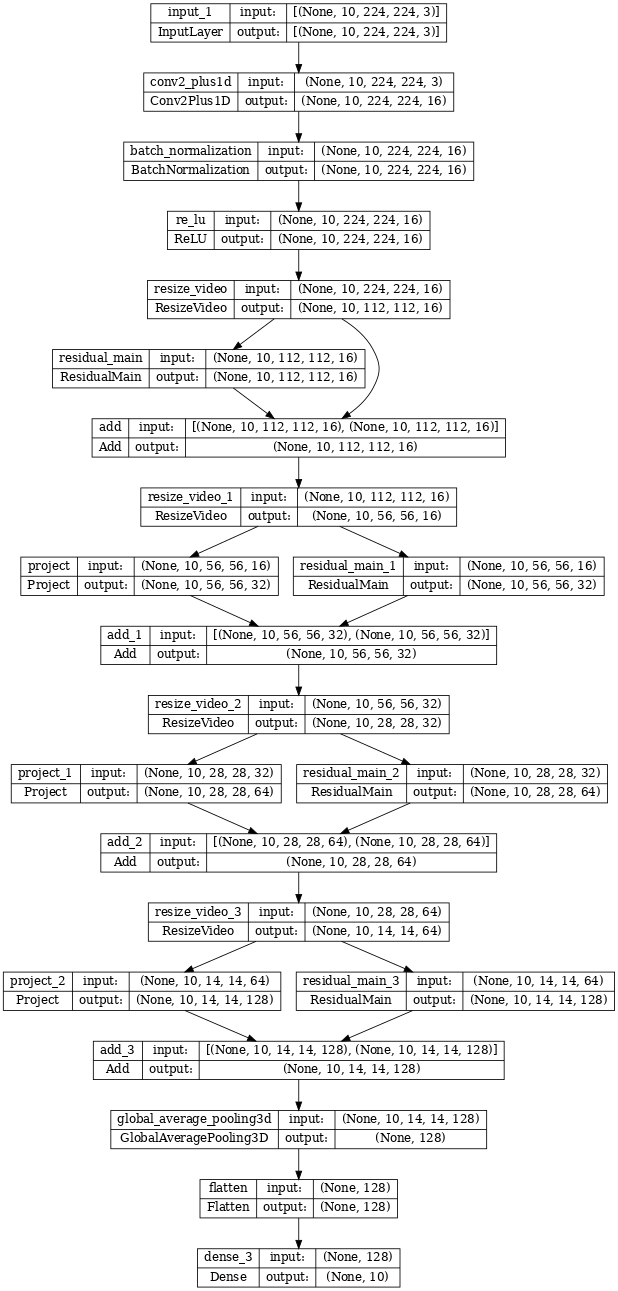

In [15]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

## 训练模型

对于本教程，选择 `tf.keras.optimizers.Adam` 优化器和 `tf.keras.losses.SparseCategoricalCrossentropy` 损失函数。使用 `metrics` 参数查看每个步骤中模型性能的准确率。

In [16]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

使用 Keras `Model.fit` 方法将模型训练 50 个周期。

注：此示例模型在较少的数据点（300 个训练样本和 100 个验证样本）上进行训练，以保持本教程具有合理的训练时间。此外，此示例模型可能需要超过一个小时来训练。

In [17]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds)

Epoch 1/50


I0000 00:00:1699380597.517956   67756 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      1/Unknown - 19s 19s/step - loss: 3.6965 - accuracy: 0.0000e+00

      2/Unknown - 19s 456ms/step - loss: 3.1960 - accuracy: 0.0000e+00

      3/Unknown - 21s 820ms/step - loss: 2.9339 - accuracy: 0.0417    

      4/Unknown - 22s 898ms/step - loss: 2.8138 - accuracy: 0.0938

      5/Unknown - 23s 963ms/step - loss: 2.7002 - accuracy: 0.1250

      6/Unknown - 24s 1s/step - loss: 2.6427 - accuracy: 0.1250   

      7/Unknown - 25s 1s/step - loss: 2.6936 - accuracy: 0.1071

      8/Unknown - 27s 1s/step - loss: 2.6592 - accuracy: 0.1562

      9/Unknown - 28s 1s/step - loss: 2.7005 - accuracy: 0.1389

     10/Unknown - 29s 1s/step - loss: 2.6832 - accuracy: 0.1500

     11/Unknown - 30s 1s/step - loss: 2.6750 - accuracy: 0.1364

     12/Unknown - 31s 1s/step - loss: 2.6706 - accuracy: 0.1354

     13/Unknown - 33s 1s/step - loss: 2.6544 - accuracy: 0.1250

     14/Unknown - 34s 1s/step - loss: 2.6393 - accuracy: 0.1250

     15/Unknown - 35s 1s/step - loss: 2.6568 - accuracy: 0.1167

     16/Unknown - 36s 1s/step - loss: 2.6262 - accuracy: 0.1250

     17/Unknown - 38s 1s/step - loss: 2.6230 - accuracy: 0.1176

     18/Unknown - 39s 1s/step - loss: 2.6009 - accuracy: 0.1181

     19/Unknown - 40s 1s/step - loss: 2.5962 - accuracy: 0.1118

     20/Unknown - 41s 1s/step - loss: 2.5881 - accuracy: 0.1187

     21/Unknown - 43s 1s/step - loss: 2.5722 - accuracy: 0.1190

     22/Unknown - 44s 1s/step - loss: 2.5522 - accuracy: 0.1364

     23/Unknown - 45s 1s/step - loss: 2.5302 - accuracy: 0.1304

     24/Unknown - 46s 1s/step - loss: 2.5255 - accuracy: 0.1302

     25/Unknown - 47s 1s/step - loss: 2.5168 - accuracy: 0.1350

     26/Unknown - 48s 1s/step - loss: 2.5152 - accuracy: 0.1346

     27/Unknown - 50s 1s/step - loss: 2.5238 - accuracy: 0.1296

     28/Unknown - 51s 1s/step - loss: 2.5199 - accuracy: 0.1250

     29/Unknown - 52s 1s/step - loss: 2.5150 - accuracy: 0.1207

     30/Unknown - 53s 1s/step - loss: 2.5185 - accuracy: 0.1167

     31/Unknown - 54s 1s/step - loss: 2.5100 - accuracy: 0.1169

     32/Unknown - 56s 1s/step - loss: 2.5013 - accuracy: 0.1133

     33/Unknown - 57s 1s/step - loss: 2.4901 - accuracy: 0.1174

     34/Unknown - 58s 1s/step - loss: 2.4930 - accuracy: 0.1176

     35/Unknown - 59s 1s/step - loss: 2.5000 - accuracy: 0.1143

     36/Unknown - 61s 1s/step - loss: 2.4871 - accuracy: 0.1181

     37/Unknown - 62s 1s/step - loss: 2.4838 - accuracy: 0.1182

     38/Unknown - 66s 1s/step - loss: 2.4852 - accuracy: 0.1167

38/38 [==============================] - 79s 2s/step - loss: 2.4852 - accuracy: 0.1167 - val_loss: 2.3667 - val_accuracy: 0.1200


Epoch 2/50


 1/38 [..............................] - ETA: 46s - loss: 2.2112 - accuracy: 0.1250

 2/38 [>.............................] - ETA: 40s - loss: 2.2629 - accuracy: 0.1250

 3/38 [=>............................] - ETA: 40s - loss: 2.2185 - accuracy: 0.1667

 4/38 [==>...........................] - ETA: 39s - loss: 2.2657 - accuracy: 0.1562

 5/38 [==>...........................] - ETA: 38s - loss: 2.2363 - accuracy: 0.1750

 6/38 [===>..........................] - ETA: 37s - loss: 2.3293 - accuracy: 0.1458

 7/38 [====>.........................] - ETA: 36s - loss: 2.3285 - accuracy: 0.1429

 8/38 [=====>........................] - ETA: 35s - loss: 2.2894 - accuracy: 0.1562

 9/38 [======>.......................] - ETA: 34s - loss: 2.3113 - accuracy: 0.1389

10/38 [======>.......................] - ETA: 33s - loss: 2.3254 - accuracy: 0.1375

11/38 [=======>......................] - ETA: 32s - loss: 2.3132 - accuracy: 0.1364

12/38 [========>.....................] - ETA: 30s - loss: 2.2995 - accuracy: 0.1354

13/38 [=========>....................] - ETA: 29s - loss: 2.3092 - accuracy: 0.1346

14/38 [==========>...................] - ETA: 28s - loss: 2.2874 - accuracy: 0.1429

15/38 [==========>...................] - ETA: 27s - loss: 2.2903 - accuracy: 0.1333

16/38 [===========>..................] - ETA: 26s - loss: 2.2841 - accuracy: 0.1328

17/38 [============>.................] - ETA: 25s - loss: 2.2863 - accuracy: 0.1324

18/38 [=============>................] - ETA: 23s - loss: 2.3015 - accuracy: 0.1250

19/38 [==============>...............] - ETA: 22s - loss: 2.2820 - accuracy: 0.1250

20/38 [==============>...............] - ETA: 21s - loss: 2.2733 - accuracy: 0.1312

21/38 [===============>..............] - ETA: 20s - loss: 2.2772 - accuracy: 0.1310

22/38 [================>.............] - ETA: 19s - loss: 2.2785 - accuracy: 0.1307

23/38 [=================>............] - ETA: 17s - loss: 2.2819 - accuracy: 0.1359

24/38 [=================>............] - ETA: 16s - loss: 2.2799 - accuracy: 0.1406

25/38 [==================>...........] - ETA: 15s - loss: 2.3034 - accuracy: 0.1350

26/38 [===================>..........] - ETA: 14s - loss: 2.2983 - accuracy: 0.1346

27/38 [====================>.........] - ETA: 13s - loss: 2.2991 - accuracy: 0.1389

28/38 [=====================>........] - ETA: 11s - loss: 2.2857 - accuracy: 0.1384

29/38 [=====================>........] - ETA: 10s - loss: 2.2893 - accuracy: 0.1379

30/38 [======================>.......] - ETA: 9s - loss: 2.2870 - accuracy: 0.1417 

31/38 [=======================>......] - ETA: 8s - loss: 2.2957 - accuracy: 0.1452

32/38 [========================>.....] - ETA: 7s - loss: 2.2883 - accuracy: 0.1523

33/38 [=========================>....] - ETA: 5s - loss: 2.2890 - accuracy: 0.1515

34/38 [=========================>....] - ETA: 4s - loss: 2.2831 - accuracy: 0.1544

35/38 [==========================>...] - ETA: 3s - loss: 2.2640 - accuracy: 0.1679

36/38 [===========================>..] - ETA: 2s - loss: 2.2756 - accuracy: 0.1632

37/38 [============================>.] - ETA: 1s - loss: 2.2802 - accuracy: 0.1622

38/38 [==============================] - ETA: 0s - loss: 2.2703 - accuracy: 0.1700

38/38 [==============================] - 57s 2s/step - loss: 2.2703 - accuracy: 0.1700 - val_loss: 2.2573 - val_accuracy: 0.1400


Epoch 3/50


 1/38 [..............................] - ETA: 46s - loss: 2.0821 - accuracy: 0.1250

 2/38 [>.............................] - ETA: 42s - loss: 2.1717 - accuracy: 0.1875

 3/38 [=>............................] - ETA: 40s - loss: 2.1043 - accuracy: 0.2500

 4/38 [==>...........................] - ETA: 39s - loss: 2.0171 - accuracy: 0.2500

 5/38 [==>...........................] - ETA: 38s - loss: 2.0949 - accuracy: 0.2000

 6/38 [===>..........................] - ETA: 38s - loss: 2.1174 - accuracy: 0.1875

 7/38 [====>.........................] - ETA: 37s - loss: 2.0758 - accuracy: 0.1964

 8/38 [=====>........................] - ETA: 36s - loss: 2.0900 - accuracy: 0.1875

 9/38 [======>.......................] - ETA: 35s - loss: 2.0997 - accuracy: 0.1944

10/38 [======>.......................] - ETA: 34s - loss: 2.1208 - accuracy: 0.1750

11/38 [=======>......................] - ETA: 33s - loss: 2.1229 - accuracy: 0.1705

12/38 [========>.....................] - ETA: 32s - loss: 2.1223 - accuracy: 0.1562

13/38 [=========>....................] - ETA: 30s - loss: 2.1258 - accuracy: 0.1538

14/38 [==========>...................] - ETA: 29s - loss: 2.1152 - accuracy: 0.1518

15/38 [==========>...................] - ETA: 28s - loss: 2.1141 - accuracy: 0.1667

16/38 [===========>..................] - ETA: 27s - loss: 2.1095 - accuracy: 0.1719

17/38 [============>.................] - ETA: 25s - loss: 2.1328 - accuracy: 0.1765

18/38 [=============>................] - ETA: 24s - loss: 2.1432 - accuracy: 0.1736

19/38 [==============>...............] - ETA: 23s - loss: 2.1405 - accuracy: 0.1776

20/38 [==============>...............] - ETA: 21s - loss: 2.1291 - accuracy: 0.1813

21/38 [===============>..............] - ETA: 20s - loss: 2.1500 - accuracy: 0.1786

22/38 [================>.............] - ETA: 19s - loss: 2.1572 - accuracy: 0.1818

23/38 [=================>............] - ETA: 18s - loss: 2.1578 - accuracy: 0.1739

24/38 [=================>............] - ETA: 17s - loss: 2.1628 - accuracy: 0.1719

25/38 [==================>...........] - ETA: 15s - loss: 2.1692 - accuracy: 0.1650

26/38 [===================>..........] - ETA: 14s - loss: 2.1665 - accuracy: 0.1635

27/38 [====================>.........] - ETA: 13s - loss: 2.1617 - accuracy: 0.1574

28/38 [=====================>........] - ETA: 12s - loss: 2.1642 - accuracy: 0.1562

29/38 [=====================>........] - ETA: 11s - loss: 2.1685 - accuracy: 0.1509

30/38 [======================>.......] - ETA: 9s - loss: 2.1593 - accuracy: 0.1583 

31/38 [=======================>......] - ETA: 8s - loss: 2.1613 - accuracy: 0.1613

32/38 [========================>.....] - ETA: 7s - loss: 2.1531 - accuracy: 0.1680

33/38 [=========================>....] - ETA: 6s - loss: 2.1542 - accuracy: 0.1705

34/38 [=========================>....] - ETA: 4s - loss: 2.1539 - accuracy: 0.1691

35/38 [==========================>...] - ETA: 3s - loss: 2.1539 - accuracy: 0.1679

36/38 [===========================>..] - ETA: 2s - loss: 2.1582 - accuracy: 0.1667

37/38 [============================>.] - ETA: 1s - loss: 2.1510 - accuracy: 0.1723

38/38 [==============================] - ETA: 0s - loss: 2.1488 - accuracy: 0.1700

38/38 [==============================] - 58s 2s/step - loss: 2.1488 - accuracy: 0.1700 - val_loss: 2.3543 - val_accuracy: 0.1600


Epoch 4/50


 1/38 [..............................] - ETA: 49s - loss: 1.9970 - accuracy: 0.0000e+00

 2/38 [>.............................] - ETA: 45s - loss: 2.0406 - accuracy: 0.0625    

 3/38 [=>............................] - ETA: 45s - loss: 2.1610 - accuracy: 0.0417

 4/38 [==>...........................] - ETA: 43s - loss: 2.0614 - accuracy: 0.0938

 5/38 [==>...........................] - ETA: 42s - loss: 2.1145 - accuracy: 0.1000

 6/38 [===>..........................] - ETA: 40s - loss: 2.1093 - accuracy: 0.0833

 7/38 [====>.........................] - ETA: 39s - loss: 2.1118 - accuracy: 0.1071

 8/38 [=====>........................] - ETA: 38s - loss: 2.0823 - accuracy: 0.1094

 9/38 [======>.......................] - ETA: 36s - loss: 2.0904 - accuracy: 0.0972

10/38 [======>.......................] - ETA: 35s - loss: 2.0858 - accuracy: 0.1125

11/38 [=======>......................] - ETA: 34s - loss: 2.0854 - accuracy: 0.1136

12/38 [========>.....................] - ETA: 32s - loss: 2.0963 - accuracy: 0.1146

13/38 [=========>....................] - ETA: 31s - loss: 2.0783 - accuracy: 0.1250

14/38 [==========>...................] - ETA: 29s - loss: 2.0907 - accuracy: 0.1161

15/38 [==========>...................] - ETA: 28s - loss: 2.0730 - accuracy: 0.1250

16/38 [===========>..................] - ETA: 27s - loss: 2.0733 - accuracy: 0.1250

17/38 [============>.................] - ETA: 25s - loss: 2.0545 - accuracy: 0.1324

18/38 [=============>................] - ETA: 24s - loss: 2.0513 - accuracy: 0.1389

19/38 [==============>...............] - ETA: 23s - loss: 2.0483 - accuracy: 0.1447

20/38 [==============>...............] - ETA: 22s - loss: 2.0707 - accuracy: 0.1437

21/38 [===============>..............] - ETA: 20s - loss: 2.0727 - accuracy: 0.1429

22/38 [================>.............] - ETA: 19s - loss: 2.0806 - accuracy: 0.1420

23/38 [=================>............] - ETA: 18s - loss: 2.0674 - accuracy: 0.1630

24/38 [=================>............] - ETA: 16s - loss: 2.0601 - accuracy: 0.1719

25/38 [==================>...........] - ETA: 15s - loss: 2.0455 - accuracy: 0.1850

26/38 [===================>..........] - ETA: 14s - loss: 2.0644 - accuracy: 0.1779

27/38 [====================>.........] - ETA: 13s - loss: 2.0515 - accuracy: 0.1852

28/38 [=====================>........] - ETA: 12s - loss: 2.0610 - accuracy: 0.1786

29/38 [=====================>........] - ETA: 10s - loss: 2.0637 - accuracy: 0.1767

30/38 [======================>.......] - ETA: 9s - loss: 2.0747 - accuracy: 0.1708 

31/38 [=======================>......] - ETA: 8s - loss: 2.0811 - accuracy: 0.1694

32/38 [========================>.....] - ETA: 7s - loss: 2.0594 - accuracy: 0.1758

33/38 [=========================>....] - ETA: 6s - loss: 2.0681 - accuracy: 0.1705

34/38 [=========================>....] - ETA: 4s - loss: 2.0599 - accuracy: 0.1801

35/38 [==========================>...] - ETA: 3s - loss: 2.0553 - accuracy: 0.1821

36/38 [===========================>..] - ETA: 2s - loss: 2.0478 - accuracy: 0.1806

37/38 [============================>.] - ETA: 1s - loss: 2.0427 - accuracy: 0.1757

38/38 [==============================] - ETA: 0s - loss: 2.0405 - accuracy: 0.1800

38/38 [==============================] - 58s 2s/step - loss: 2.0405 - accuracy: 0.1800 - val_loss: 2.4043 - val_accuracy: 0.2100


Epoch 5/50


 1/38 [..............................] - ETA: 46s - loss: 1.8657 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 39s - loss: 2.1058 - accuracy: 0.1875

 3/38 [=>............................] - ETA: 39s - loss: 1.9774 - accuracy: 0.2500

 4/38 [==>...........................] - ETA: 39s - loss: 2.0161 - accuracy: 0.2812

 5/38 [==>...........................] - ETA: 37s - loss: 1.9998 - accuracy: 0.2500

 6/38 [===>..........................] - ETA: 37s - loss: 1.9847 - accuracy: 0.2500

 7/38 [====>.........................] - ETA: 35s - loss: 1.9784 - accuracy: 0.2679

 8/38 [=====>........................] - ETA: 34s - loss: 1.9108 - accuracy: 0.3125

 9/38 [======>.......................] - ETA: 34s - loss: 1.9009 - accuracy: 0.3194

10/38 [======>.......................] - ETA: 33s - loss: 1.9620 - accuracy: 0.2875

11/38 [=======>......................] - ETA: 32s - loss: 1.9597 - accuracy: 0.2955

12/38 [========>.....................] - ETA: 31s - loss: 1.9858 - accuracy: 0.2708

13/38 [=========>....................] - ETA: 30s - loss: 1.9621 - accuracy: 0.2596

14/38 [==========>...................] - ETA: 28s - loss: 1.9852 - accuracy: 0.2500

15/38 [==========>...................] - ETA: 27s - loss: 1.9917 - accuracy: 0.2500

16/38 [===========>..................] - ETA: 26s - loss: 1.9803 - accuracy: 0.2500

17/38 [============>.................] - ETA: 25s - loss: 1.9719 - accuracy: 0.2426

18/38 [=============>................] - ETA: 24s - loss: 1.9392 - accuracy: 0.2708

19/38 [==============>...............] - ETA: 23s - loss: 1.9194 - accuracy: 0.2763

20/38 [==============>...............] - ETA: 21s - loss: 1.9220 - accuracy: 0.2750

21/38 [===============>..............] - ETA: 20s - loss: 1.9177 - accuracy: 0.2679

22/38 [================>.............] - ETA: 19s - loss: 1.9190 - accuracy: 0.2614

23/38 [=================>............] - ETA: 18s - loss: 1.9335 - accuracy: 0.2609

24/38 [=================>............] - ETA: 17s - loss: 1.9295 - accuracy: 0.2656

25/38 [==================>...........] - ETA: 16s - loss: 1.9217 - accuracy: 0.2650

26/38 [===================>..........] - ETA: 14s - loss: 1.9118 - accuracy: 0.2644

27/38 [====================>.........] - ETA: 13s - loss: 1.9368 - accuracy: 0.2685

28/38 [=====================>........] - ETA: 12s - loss: 1.9285 - accuracy: 0.2768

29/38 [=====================>........] - ETA: 11s - loss: 1.9324 - accuracy: 0.2802

30/38 [======================>.......] - ETA: 9s - loss: 1.9277 - accuracy: 0.2792 

31/38 [=======================>......] - ETA: 8s - loss: 1.9451 - accuracy: 0.2782

32/38 [========================>.....] - ETA: 7s - loss: 1.9385 - accuracy: 0.2852

33/38 [=========================>....] - ETA: 6s - loss: 1.9376 - accuracy: 0.2803

34/38 [=========================>....] - ETA: 4s - loss: 1.9240 - accuracy: 0.2868

35/38 [==========================>...] - ETA: 3s - loss: 1.9259 - accuracy: 0.2857

36/38 [===========================>..] - ETA: 2s - loss: 1.9145 - accuracy: 0.2917

37/38 [============================>.] - ETA: 1s - loss: 1.9228 - accuracy: 0.2872

38/38 [==============================] - ETA: 0s - loss: 1.9244 - accuracy: 0.2867

38/38 [==============================] - 57s 2s/step - loss: 1.9244 - accuracy: 0.2867 - val_loss: 2.0895 - val_accuracy: 0.2200


Epoch 6/50


 1/38 [..............................] - ETA: 48s - loss: 1.9317 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 47s - loss: 1.8103 - accuracy: 0.3125

 3/38 [=>............................] - ETA: 46s - loss: 1.8260 - accuracy: 0.2500

 4/38 [==>...........................] - ETA: 44s - loss: 1.6649 - accuracy: 0.3125

 5/38 [==>...........................] - ETA: 44s - loss: 1.7586 - accuracy: 0.2750

 6/38 [===>..........................] - ETA: 42s - loss: 1.7151 - accuracy: 0.3333

 7/38 [====>.........................] - ETA: 40s - loss: 1.7453 - accuracy: 0.3214

 8/38 [=====>........................] - ETA: 38s - loss: 1.8098 - accuracy: 0.3125

 9/38 [======>.......................] - ETA: 36s - loss: 1.7978 - accuracy: 0.3194

10/38 [======>.......................] - ETA: 35s - loss: 1.8420 - accuracy: 0.3125

11/38 [=======>......................] - ETA: 33s - loss: 1.8300 - accuracy: 0.3295

12/38 [========>.....................] - ETA: 32s - loss: 1.8260 - accuracy: 0.3229

13/38 [=========>....................] - ETA: 30s - loss: 1.8543 - accuracy: 0.3077

14/38 [==========>...................] - ETA: 29s - loss: 1.8622 - accuracy: 0.2946

15/38 [==========>...................] - ETA: 28s - loss: 1.8614 - accuracy: 0.3000

16/38 [===========>..................] - ETA: 27s - loss: 1.8581 - accuracy: 0.3047

17/38 [============>.................] - ETA: 25s - loss: 1.8405 - accuracy: 0.3088

18/38 [=============>................] - ETA: 24s - loss: 1.8430 - accuracy: 0.3125

19/38 [==============>...............] - ETA: 23s - loss: 1.8230 - accuracy: 0.3092

20/38 [==============>...............] - ETA: 22s - loss: 1.8301 - accuracy: 0.3063

21/38 [===============>..............] - ETA: 20s - loss: 1.8481 - accuracy: 0.2976

22/38 [================>.............] - ETA: 19s - loss: 1.8605 - accuracy: 0.3011

23/38 [=================>............] - ETA: 18s - loss: 1.8453 - accuracy: 0.3098

24/38 [=================>............] - ETA: 17s - loss: 1.8367 - accuracy: 0.3125

25/38 [==================>...........] - ETA: 16s - loss: 1.8452 - accuracy: 0.3100

26/38 [===================>..........] - ETA: 14s - loss: 1.8414 - accuracy: 0.3077

27/38 [====================>.........] - ETA: 13s - loss: 1.8512 - accuracy: 0.3009

28/38 [=====================>........] - ETA: 12s - loss: 1.8553 - accuracy: 0.3036

29/38 [=====================>........] - ETA: 11s - loss: 1.8593 - accuracy: 0.2974

30/38 [======================>.......] - ETA: 9s - loss: 1.8588 - accuracy: 0.2958 

31/38 [=======================>......] - ETA: 8s - loss: 1.8560 - accuracy: 0.2984

32/38 [========================>.....] - ETA: 7s - loss: 1.8536 - accuracy: 0.3008

33/38 [=========================>....] - ETA: 6s - loss: 1.8633 - accuracy: 0.3030

34/38 [=========================>....] - ETA: 4s - loss: 1.8606 - accuracy: 0.3051

35/38 [==========================>...] - ETA: 3s - loss: 1.8504 - accuracy: 0.3107

36/38 [===========================>..] - ETA: 2s - loss: 1.8445 - accuracy: 0.3160

37/38 [============================>.] - ETA: 1s - loss: 1.8410 - accuracy: 0.3176

38/38 [==============================] - ETA: 0s - loss: 1.8480 - accuracy: 0.3167

38/38 [==============================] - 57s 2s/step - loss: 1.8480 - accuracy: 0.3167 - val_loss: 1.9638 - val_accuracy: 0.2800


Epoch 7/50


 1/38 [..............................] - ETA: 51s - loss: 1.9740 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 41s - loss: 1.7450 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 43s - loss: 1.7631 - accuracy: 0.4583

 4/38 [==>...........................] - ETA: 41s - loss: 1.7480 - accuracy: 0.4375

 5/38 [==>...........................] - ETA: 40s - loss: 1.7598 - accuracy: 0.4250

 6/38 [===>..........................] - ETA: 38s - loss: 1.7668 - accuracy: 0.3958

 7/38 [====>.........................] - ETA: 37s - loss: 1.7463 - accuracy: 0.4107

 8/38 [=====>........................] - ETA: 36s - loss: 1.7377 - accuracy: 0.4062

 9/38 [======>.......................] - ETA: 34s - loss: 1.7578 - accuracy: 0.4028

10/38 [======>.......................] - ETA: 33s - loss: 1.7414 - accuracy: 0.4000

11/38 [=======>......................] - ETA: 32s - loss: 1.7707 - accuracy: 0.3864

12/38 [========>.....................] - ETA: 31s - loss: 1.7718 - accuracy: 0.3750

13/38 [=========>....................] - ETA: 30s - loss: 1.7259 - accuracy: 0.3942

14/38 [==========>...................] - ETA: 28s - loss: 1.7127 - accuracy: 0.3839

15/38 [==========>...................] - ETA: 27s - loss: 1.6880 - accuracy: 0.4167

16/38 [===========>..................] - ETA: 26s - loss: 1.6908 - accuracy: 0.4141

17/38 [============>.................] - ETA: 25s - loss: 1.7188 - accuracy: 0.3971

18/38 [=============>................] - ETA: 24s - loss: 1.7222 - accuracy: 0.4028

19/38 [==============>...............] - ETA: 22s - loss: 1.7335 - accuracy: 0.3882

20/38 [==============>...............] - ETA: 21s - loss: 1.7491 - accuracy: 0.3812

21/38 [===============>..............] - ETA: 20s - loss: 1.7399 - accuracy: 0.3810

22/38 [================>.............] - ETA: 19s - loss: 1.7242 - accuracy: 0.3864

23/38 [=================>............] - ETA: 18s - loss: 1.7048 - accuracy: 0.3967

24/38 [=================>............] - ETA: 16s - loss: 1.7034 - accuracy: 0.3906

25/38 [==================>...........] - ETA: 15s - loss: 1.7141 - accuracy: 0.3800

26/38 [===================>..........] - ETA: 14s - loss: 1.6908 - accuracy: 0.3894

27/38 [====================>.........] - ETA: 13s - loss: 1.6875 - accuracy: 0.3889

28/38 [=====================>........] - ETA: 12s - loss: 1.7021 - accuracy: 0.3884

29/38 [=====================>........] - ETA: 10s - loss: 1.7190 - accuracy: 0.3793

30/38 [======================>.......] - ETA: 9s - loss: 1.7263 - accuracy: 0.3708 

31/38 [=======================>......] - ETA: 8s - loss: 1.7355 - accuracy: 0.3669

32/38 [========================>.....] - ETA: 7s - loss: 1.7221 - accuracy: 0.3711

33/38 [=========================>....] - ETA: 6s - loss: 1.7181 - accuracy: 0.3788

34/38 [=========================>....] - ETA: 4s - loss: 1.7222 - accuracy: 0.3713

35/38 [==========================>...] - ETA: 3s - loss: 1.7531 - accuracy: 0.3607

36/38 [===========================>..] - ETA: 2s - loss: 1.7568 - accuracy: 0.3646

37/38 [============================>.] - ETA: 1s - loss: 1.7640 - accuracy: 0.3581

38/38 [==============================] - ETA: 0s - loss: 1.7556 - accuracy: 0.3633

38/38 [==============================] - 58s 2s/step - loss: 1.7556 - accuracy: 0.3633 - val_loss: 2.1203 - val_accuracy: 0.2400


Epoch 8/50


 1/38 [..............................] - ETA: 42s - loss: 2.1937 - accuracy: 0.1250

 2/38 [>.............................] - ETA: 41s - loss: 1.7839 - accuracy: 0.2500

 3/38 [=>............................] - ETA: 41s - loss: 1.7687 - accuracy: 0.2500

 4/38 [==>...........................] - ETA: 41s - loss: 1.6975 - accuracy: 0.3125

 5/38 [==>...........................] - ETA: 40s - loss: 1.6966 - accuracy: 0.2750

 6/38 [===>..........................] - ETA: 39s - loss: 1.6601 - accuracy: 0.3125

 7/38 [====>.........................] - ETA: 38s - loss: 1.6183 - accuracy: 0.3571

 8/38 [=====>........................] - ETA: 37s - loss: 1.6209 - accuracy: 0.3750

 9/38 [======>.......................] - ETA: 35s - loss: 1.6128 - accuracy: 0.3750

10/38 [======>.......................] - ETA: 34s - loss: 1.6478 - accuracy: 0.3875

11/38 [=======>......................] - ETA: 33s - loss: 1.6585 - accuracy: 0.3864

12/38 [========>.....................] - ETA: 31s - loss: 1.6185 - accuracy: 0.4062

13/38 [=========>....................] - ETA: 30s - loss: 1.6497 - accuracy: 0.4038

14/38 [==========>...................] - ETA: 29s - loss: 1.6790 - accuracy: 0.3839

15/38 [==========>...................] - ETA: 28s - loss: 1.6837 - accuracy: 0.3750

16/38 [===========>..................] - ETA: 27s - loss: 1.6961 - accuracy: 0.3594

17/38 [============>.................] - ETA: 25s - loss: 1.6895 - accuracy: 0.3676

18/38 [=============>................] - ETA: 24s - loss: 1.7012 - accuracy: 0.3681

19/38 [==============>...............] - ETA: 23s - loss: 1.7176 - accuracy: 0.3684

20/38 [==============>...............] - ETA: 22s - loss: 1.7067 - accuracy: 0.3688

21/38 [===============>..............] - ETA: 20s - loss: 1.6897 - accuracy: 0.3869

22/38 [================>.............] - ETA: 19s - loss: 1.7038 - accuracy: 0.3807

23/38 [=================>............] - ETA: 18s - loss: 1.6949 - accuracy: 0.3913

24/38 [=================>............] - ETA: 17s - loss: 1.7057 - accuracy: 0.3906

25/38 [==================>...........] - ETA: 15s - loss: 1.7020 - accuracy: 0.3900

26/38 [===================>..........] - ETA: 14s - loss: 1.7030 - accuracy: 0.3894

27/38 [====================>.........] - ETA: 13s - loss: 1.7052 - accuracy: 0.3935

28/38 [=====================>........] - ETA: 12s - loss: 1.7020 - accuracy: 0.3929

29/38 [=====================>........] - ETA: 11s - loss: 1.6956 - accuracy: 0.3879

30/38 [======================>.......] - ETA: 9s - loss: 1.6908 - accuracy: 0.3875 

31/38 [=======================>......] - ETA: 8s - loss: 1.6881 - accuracy: 0.3911

32/38 [========================>.....] - ETA: 7s - loss: 1.6753 - accuracy: 0.4023

33/38 [=========================>....] - ETA: 6s - loss: 1.6728 - accuracy: 0.4015

34/38 [=========================>....] - ETA: 4s - loss: 1.6827 - accuracy: 0.3971

35/38 [==========================>...] - ETA: 3s - loss: 1.6802 - accuracy: 0.3964

36/38 [===========================>..] - ETA: 2s - loss: 1.6819 - accuracy: 0.3993

37/38 [============================>.] - ETA: 1s - loss: 1.6900 - accuracy: 0.3953

38/38 [==============================] - ETA: 0s - loss: 1.6934 - accuracy: 0.3933

38/38 [==============================] - 57s 2s/step - loss: 1.6934 - accuracy: 0.3933 - val_loss: 2.0532 - val_accuracy: 0.3300


Epoch 9/50


 1/38 [..............................] - ETA: 42s - loss: 1.4094 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 40s - loss: 1.5304 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 42s - loss: 1.7424 - accuracy: 0.3750

 4/38 [==>...........................] - ETA: 43s - loss: 1.7155 - accuracy: 0.4375

 5/38 [==>...........................] - ETA: 41s - loss: 1.6682 - accuracy: 0.4500

 6/38 [===>..........................] - ETA: 40s - loss: 1.5834 - accuracy: 0.5000

 7/38 [====>.........................] - ETA: 38s - loss: 1.6435 - accuracy: 0.4821

 8/38 [=====>........................] - ETA: 37s - loss: 1.6031 - accuracy: 0.5000

 9/38 [======>.......................] - ETA: 36s - loss: 1.6350 - accuracy: 0.4583

10/38 [======>.......................] - ETA: 35s - loss: 1.6449 - accuracy: 0.4500

11/38 [=======>......................] - ETA: 33s - loss: 1.6197 - accuracy: 0.4432

12/38 [========>.....................] - ETA: 32s - loss: 1.5878 - accuracy: 0.4688

13/38 [=========>....................] - ETA: 30s - loss: 1.5565 - accuracy: 0.4712

14/38 [==========>...................] - ETA: 29s - loss: 1.5471 - accuracy: 0.4732

15/38 [==========>...................] - ETA: 28s - loss: 1.5866 - accuracy: 0.4583

16/38 [===========>..................] - ETA: 26s - loss: 1.5844 - accuracy: 0.4531

17/38 [============>.................] - ETA: 25s - loss: 1.5677 - accuracy: 0.4706

18/38 [=============>................] - ETA: 24s - loss: 1.5726 - accuracy: 0.4653

19/38 [==============>...............] - ETA: 23s - loss: 1.5631 - accuracy: 0.4671

20/38 [==============>...............] - ETA: 21s - loss: 1.5865 - accuracy: 0.4500

21/38 [===============>..............] - ETA: 20s - loss: 1.6529 - accuracy: 0.4345

22/38 [================>.............] - ETA: 19s - loss: 1.6477 - accuracy: 0.4261

23/38 [=================>............] - ETA: 18s - loss: 1.6504 - accuracy: 0.4185

24/38 [=================>............] - ETA: 16s - loss: 1.6229 - accuracy: 0.4323

25/38 [==================>...........] - ETA: 15s - loss: 1.6007 - accuracy: 0.4450

26/38 [===================>..........] - ETA: 14s - loss: 1.6205 - accuracy: 0.4471

27/38 [====================>.........] - ETA: 13s - loss: 1.6184 - accuracy: 0.4537

28/38 [=====================>........] - ETA: 12s - loss: 1.6236 - accuracy: 0.4464

29/38 [=====================>........] - ETA: 10s - loss: 1.6338 - accuracy: 0.4440

30/38 [======================>.......] - ETA: 9s - loss: 1.6213 - accuracy: 0.4542 

31/38 [=======================>......] - ETA: 8s - loss: 1.6023 - accuracy: 0.4637

32/38 [========================>.....] - ETA: 7s - loss: 1.5963 - accuracy: 0.4688

33/38 [=========================>....] - ETA: 6s - loss: 1.5951 - accuracy: 0.4735

34/38 [=========================>....] - ETA: 4s - loss: 1.5890 - accuracy: 0.4743

35/38 [==========================>...] - ETA: 3s - loss: 1.5907 - accuracy: 0.4714

36/38 [===========================>..] - ETA: 2s - loss: 1.5942 - accuracy: 0.4722

37/38 [============================>.] - ETA: 1s - loss: 1.6130 - accuracy: 0.4696

38/38 [==============================] - ETA: 0s - loss: 1.6195 - accuracy: 0.4633

38/38 [==============================] - 58s 2s/step - loss: 1.6195 - accuracy: 0.4633 - val_loss: 1.8839 - val_accuracy: 0.3600


Epoch 10/50


 1/38 [..............................] - ETA: 48s - loss: 1.4142 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 41s - loss: 1.6239 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 44s - loss: 1.5746 - accuracy: 0.5000

 4/38 [==>...........................] - ETA: 42s - loss: 1.6314 - accuracy: 0.4375

 5/38 [==>...........................] - ETA: 41s - loss: 1.5993 - accuracy: 0.4500

 6/38 [===>..........................] - ETA: 39s - loss: 1.5159 - accuracy: 0.5000

 7/38 [====>.........................] - ETA: 37s - loss: 1.4853 - accuracy: 0.5000

 8/38 [=====>........................] - ETA: 36s - loss: 1.4700 - accuracy: 0.5000

 9/38 [======>.......................] - ETA: 35s - loss: 1.4562 - accuracy: 0.5000

10/38 [======>.......................] - ETA: 34s - loss: 1.4818 - accuracy: 0.4875

11/38 [=======>......................] - ETA: 33s - loss: 1.4607 - accuracy: 0.4659

12/38 [========>.....................] - ETA: 31s - loss: 1.4969 - accuracy: 0.4375

13/38 [=========>....................] - ETA: 30s - loss: 1.5144 - accuracy: 0.4231

14/38 [==========>...................] - ETA: 29s - loss: 1.5239 - accuracy: 0.4107

15/38 [==========>...................] - ETA: 28s - loss: 1.5328 - accuracy: 0.4083

16/38 [===========>..................] - ETA: 26s - loss: 1.5431 - accuracy: 0.4062

17/38 [============>.................] - ETA: 25s - loss: 1.5590 - accuracy: 0.4044

18/38 [=============>................] - ETA: 24s - loss: 1.5612 - accuracy: 0.4097

19/38 [==============>...............] - ETA: 23s - loss: 1.5612 - accuracy: 0.4145

20/38 [==============>...............] - ETA: 22s - loss: 1.5773 - accuracy: 0.4125

21/38 [===============>..............] - ETA: 20s - loss: 1.6072 - accuracy: 0.4048

22/38 [================>.............] - ETA: 19s - loss: 1.5808 - accuracy: 0.4261

23/38 [=================>............] - ETA: 18s - loss: 1.5747 - accuracy: 0.4293

24/38 [=================>............] - ETA: 17s - loss: 1.5872 - accuracy: 0.4219

25/38 [==================>...........] - ETA: 15s - loss: 1.5649 - accuracy: 0.4300

26/38 [===================>..........] - ETA: 14s - loss: 1.5794 - accuracy: 0.4231

27/38 [====================>.........] - ETA: 13s - loss: 1.5955 - accuracy: 0.4120

28/38 [=====================>........] - ETA: 12s - loss: 1.6041 - accuracy: 0.4107

29/38 [=====================>........] - ETA: 10s - loss: 1.6117 - accuracy: 0.4009

30/38 [======================>.......] - ETA: 9s - loss: 1.5842 - accuracy: 0.4167 

31/38 [=======================>......] - ETA: 8s - loss: 1.6107 - accuracy: 0.4113

32/38 [========================>.....] - ETA: 7s - loss: 1.5969 - accuracy: 0.4180

33/38 [=========================>....] - ETA: 6s - loss: 1.5908 - accuracy: 0.4242

34/38 [=========================>....] - ETA: 4s - loss: 1.5833 - accuracy: 0.4265

35/38 [==========================>...] - ETA: 3s - loss: 1.5715 - accuracy: 0.4321

36/38 [===========================>..] - ETA: 2s - loss: 1.5681 - accuracy: 0.4375

37/38 [============================>.] - ETA: 1s - loss: 1.5746 - accuracy: 0.4358

38/38 [==============================] - ETA: 0s - loss: 1.5717 - accuracy: 0.4400

38/38 [==============================] - 58s 2s/step - loss: 1.5717 - accuracy: 0.4400 - val_loss: 1.9027 - val_accuracy: 0.2900


Epoch 11/50


 1/38 [..............................] - ETA: 47s - loss: 1.4802 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 44s - loss: 1.5340 - accuracy: 0.3750

 3/38 [=>............................] - ETA: 43s - loss: 1.5327 - accuracy: 0.3333

 4/38 [==>...........................] - ETA: 40s - loss: 1.4991 - accuracy: 0.3750

 5/38 [==>...........................] - ETA: 37s - loss: 1.4639 - accuracy: 0.4250

 6/38 [===>..........................] - ETA: 36s - loss: 1.4813 - accuracy: 0.4583

 7/38 [====>.........................] - ETA: 35s - loss: 1.5102 - accuracy: 0.4464

 8/38 [=====>........................] - ETA: 34s - loss: 1.4998 - accuracy: 0.4375

 9/38 [======>.......................] - ETA: 33s - loss: 1.5838 - accuracy: 0.4028

10/38 [======>.......................] - ETA: 32s - loss: 1.5916 - accuracy: 0.4000

11/38 [=======>......................] - ETA: 31s - loss: 1.5540 - accuracy: 0.4091

12/38 [========>.....................] - ETA: 30s - loss: 1.5866 - accuracy: 0.4167

13/38 [=========>....................] - ETA: 30s - loss: 1.5416 - accuracy: 0.4231

14/38 [==========>...................] - ETA: 28s - loss: 1.5158 - accuracy: 0.4464

15/38 [==========>...................] - ETA: 27s - loss: 1.5524 - accuracy: 0.4417

16/38 [===========>..................] - ETA: 26s - loss: 1.5328 - accuracy: 0.4609

17/38 [============>.................] - ETA: 25s - loss: 1.5458 - accuracy: 0.4632

18/38 [=============>................] - ETA: 24s - loss: 1.5175 - accuracy: 0.4722

19/38 [==============>...............] - ETA: 23s - loss: 1.5367 - accuracy: 0.4671

20/38 [==============>...............] - ETA: 21s - loss: 1.5451 - accuracy: 0.4688

21/38 [===============>..............] - ETA: 20s - loss: 1.5342 - accuracy: 0.4702

22/38 [================>.............] - ETA: 19s - loss: 1.5376 - accuracy: 0.4773

23/38 [=================>............] - ETA: 18s - loss: 1.5416 - accuracy: 0.4728

24/38 [=================>............] - ETA: 16s - loss: 1.5399 - accuracy: 0.4792

25/38 [==================>...........] - ETA: 15s - loss: 1.5230 - accuracy: 0.4800

26/38 [===================>..........] - ETA: 14s - loss: 1.5080 - accuracy: 0.4856

27/38 [====================>.........] - ETA: 13s - loss: 1.5126 - accuracy: 0.4815

28/38 [=====================>........] - ETA: 12s - loss: 1.5453 - accuracy: 0.4732

29/38 [=====================>........] - ETA: 10s - loss: 1.5404 - accuracy: 0.4655

30/38 [======================>.......] - ETA: 9s - loss: 1.5400 - accuracy: 0.4625 

31/38 [=======================>......] - ETA: 8s - loss: 1.5396 - accuracy: 0.4597

32/38 [========================>.....] - ETA: 7s - loss: 1.5336 - accuracy: 0.4570

33/38 [=========================>....] - ETA: 6s - loss: 1.5455 - accuracy: 0.4545

34/38 [=========================>....] - ETA: 4s - loss: 1.5457 - accuracy: 0.4485

35/38 [==========================>...] - ETA: 3s - loss: 1.5470 - accuracy: 0.4464

36/38 [===========================>..] - ETA: 2s - loss: 1.5469 - accuracy: 0.4410

37/38 [============================>.] - ETA: 1s - loss: 1.5347 - accuracy: 0.4493

38/38 [==============================] - ETA: 0s - loss: 1.5300 - accuracy: 0.4500

38/38 [==============================] - 58s 2s/step - loss: 1.5300 - accuracy: 0.4500 - val_loss: 1.7193 - val_accuracy: 0.3800


Epoch 12/50


 1/38 [..............................] - ETA: 43s - loss: 1.3916 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 42s - loss: 1.5616 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 43s - loss: 1.5988 - accuracy: 0.4167

 4/38 [==>...........................] - ETA: 42s - loss: 1.4802 - accuracy: 0.5000

 5/38 [==>...........................] - ETA: 41s - loss: 1.3473 - accuracy: 0.5500

 6/38 [===>..........................] - ETA: 40s - loss: 1.5210 - accuracy: 0.4583

 7/38 [====>.........................] - ETA: 38s - loss: 1.5440 - accuracy: 0.4286

 8/38 [=====>........................] - ETA: 37s - loss: 1.4466 - accuracy: 0.4844

 9/38 [======>.......................] - ETA: 35s - loss: 1.4552 - accuracy: 0.4861

10/38 [======>.......................] - ETA: 34s - loss: 1.4717 - accuracy: 0.4625

11/38 [=======>......................] - ETA: 33s - loss: 1.5032 - accuracy: 0.4432

12/38 [========>.....................] - ETA: 31s - loss: 1.5238 - accuracy: 0.4479

13/38 [=========>....................] - ETA: 30s - loss: 1.5139 - accuracy: 0.4615

14/38 [==========>...................] - ETA: 29s - loss: 1.5179 - accuracy: 0.4464

15/38 [==========>...................] - ETA: 27s - loss: 1.5307 - accuracy: 0.4583

16/38 [===========>..................] - ETA: 26s - loss: 1.5365 - accuracy: 0.4453

17/38 [============>.................] - ETA: 25s - loss: 1.4912 - accuracy: 0.4706

18/38 [=============>................] - ETA: 24s - loss: 1.4837 - accuracy: 0.4653

19/38 [==============>...............] - ETA: 22s - loss: 1.4766 - accuracy: 0.4539

20/38 [==============>...............] - ETA: 21s - loss: 1.5025 - accuracy: 0.4500

21/38 [===============>..............] - ETA: 20s - loss: 1.5002 - accuracy: 0.4345

22/38 [================>.............] - ETA: 19s - loss: 1.5347 - accuracy: 0.4205

23/38 [=================>............] - ETA: 18s - loss: 1.5175 - accuracy: 0.4239

24/38 [=================>............] - ETA: 17s - loss: 1.4993 - accuracy: 0.4219

25/38 [==================>...........] - ETA: 15s - loss: 1.5040 - accuracy: 0.4250

26/38 [===================>..........] - ETA: 14s - loss: 1.5088 - accuracy: 0.4183

27/38 [====================>.........] - ETA: 13s - loss: 1.5235 - accuracy: 0.4074

28/38 [=====================>........] - ETA: 12s - loss: 1.5437 - accuracy: 0.4062

29/38 [=====================>........] - ETA: 10s - loss: 1.5649 - accuracy: 0.3966

30/38 [======================>.......] - ETA: 9s - loss: 1.5535 - accuracy: 0.4000 

31/38 [=======================>......] - ETA: 8s - loss: 1.5504 - accuracy: 0.4032

32/38 [========================>.....] - ETA: 7s - loss: 1.5464 - accuracy: 0.4023

33/38 [=========================>....] - ETA: 6s - loss: 1.5366 - accuracy: 0.4129

34/38 [=========================>....] - ETA: 4s - loss: 1.5226 - accuracy: 0.4265

35/38 [==========================>...] - ETA: 3s - loss: 1.5302 - accuracy: 0.4357

36/38 [===========================>..] - ETA: 2s - loss: 1.5366 - accuracy: 0.4271

37/38 [============================>.] - ETA: 1s - loss: 1.5302 - accuracy: 0.4291

38/38 [==============================] - ETA: 0s - loss: 1.5294 - accuracy: 0.4333

38/38 [==============================] - 57s 2s/step - loss: 1.5294 - accuracy: 0.4333 - val_loss: 1.4846 - val_accuracy: 0.5000


Epoch 13/50


 1/38 [..............................] - ETA: 46s - loss: 1.4325 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 44s - loss: 1.4620 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 43s - loss: 1.4322 - accuracy: 0.5000

 4/38 [==>...........................] - ETA: 43s - loss: 1.2853 - accuracy: 0.5938

 5/38 [==>...........................] - ETA: 40s - loss: 1.3504 - accuracy: 0.5500

 6/38 [===>..........................] - ETA: 38s - loss: 1.3625 - accuracy: 0.5208

 7/38 [====>.........................] - ETA: 37s - loss: 1.3119 - accuracy: 0.5536

 8/38 [=====>........................] - ETA: 36s - loss: 1.2799 - accuracy: 0.5781

 9/38 [======>.......................] - ETA: 35s - loss: 1.2756 - accuracy: 0.5694

10/38 [======>.......................] - ETA: 34s - loss: 1.3102 - accuracy: 0.5375

11/38 [=======>......................] - ETA: 33s - loss: 1.3047 - accuracy: 0.5455

12/38 [========>.....................] - ETA: 31s - loss: 1.3014 - accuracy: 0.5521

13/38 [=========>....................] - ETA: 30s - loss: 1.3303 - accuracy: 0.5481

14/38 [==========>...................] - ETA: 29s - loss: 1.3598 - accuracy: 0.5268

15/38 [==========>...................] - ETA: 28s - loss: 1.3483 - accuracy: 0.5250

16/38 [===========>..................] - ETA: 26s - loss: 1.3233 - accuracy: 0.5469

17/38 [============>.................] - ETA: 25s - loss: 1.3388 - accuracy: 0.5441

18/38 [=============>................] - ETA: 24s - loss: 1.3379 - accuracy: 0.5417

19/38 [==============>...............] - ETA: 23s - loss: 1.3520 - accuracy: 0.5395

20/38 [==============>...............] - ETA: 22s - loss: 1.3486 - accuracy: 0.5437

21/38 [===============>..............] - ETA: 20s - loss: 1.3897 - accuracy: 0.5298

22/38 [================>.............] - ETA: 19s - loss: 1.3795 - accuracy: 0.5284

23/38 [=================>............] - ETA: 18s - loss: 1.4009 - accuracy: 0.5109

24/38 [=================>............] - ETA: 17s - loss: 1.4108 - accuracy: 0.5000

25/38 [==================>...........] - ETA: 15s - loss: 1.4035 - accuracy: 0.5050

26/38 [===================>..........] - ETA: 14s - loss: 1.4085 - accuracy: 0.5096

27/38 [====================>.........] - ETA: 13s - loss: 1.4058 - accuracy: 0.5046

28/38 [=====================>........] - ETA: 12s - loss: 1.3927 - accuracy: 0.5045

29/38 [=====================>........] - ETA: 10s - loss: 1.4044 - accuracy: 0.5043

30/38 [======================>.......] - ETA: 9s - loss: 1.3975 - accuracy: 0.5083 

31/38 [=======================>......] - ETA: 8s - loss: 1.3991 - accuracy: 0.5161

32/38 [========================>.....] - ETA: 7s - loss: 1.4217 - accuracy: 0.5078

33/38 [=========================>....] - ETA: 6s - loss: 1.4120 - accuracy: 0.5076

34/38 [=========================>....] - ETA: 4s - loss: 1.4168 - accuracy: 0.5037

35/38 [==========================>...] - ETA: 3s - loss: 1.4371 - accuracy: 0.5000

36/38 [===========================>..] - ETA: 2s - loss: 1.4451 - accuracy: 0.4965

37/38 [============================>.] - ETA: 1s - loss: 1.4388 - accuracy: 0.5000

38/38 [==============================] - ETA: 0s - loss: 1.4340 - accuracy: 0.5033

38/38 [==============================] - 58s 2s/step - loss: 1.4340 - accuracy: 0.5033 - val_loss: 1.4433 - val_accuracy: 0.4900


Epoch 14/50


 1/38 [..............................] - ETA: 49s - loss: 1.7911 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 45s - loss: 1.6584 - accuracy: 0.3750

 3/38 [=>............................] - ETA: 40s - loss: 1.5113 - accuracy: 0.3750

 4/38 [==>...........................] - ETA: 38s - loss: 1.5511 - accuracy: 0.3750

 5/38 [==>...........................] - ETA: 35s - loss: 1.5525 - accuracy: 0.3750

 6/38 [===>..........................] - ETA: 36s - loss: 1.4271 - accuracy: 0.4375

 7/38 [====>.........................] - ETA: 35s - loss: 1.4522 - accuracy: 0.4286

 8/38 [=====>........................] - ETA: 35s - loss: 1.4690 - accuracy: 0.4219

 9/38 [======>.......................] - ETA: 33s - loss: 1.4325 - accuracy: 0.4306

10/38 [======>.......................] - ETA: 33s - loss: 1.4249 - accuracy: 0.4375

11/38 [=======>......................] - ETA: 31s - loss: 1.4955 - accuracy: 0.4318

12/38 [========>.....................] - ETA: 31s - loss: 1.5103 - accuracy: 0.4375

13/38 [=========>....................] - ETA: 29s - loss: 1.4842 - accuracy: 0.4615

14/38 [==========>...................] - ETA: 28s - loss: 1.4525 - accuracy: 0.4821

15/38 [==========>...................] - ETA: 27s - loss: 1.4534 - accuracy: 0.4750

16/38 [===========>..................] - ETA: 26s - loss: 1.4199 - accuracy: 0.4922

17/38 [============>.................] - ETA: 25s - loss: 1.4126 - accuracy: 0.5000

18/38 [=============>................] - ETA: 24s - loss: 1.4161 - accuracy: 0.5000

19/38 [==============>...............] - ETA: 22s - loss: 1.3975 - accuracy: 0.5000

20/38 [==============>...............] - ETA: 21s - loss: 1.4309 - accuracy: 0.4938

21/38 [===============>..............] - ETA: 20s - loss: 1.4333 - accuracy: 0.4821

22/38 [================>.............] - ETA: 19s - loss: 1.4060 - accuracy: 0.4943

23/38 [=================>............] - ETA: 18s - loss: 1.4094 - accuracy: 0.4783

24/38 [=================>............] - ETA: 16s - loss: 1.4091 - accuracy: 0.4844

25/38 [==================>...........] - ETA: 15s - loss: 1.4120 - accuracy: 0.4850

26/38 [===================>..........] - ETA: 14s - loss: 1.4138 - accuracy: 0.4856

27/38 [====================>.........] - ETA: 13s - loss: 1.4106 - accuracy: 0.4861

28/38 [=====================>........] - ETA: 12s - loss: 1.3945 - accuracy: 0.4911

29/38 [=====================>........] - ETA: 10s - loss: 1.4288 - accuracy: 0.4784

30/38 [======================>.......] - ETA: 9s - loss: 1.4256 - accuracy: 0.4833 

31/38 [=======================>......] - ETA: 8s - loss: 1.4423 - accuracy: 0.4758

32/38 [========================>.....] - ETA: 7s - loss: 1.4521 - accuracy: 0.4766

33/38 [=========================>....] - ETA: 5s - loss: 1.4581 - accuracy: 0.4697

34/38 [=========================>....] - ETA: 4s - loss: 1.4825 - accuracy: 0.4632

35/38 [==========================>...] - ETA: 3s - loss: 1.4834 - accuracy: 0.4571

36/38 [===========================>..] - ETA: 2s - loss: 1.4718 - accuracy: 0.4618

37/38 [============================>.] - ETA: 1s - loss: 1.4568 - accuracy: 0.4730

38/38 [==============================] - ETA: 0s - loss: 1.4611 - accuracy: 0.4667

38/38 [==============================] - 57s 2s/step - loss: 1.4611 - accuracy: 0.4667 - val_loss: 1.6779 - val_accuracy: 0.3900


Epoch 15/50


 1/38 [..............................] - ETA: 47s - loss: 1.2709 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 45s - loss: 1.5566 - accuracy: 0.3750

 3/38 [=>............................] - ETA: 42s - loss: 1.3816 - accuracy: 0.4583

 4/38 [==>...........................] - ETA: 40s - loss: 1.5122 - accuracy: 0.4375

 5/38 [==>...........................] - ETA: 39s - loss: 1.4100 - accuracy: 0.4750

 6/38 [===>..........................] - ETA: 38s - loss: 1.3955 - accuracy: 0.4792

 7/38 [====>.........................] - ETA: 37s - loss: 1.3556 - accuracy: 0.4821

 8/38 [=====>........................] - ETA: 35s - loss: 1.3024 - accuracy: 0.5312

 9/38 [======>.......................] - ETA: 34s - loss: 1.3242 - accuracy: 0.5139

10/38 [======>.......................] - ETA: 33s - loss: 1.3054 - accuracy: 0.5250

11/38 [=======>......................] - ETA: 32s - loss: 1.3251 - accuracy: 0.5114

12/38 [========>.....................] - ETA: 30s - loss: 1.3350 - accuracy: 0.5104

13/38 [=========>....................] - ETA: 29s - loss: 1.3185 - accuracy: 0.4904

14/38 [==========>...................] - ETA: 28s - loss: 1.3188 - accuracy: 0.4911

15/38 [==========>...................] - ETA: 27s - loss: 1.3088 - accuracy: 0.4917

16/38 [===========>..................] - ETA: 26s - loss: 1.3261 - accuracy: 0.4844

17/38 [============>.................] - ETA: 25s - loss: 1.3300 - accuracy: 0.4926

18/38 [=============>................] - ETA: 24s - loss: 1.3288 - accuracy: 0.4931

19/38 [==============>...............] - ETA: 22s - loss: 1.3710 - accuracy: 0.4934

20/38 [==============>...............] - ETA: 21s - loss: 1.3472 - accuracy: 0.5063

21/38 [===============>..............] - ETA: 20s - loss: 1.3604 - accuracy: 0.4940

22/38 [================>.............] - ETA: 19s - loss: 1.3712 - accuracy: 0.4886

23/38 [=================>............] - ETA: 18s - loss: 1.3584 - accuracy: 0.5000

24/38 [=================>............] - ETA: 17s - loss: 1.3384 - accuracy: 0.5104

25/38 [==================>...........] - ETA: 15s - loss: 1.3186 - accuracy: 0.5250

26/38 [===================>..........] - ETA: 14s - loss: 1.3182 - accuracy: 0.5192

27/38 [====================>.........] - ETA: 13s - loss: 1.3226 - accuracy: 0.5185

28/38 [=====================>........] - ETA: 12s - loss: 1.3218 - accuracy: 0.5223

29/38 [=====================>........] - ETA: 10s - loss: 1.3252 - accuracy: 0.5259

30/38 [======================>.......] - ETA: 9s - loss: 1.3202 - accuracy: 0.5250 

31/38 [=======================>......] - ETA: 8s - loss: 1.3298 - accuracy: 0.5202

32/38 [========================>.....] - ETA: 7s - loss: 1.3259 - accuracy: 0.5195

33/38 [=========================>....] - ETA: 6s - loss: 1.3356 - accuracy: 0.5152

34/38 [=========================>....] - ETA: 4s - loss: 1.3390 - accuracy: 0.5110

35/38 [==========================>...] - ETA: 3s - loss: 1.3385 - accuracy: 0.5071

36/38 [===========================>..] - ETA: 2s - loss: 1.3586 - accuracy: 0.4931

37/38 [============================>.] - ETA: 1s - loss: 1.3502 - accuracy: 0.4966

38/38 [==============================] - ETA: 0s - loss: 1.3541 - accuracy: 0.4967

38/38 [==============================] - 57s 2s/step - loss: 1.3541 - accuracy: 0.4967 - val_loss: 1.3948 - val_accuracy: 0.5000


Epoch 16/50


 1/38 [..............................] - ETA: 52s - loss: 0.9822 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 43s - loss: 1.2492 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 44s - loss: 1.3901 - accuracy: 0.4167

 4/38 [==>...........................] - ETA: 43s - loss: 1.4193 - accuracy: 0.4688

 5/38 [==>...........................] - ETA: 42s - loss: 1.4239 - accuracy: 0.5000

 6/38 [===>..........................] - ETA: 40s - loss: 1.4042 - accuracy: 0.5208

 7/38 [====>.........................] - ETA: 39s - loss: 1.4492 - accuracy: 0.5000

 8/38 [=====>........................] - ETA: 37s - loss: 1.4313 - accuracy: 0.5156

 9/38 [======>.......................] - ETA: 35s - loss: 1.4500 - accuracy: 0.5000

10/38 [======>.......................] - ETA: 34s - loss: 1.4519 - accuracy: 0.4875

11/38 [=======>......................] - ETA: 33s - loss: 1.3993 - accuracy: 0.5227

12/38 [========>.....................] - ETA: 31s - loss: 1.3458 - accuracy: 0.5521

13/38 [=========>....................] - ETA: 30s - loss: 1.2984 - accuracy: 0.5769

14/38 [==========>...................] - ETA: 29s - loss: 1.2840 - accuracy: 0.5804

15/38 [==========>...................] - ETA: 27s - loss: 1.2643 - accuracy: 0.5833

16/38 [===========>..................] - ETA: 26s - loss: 1.2809 - accuracy: 0.5781

17/38 [============>.................] - ETA: 25s - loss: 1.2609 - accuracy: 0.5809

18/38 [=============>................] - ETA: 24s - loss: 1.2572 - accuracy: 0.5903

19/38 [==============>...............] - ETA: 22s - loss: 1.2593 - accuracy: 0.5921

20/38 [==============>...............] - ETA: 21s - loss: 1.2531 - accuracy: 0.6000

21/38 [===============>..............] - ETA: 20s - loss: 1.2533 - accuracy: 0.6012

22/38 [================>.............] - ETA: 19s - loss: 1.2388 - accuracy: 0.6080

23/38 [=================>............] - ETA: 17s - loss: 1.2484 - accuracy: 0.5978

24/38 [=================>............] - ETA: 16s - loss: 1.2312 - accuracy: 0.6042

25/38 [==================>...........] - ETA: 15s - loss: 1.2311 - accuracy: 0.6000

26/38 [===================>..........] - ETA: 14s - loss: 1.2387 - accuracy: 0.5913

27/38 [====================>.........] - ETA: 13s - loss: 1.2517 - accuracy: 0.5833

28/38 [=====================>........] - ETA: 12s - loss: 1.2653 - accuracy: 0.5759

29/38 [=====================>........] - ETA: 10s - loss: 1.2647 - accuracy: 0.5733

30/38 [======================>.......] - ETA: 9s - loss: 1.2574 - accuracy: 0.5792 

31/38 [=======================>......] - ETA: 8s - loss: 1.2430 - accuracy: 0.5887

32/38 [========================>.....] - ETA: 7s - loss: 1.2445 - accuracy: 0.5859

33/38 [=========================>....] - ETA: 6s - loss: 1.2571 - accuracy: 0.5795

34/38 [=========================>....] - ETA: 4s - loss: 1.2493 - accuracy: 0.5809

35/38 [==========================>...] - ETA: 3s - loss: 1.2582 - accuracy: 0.5786

36/38 [===========================>..] - ETA: 2s - loss: 1.2547 - accuracy: 0.5799

37/38 [============================>.] - ETA: 1s - loss: 1.2577 - accuracy: 0.5777

38/38 [==============================] - ETA: 0s - loss: 1.2649 - accuracy: 0.5733

38/38 [==============================] - 58s 2s/step - loss: 1.2649 - accuracy: 0.5733 - val_loss: 1.3639 - val_accuracy: 0.4700


Epoch 17/50


 1/38 [..............................] - ETA: 49s - loss: 1.0141 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 45s - loss: 1.0987 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 45s - loss: 1.0804 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 41s - loss: 1.0520 - accuracy: 0.6562

 5/38 [==>...........................] - ETA: 39s - loss: 1.0866 - accuracy: 0.6250

 6/38 [===>..........................] - ETA: 38s - loss: 1.1286 - accuracy: 0.6042

 7/38 [====>.........................] - ETA: 37s - loss: 1.2544 - accuracy: 0.5714

 8/38 [=====>........................] - ETA: 36s - loss: 1.1784 - accuracy: 0.6094

 9/38 [======>.......................] - ETA: 34s - loss: 1.1613 - accuracy: 0.6111

10/38 [======>.......................] - ETA: 33s - loss: 1.1844 - accuracy: 0.6000

11/38 [=======>......................] - ETA: 32s - loss: 1.1489 - accuracy: 0.6136

12/38 [========>.....................] - ETA: 31s - loss: 1.1852 - accuracy: 0.5938

13/38 [=========>....................] - ETA: 30s - loss: 1.1909 - accuracy: 0.5962

14/38 [==========>...................] - ETA: 29s - loss: 1.1981 - accuracy: 0.5982

15/38 [==========>...................] - ETA: 28s - loss: 1.1921 - accuracy: 0.6000

16/38 [===========>..................] - ETA: 27s - loss: 1.1534 - accuracy: 0.6250

17/38 [============>.................] - ETA: 25s - loss: 1.1732 - accuracy: 0.6103

18/38 [=============>................] - ETA: 24s - loss: 1.2009 - accuracy: 0.5972

19/38 [==============>...............] - ETA: 23s - loss: 1.1817 - accuracy: 0.6053

20/38 [==============>...............] - ETA: 22s - loss: 1.1882 - accuracy: 0.5938

21/38 [===============>..............] - ETA: 20s - loss: 1.1949 - accuracy: 0.5893

22/38 [================>.............] - ETA: 19s - loss: 1.2060 - accuracy: 0.5795

23/38 [=================>............] - ETA: 18s - loss: 1.1934 - accuracy: 0.5815

24/38 [=================>............] - ETA: 17s - loss: 1.2379 - accuracy: 0.5625

25/38 [==================>...........] - ETA: 15s - loss: 1.2467 - accuracy: 0.5500

26/38 [===================>..........] - ETA: 14s - loss: 1.2502 - accuracy: 0.5481

27/38 [====================>.........] - ETA: 13s - loss: 1.2507 - accuracy: 0.5370

28/38 [=====================>........] - ETA: 12s - loss: 1.2385 - accuracy: 0.5402

29/38 [=====================>........] - ETA: 10s - loss: 1.2462 - accuracy: 0.5388

30/38 [======================>.......] - ETA: 9s - loss: 1.2398 - accuracy: 0.5417 

31/38 [=======================>......] - ETA: 8s - loss: 1.2677 - accuracy: 0.5363

32/38 [========================>.....] - ETA: 7s - loss: 1.2767 - accuracy: 0.5312

33/38 [=========================>....] - ETA: 6s - loss: 1.2716 - accuracy: 0.5341

34/38 [=========================>....] - ETA: 4s - loss: 1.2779 - accuracy: 0.5294

35/38 [==========================>...] - ETA: 3s - loss: 1.2756 - accuracy: 0.5321

36/38 [===========================>..] - ETA: 2s - loss: 1.2811 - accuracy: 0.5278

37/38 [============================>.] - ETA: 1s - loss: 1.2817 - accuracy: 0.5270

38/38 [==============================] - ETA: 0s - loss: 1.2876 - accuracy: 0.5267

38/38 [==============================] - 57s 2s/step - loss: 1.2876 - accuracy: 0.5267 - val_loss: 1.5137 - val_accuracy: 0.4900


Epoch 18/50


 1/38 [..............................] - ETA: 50s - loss: 0.9338 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 42s - loss: 1.0520 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 42s - loss: 1.1999 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 40s - loss: 1.0350 - accuracy: 0.7812

 5/38 [==>...........................] - ETA: 39s - loss: 1.0509 - accuracy: 0.7750

 6/38 [===>..........................] - ETA: 38s - loss: 1.0258 - accuracy: 0.7708

 7/38 [====>.........................] - ETA: 37s - loss: 1.0991 - accuracy: 0.7321

 8/38 [=====>........................] - ETA: 36s - loss: 1.0717 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 35s - loss: 1.1094 - accuracy: 0.7083

10/38 [======>.......................] - ETA: 34s - loss: 1.1837 - accuracy: 0.6875

11/38 [=======>......................] - ETA: 33s - loss: 1.2312 - accuracy: 0.6591

12/38 [========>.....................] - ETA: 31s - loss: 1.2001 - accuracy: 0.6667

13/38 [=========>....................] - ETA: 30s - loss: 1.1997 - accuracy: 0.6538

14/38 [==========>...................] - ETA: 29s - loss: 1.1823 - accuracy: 0.6518

15/38 [==========>...................] - ETA: 27s - loss: 1.1688 - accuracy: 0.6500

16/38 [===========>..................] - ETA: 26s - loss: 1.1801 - accuracy: 0.6406

17/38 [============>.................] - ETA: 25s - loss: 1.2196 - accuracy: 0.6250

18/38 [=============>................] - ETA: 24s - loss: 1.2413 - accuracy: 0.6111

19/38 [==============>...............] - ETA: 22s - loss: 1.2272 - accuracy: 0.6250

20/38 [==============>...............] - ETA: 21s - loss: 1.2558 - accuracy: 0.6125

21/38 [===============>..............] - ETA: 20s - loss: 1.2433 - accuracy: 0.6131

22/38 [================>.............] - ETA: 19s - loss: 1.2426 - accuracy: 0.6136

23/38 [=================>............] - ETA: 17s - loss: 1.2490 - accuracy: 0.6087

24/38 [=================>............] - ETA: 16s - loss: 1.2409 - accuracy: 0.6094

25/38 [==================>...........] - ETA: 15s - loss: 1.2476 - accuracy: 0.6050

26/38 [===================>..........] - ETA: 14s - loss: 1.2510 - accuracy: 0.6058

27/38 [====================>.........] - ETA: 13s - loss: 1.2628 - accuracy: 0.5926

28/38 [=====================>........] - ETA: 12s - loss: 1.2603 - accuracy: 0.5893

29/38 [=====================>........] - ETA: 10s - loss: 1.2423 - accuracy: 0.5948

30/38 [======================>.......] - ETA: 9s - loss: 1.2389 - accuracy: 0.5917 

31/38 [=======================>......] - ETA: 8s - loss: 1.2296 - accuracy: 0.5927

32/38 [========================>.....] - ETA: 7s - loss: 1.2414 - accuracy: 0.5898

33/38 [=========================>....] - ETA: 6s - loss: 1.2463 - accuracy: 0.5871

34/38 [=========================>....] - ETA: 4s - loss: 1.2473 - accuracy: 0.5846

35/38 [==========================>...] - ETA: 3s - loss: 1.2426 - accuracy: 0.5857

36/38 [===========================>..] - ETA: 2s - loss: 1.2357 - accuracy: 0.5938

37/38 [============================>.] - ETA: 1s - loss: 1.2313 - accuracy: 0.5946

38/38 [==============================] - ETA: 0s - loss: 1.2339 - accuracy: 0.5900

38/38 [==============================] - 58s 2s/step - loss: 1.2339 - accuracy: 0.5900 - val_loss: 1.2411 - val_accuracy: 0.5100


Epoch 19/50


 1/38 [..............................] - ETA: 48s - loss: 1.0784 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 43s - loss: 1.2061 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 41s - loss: 1.2601 - accuracy: 0.4583

 4/38 [==>...........................] - ETA: 40s - loss: 1.1358 - accuracy: 0.5625

 5/38 [==>...........................] - ETA: 39s - loss: 1.1327 - accuracy: 0.5500

 6/38 [===>..........................] - ETA: 39s - loss: 1.0352 - accuracy: 0.6250

 7/38 [====>.........................] - ETA: 38s - loss: 1.0103 - accuracy: 0.6429

 8/38 [=====>........................] - ETA: 37s - loss: 1.0471 - accuracy: 0.6250

 9/38 [======>.......................] - ETA: 35s - loss: 1.0471 - accuracy: 0.6111

10/38 [======>.......................] - ETA: 34s - loss: 1.1156 - accuracy: 0.5875

11/38 [=======>......................] - ETA: 33s - loss: 1.1679 - accuracy: 0.5795

12/38 [========>.....................] - ETA: 32s - loss: 1.1482 - accuracy: 0.5729

13/38 [=========>....................] - ETA: 31s - loss: 1.1211 - accuracy: 0.5865

14/38 [==========>...................] - ETA: 30s - loss: 1.1155 - accuracy: 0.5893

15/38 [==========>...................] - ETA: 29s - loss: 1.1305 - accuracy: 0.5917

16/38 [===========>..................] - ETA: 27s - loss: 1.1349 - accuracy: 0.5859

17/38 [============>.................] - ETA: 26s - loss: 1.1258 - accuracy: 0.5882

18/38 [=============>................] - ETA: 25s - loss: 1.1142 - accuracy: 0.5903

19/38 [==============>...............] - ETA: 23s - loss: 1.1155 - accuracy: 0.5921

20/38 [==============>...............] - ETA: 22s - loss: 1.1163 - accuracy: 0.5938

21/38 [===============>..............] - ETA: 21s - loss: 1.1248 - accuracy: 0.6012

22/38 [================>.............] - ETA: 20s - loss: 1.1514 - accuracy: 0.5966

23/38 [=================>............] - ETA: 18s - loss: 1.1394 - accuracy: 0.6033

24/38 [=================>............] - ETA: 17s - loss: 1.1505 - accuracy: 0.6042

25/38 [==================>...........] - ETA: 16s - loss: 1.1543 - accuracy: 0.5950

26/38 [===================>..........] - ETA: 14s - loss: 1.1537 - accuracy: 0.5913

27/38 [====================>.........] - ETA: 13s - loss: 1.1477 - accuracy: 0.5880

28/38 [=====================>........] - ETA: 12s - loss: 1.1409 - accuracy: 0.5893

29/38 [=====================>........] - ETA: 11s - loss: 1.1512 - accuracy: 0.5819

30/38 [======================>.......] - ETA: 9s - loss: 1.1434 - accuracy: 0.5875 

31/38 [=======================>......] - ETA: 8s - loss: 1.1319 - accuracy: 0.6008

32/38 [========================>.....] - ETA: 7s - loss: 1.1525 - accuracy: 0.5938

33/38 [=========================>....] - ETA: 6s - loss: 1.1460 - accuracy: 0.5947

34/38 [=========================>....] - ETA: 4s - loss: 1.1406 - accuracy: 0.6029

35/38 [==========================>...] - ETA: 3s - loss: 1.1387 - accuracy: 0.6000

36/38 [===========================>..] - ETA: 2s - loss: 1.1508 - accuracy: 0.5903

37/38 [============================>.] - ETA: 1s - loss: 1.1351 - accuracy: 0.6014

38/38 [==============================] - ETA: 0s - loss: 1.1422 - accuracy: 0.5933

38/38 [==============================] - 58s 2s/step - loss: 1.1422 - accuracy: 0.5933 - val_loss: 1.2295 - val_accuracy: 0.4700


Epoch 20/50


 1/38 [..............................] - ETA: 43s - loss: 0.5638 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 48s - loss: 0.6754 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 44s - loss: 0.8463 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 42s - loss: 0.9148 - accuracy: 0.6562

 5/38 [==>...........................] - ETA: 40s - loss: 0.8886 - accuracy: 0.6750

 6/38 [===>..........................] - ETA: 39s - loss: 0.9370 - accuracy: 0.6875

 7/38 [====>.........................] - ETA: 38s - loss: 0.9677 - accuracy: 0.6786

 8/38 [=====>........................] - ETA: 37s - loss: 0.9803 - accuracy: 0.6719

 9/38 [======>.......................] - ETA: 35s - loss: 1.0278 - accuracy: 0.6528

10/38 [======>.......................] - ETA: 34s - loss: 1.0069 - accuracy: 0.6500

11/38 [=======>......................] - ETA: 33s - loss: 1.0554 - accuracy: 0.6477

12/38 [========>.....................] - ETA: 31s - loss: 1.0473 - accuracy: 0.6562

13/38 [=========>....................] - ETA: 30s - loss: 1.0453 - accuracy: 0.6538

14/38 [==========>...................] - ETA: 29s - loss: 1.0291 - accuracy: 0.6607

15/38 [==========>...................] - ETA: 28s - loss: 1.0497 - accuracy: 0.6333

16/38 [===========>..................] - ETA: 26s - loss: 1.0515 - accuracy: 0.6328

17/38 [============>.................] - ETA: 25s - loss: 1.0740 - accuracy: 0.6176

18/38 [=============>................] - ETA: 24s - loss: 1.0742 - accuracy: 0.6250

19/38 [==============>...............] - ETA: 23s - loss: 1.0786 - accuracy: 0.6184

20/38 [==============>...............] - ETA: 21s - loss: 1.0730 - accuracy: 0.6250

21/38 [===============>..............] - ETA: 20s - loss: 1.0533 - accuracy: 0.6310

22/38 [================>.............] - ETA: 19s - loss: 1.0503 - accuracy: 0.6307

23/38 [=================>............] - ETA: 18s - loss: 1.0650 - accuracy: 0.6304

24/38 [=================>............] - ETA: 17s - loss: 1.0689 - accuracy: 0.6302

25/38 [==================>...........] - ETA: 16s - loss: 1.0646 - accuracy: 0.6300

26/38 [===================>..........] - ETA: 14s - loss: 1.0554 - accuracy: 0.6346

27/38 [====================>.........] - ETA: 13s - loss: 1.0510 - accuracy: 0.6296

28/38 [=====================>........] - ETA: 12s - loss: 1.0372 - accuracy: 0.6384

29/38 [=====================>........] - ETA: 11s - loss: 1.0283 - accuracy: 0.6379

30/38 [======================>.......] - ETA: 9s - loss: 1.0458 - accuracy: 0.6333 

31/38 [=======================>......] - ETA: 8s - loss: 1.0389 - accuracy: 0.6371

32/38 [========================>.....] - ETA: 7s - loss: 1.0424 - accuracy: 0.6367

33/38 [=========================>....] - ETA: 6s - loss: 1.0462 - accuracy: 0.6364

34/38 [=========================>....] - ETA: 4s - loss: 1.0426 - accuracy: 0.6324

35/38 [==========================>...] - ETA: 3s - loss: 1.0389 - accuracy: 0.6357

36/38 [===========================>..] - ETA: 2s - loss: 1.0437 - accuracy: 0.6319

37/38 [============================>.] - ETA: 1s - loss: 1.0435 - accuracy: 0.6318

38/38 [==============================] - ETA: 0s - loss: 1.0417 - accuracy: 0.6333

38/38 [==============================] - 57s 2s/step - loss: 1.0417 - accuracy: 0.6333 - val_loss: 1.2528 - val_accuracy: 0.6000


Epoch 21/50


 1/38 [..............................] - ETA: 46s - loss: 1.0494 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 47s - loss: 1.0793 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 43s - loss: 1.4118 - accuracy: 0.5417

 4/38 [==>...........................] - ETA: 42s - loss: 1.2516 - accuracy: 0.5938

 5/38 [==>...........................] - ETA: 40s - loss: 1.1835 - accuracy: 0.6250

 6/38 [===>..........................] - ETA: 37s - loss: 1.0833 - accuracy: 0.6875

 7/38 [====>.........................] - ETA: 36s - loss: 1.0702 - accuracy: 0.6964

 8/38 [=====>........................] - ETA: 35s - loss: 1.1265 - accuracy: 0.6562

 9/38 [======>.......................] - ETA: 34s - loss: 1.1390 - accuracy: 0.6250

10/38 [======>.......................] - ETA: 33s - loss: 1.1047 - accuracy: 0.6250

11/38 [=======>......................] - ETA: 32s - loss: 1.1074 - accuracy: 0.6250

12/38 [========>.....................] - ETA: 31s - loss: 1.1348 - accuracy: 0.6354

13/38 [=========>....................] - ETA: 29s - loss: 1.1093 - accuracy: 0.6635

14/38 [==========>...................] - ETA: 28s - loss: 1.0731 - accuracy: 0.6696

15/38 [==========>...................] - ETA: 27s - loss: 1.0762 - accuracy: 0.6750

16/38 [===========>..................] - ETA: 26s - loss: 1.0537 - accuracy: 0.6797

17/38 [============>.................] - ETA: 25s - loss: 1.0517 - accuracy: 0.6765

18/38 [=============>................] - ETA: 23s - loss: 1.0386 - accuracy: 0.6736

19/38 [==============>...............] - ETA: 22s - loss: 1.0434 - accuracy: 0.6645

20/38 [==============>...............] - ETA: 21s - loss: 1.0415 - accuracy: 0.6687

21/38 [===============>..............] - ETA: 20s - loss: 1.0485 - accuracy: 0.6667

22/38 [================>.............] - ETA: 19s - loss: 1.0525 - accuracy: 0.6648

23/38 [=================>............] - ETA: 17s - loss: 1.0501 - accuracy: 0.6685

24/38 [=================>............] - ETA: 16s - loss: 1.0533 - accuracy: 0.6615

25/38 [==================>...........] - ETA: 15s - loss: 1.0588 - accuracy: 0.6550

26/38 [===================>..........] - ETA: 14s - loss: 1.0551 - accuracy: 0.6490

27/38 [====================>.........] - ETA: 13s - loss: 1.0482 - accuracy: 0.6481

28/38 [=====================>........] - ETA: 12s - loss: 1.0605 - accuracy: 0.6473

29/38 [=====================>........] - ETA: 10s - loss: 1.0679 - accuracy: 0.6379

30/38 [======================>.......] - ETA: 9s - loss: 1.0683 - accuracy: 0.6375 

31/38 [=======================>......] - ETA: 8s - loss: 1.0678 - accuracy: 0.6371

32/38 [========================>.....] - ETA: 7s - loss: 1.0557 - accuracy: 0.6484

33/38 [=========================>....] - ETA: 6s - loss: 1.0622 - accuracy: 0.6439

34/38 [=========================>....] - ETA: 4s - loss: 1.0676 - accuracy: 0.6434

35/38 [==========================>...] - ETA: 3s - loss: 1.0738 - accuracy: 0.6357

36/38 [===========================>..] - ETA: 2s - loss: 1.0841 - accuracy: 0.6250

37/38 [============================>.] - ETA: 1s - loss: 1.0785 - accuracy: 0.6318

38/38 [==============================] - ETA: 0s - loss: 1.0779 - accuracy: 0.6333

38/38 [==============================] - 57s 2s/step - loss: 1.0779 - accuracy: 0.6333 - val_loss: 1.2432 - val_accuracy: 0.5900


Epoch 22/50


 1/38 [..............................] - ETA: 48s - loss: 0.8922 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 42s - loss: 0.9600 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 42s - loss: 0.9769 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 42s - loss: 0.9303 - accuracy: 0.6562

 5/38 [==>...........................] - ETA: 40s - loss: 0.8804 - accuracy: 0.6750

 6/38 [===>..........................] - ETA: 39s - loss: 0.8577 - accuracy: 0.6875

 7/38 [====>.........................] - ETA: 38s - loss: 0.9135 - accuracy: 0.6607

 8/38 [=====>........................] - ETA: 37s - loss: 0.9776 - accuracy: 0.6250

 9/38 [======>.......................] - ETA: 36s - loss: 0.9617 - accuracy: 0.6528

10/38 [======>.......................] - ETA: 34s - loss: 0.9811 - accuracy: 0.6625

11/38 [=======>......................] - ETA: 33s - loss: 0.9788 - accuracy: 0.6705

12/38 [========>.....................] - ETA: 32s - loss: 0.9657 - accuracy: 0.6667

13/38 [=========>....................] - ETA: 30s - loss: 0.9619 - accuracy: 0.6731

14/38 [==========>...................] - ETA: 29s - loss: 0.9978 - accuracy: 0.6518

15/38 [==========>...................] - ETA: 28s - loss: 1.0023 - accuracy: 0.6500

16/38 [===========>..................] - ETA: 26s - loss: 1.0407 - accuracy: 0.6328

17/38 [============>.................] - ETA: 25s - loss: 1.0058 - accuracy: 0.6471

18/38 [=============>................] - ETA: 24s - loss: 1.0107 - accuracy: 0.6458

19/38 [==============>...............] - ETA: 23s - loss: 1.0138 - accuracy: 0.6382

20/38 [==============>...............] - ETA: 21s - loss: 1.0212 - accuracy: 0.6375

21/38 [===============>..............] - ETA: 20s - loss: 1.0260 - accuracy: 0.6310

22/38 [================>.............] - ETA: 19s - loss: 1.0303 - accuracy: 0.6307

23/38 [=================>............] - ETA: 18s - loss: 1.0284 - accuracy: 0.6304

24/38 [=================>............] - ETA: 17s - loss: 1.0540 - accuracy: 0.6198

25/38 [==================>...........] - ETA: 15s - loss: 1.0532 - accuracy: 0.6250

26/38 [===================>..........] - ETA: 14s - loss: 1.0513 - accuracy: 0.6202

27/38 [====================>.........] - ETA: 13s - loss: 1.0530 - accuracy: 0.6204

28/38 [=====================>........] - ETA: 12s - loss: 1.0574 - accuracy: 0.6205

29/38 [=====================>........] - ETA: 10s - loss: 1.0678 - accuracy: 0.6164

30/38 [======================>.......] - ETA: 9s - loss: 1.0720 - accuracy: 0.6083 

31/38 [=======================>......] - ETA: 8s - loss: 1.0673 - accuracy: 0.6129

32/38 [========================>.....] - ETA: 7s - loss: 1.0760 - accuracy: 0.6094

33/38 [=========================>....] - ETA: 6s - loss: 1.0613 - accuracy: 0.6174

34/38 [=========================>....] - ETA: 4s - loss: 1.0803 - accuracy: 0.6103

35/38 [==========================>...] - ETA: 3s - loss: 1.0802 - accuracy: 0.6036

36/38 [===========================>..] - ETA: 2s - loss: 1.0866 - accuracy: 0.6007

37/38 [============================>.] - ETA: 1s - loss: 1.0792 - accuracy: 0.6081

38/38 [==============================] - ETA: 0s - loss: 1.0722 - accuracy: 0.6100

38/38 [==============================] - 57s 2s/step - loss: 1.0722 - accuracy: 0.6100 - val_loss: 1.1889 - val_accuracy: 0.5100


Epoch 23/50


 1/38 [..............................] - ETA: 51s - loss: 1.0017 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 48s - loss: 0.9165 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 46s - loss: 1.0699 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 43s - loss: 0.9778 - accuracy: 0.6250

 5/38 [==>...........................] - ETA: 41s - loss: 0.9746 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 39s - loss: 0.9437 - accuracy: 0.6667

 7/38 [====>.........................] - ETA: 38s - loss: 0.9263 - accuracy: 0.6786

 8/38 [=====>........................] - ETA: 37s - loss: 0.9873 - accuracy: 0.6406

 9/38 [======>.......................] - ETA: 35s - loss: 0.9870 - accuracy: 0.6667

10/38 [======>.......................] - ETA: 34s - loss: 0.9852 - accuracy: 0.6625

11/38 [=======>......................] - ETA: 33s - loss: 0.9532 - accuracy: 0.6818

12/38 [========>.....................] - ETA: 32s - loss: 0.9559 - accuracy: 0.6771

13/38 [=========>....................] - ETA: 30s - loss: 0.9791 - accuracy: 0.6635

14/38 [==========>...................] - ETA: 29s - loss: 0.9608 - accuracy: 0.6696

15/38 [==========>...................] - ETA: 28s - loss: 0.9730 - accuracy: 0.6667

16/38 [===========>..................] - ETA: 27s - loss: 0.9651 - accuracy: 0.6641

17/38 [============>.................] - ETA: 26s - loss: 0.9887 - accuracy: 0.6544

18/38 [=============>................] - ETA: 25s - loss: 0.9899 - accuracy: 0.6528

19/38 [==============>...............] - ETA: 23s - loss: 0.9960 - accuracy: 0.6513

20/38 [==============>...............] - ETA: 22s - loss: 0.9871 - accuracy: 0.6625

21/38 [===============>..............] - ETA: 21s - loss: 0.9761 - accuracy: 0.6667

22/38 [================>.............] - ETA: 19s - loss: 0.9977 - accuracy: 0.6534

23/38 [=================>............] - ETA: 18s - loss: 1.0287 - accuracy: 0.6359

24/38 [=================>............] - ETA: 17s - loss: 1.0274 - accuracy: 0.6406

25/38 [==================>...........] - ETA: 16s - loss: 1.0250 - accuracy: 0.6350

26/38 [===================>..........] - ETA: 14s - loss: 1.0302 - accuracy: 0.6298

27/38 [====================>.........] - ETA: 13s - loss: 1.0193 - accuracy: 0.6389

28/38 [=====================>........] - ETA: 12s - loss: 1.0345 - accuracy: 0.6295

29/38 [=====================>........] - ETA: 11s - loss: 1.0361 - accuracy: 0.6336

30/38 [======================>.......] - ETA: 9s - loss: 1.0426 - accuracy: 0.6333 

31/38 [=======================>......] - ETA: 8s - loss: 1.0453 - accuracy: 0.6371

32/38 [========================>.....] - ETA: 7s - loss: 1.0521 - accuracy: 0.6367

33/38 [=========================>....] - ETA: 6s - loss: 1.0385 - accuracy: 0.6439

34/38 [=========================>....] - ETA: 4s - loss: 1.0496 - accuracy: 0.6360

35/38 [==========================>...] - ETA: 3s - loss: 1.0470 - accuracy: 0.6357

36/38 [===========================>..] - ETA: 2s - loss: 1.0311 - accuracy: 0.6458

37/38 [============================>.] - ETA: 1s - loss: 1.0337 - accuracy: 0.6385

38/38 [==============================] - ETA: 0s - loss: 1.0276 - accuracy: 0.6400

38/38 [==============================] - 58s 2s/step - loss: 1.0276 - accuracy: 0.6400 - val_loss: 1.1974 - val_accuracy: 0.5700


Epoch 24/50


 1/38 [..............................] - ETA: 50s - loss: 0.6460 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 44s - loss: 1.0008 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 44s - loss: 1.0863 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 41s - loss: 0.9599 - accuracy: 0.6562

 5/38 [==>...........................] - ETA: 40s - loss: 0.9258 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 38s - loss: 0.9907 - accuracy: 0.6458

 7/38 [====>.........................] - ETA: 36s - loss: 0.9872 - accuracy: 0.6607

 8/38 [=====>........................] - ETA: 35s - loss: 1.0175 - accuracy: 0.6406

 9/38 [======>.......................] - ETA: 34s - loss: 1.0280 - accuracy: 0.6528

10/38 [======>.......................] - ETA: 33s - loss: 1.0040 - accuracy: 0.6500

11/38 [=======>......................] - ETA: 32s - loss: 0.9760 - accuracy: 0.6591

12/38 [========>.....................] - ETA: 31s - loss: 0.9643 - accuracy: 0.6667

13/38 [=========>....................] - ETA: 29s - loss: 1.0033 - accuracy: 0.6538

14/38 [==========>...................] - ETA: 28s - loss: 0.9982 - accuracy: 0.6607

15/38 [==========>...................] - ETA: 27s - loss: 0.9748 - accuracy: 0.6667

16/38 [===========>..................] - ETA: 26s - loss: 0.9946 - accuracy: 0.6484

17/38 [============>.................] - ETA: 25s - loss: 0.9863 - accuracy: 0.6544

18/38 [=============>................] - ETA: 23s - loss: 0.9787 - accuracy: 0.6528

19/38 [==============>...............] - ETA: 22s - loss: 0.9828 - accuracy: 0.6513

20/38 [==============>...............] - ETA: 21s - loss: 0.9635 - accuracy: 0.6625

21/38 [===============>..............] - ETA: 20s - loss: 0.9464 - accuracy: 0.6726

22/38 [================>.............] - ETA: 19s - loss: 0.9527 - accuracy: 0.6761

23/38 [=================>............] - ETA: 18s - loss: 0.9427 - accuracy: 0.6739

24/38 [=================>............] - ETA: 16s - loss: 0.9546 - accuracy: 0.6719

25/38 [==================>...........] - ETA: 15s - loss: 0.9531 - accuracy: 0.6700

26/38 [===================>..........] - ETA: 14s - loss: 0.9639 - accuracy: 0.6587

27/38 [====================>.........] - ETA: 13s - loss: 0.9540 - accuracy: 0.6620

28/38 [=====================>........] - ETA: 12s - loss: 0.9656 - accuracy: 0.6652

29/38 [=====================>........] - ETA: 10s - loss: 0.9659 - accuracy: 0.6638

30/38 [======================>.......] - ETA: 9s - loss: 0.9802 - accuracy: 0.6542 

31/38 [=======================>......] - ETA: 8s - loss: 0.9732 - accuracy: 0.6573

32/38 [========================>.....] - ETA: 7s - loss: 0.9590 - accuracy: 0.6641

33/38 [=========================>....] - ETA: 6s - loss: 0.9672 - accuracy: 0.6591

34/38 [=========================>....] - ETA: 4s - loss: 0.9629 - accuracy: 0.6618

35/38 [==========================>...] - ETA: 3s - loss: 0.9618 - accuracy: 0.6607

36/38 [===========================>..] - ETA: 2s - loss: 0.9572 - accuracy: 0.6562

37/38 [============================>.] - ETA: 1s - loss: 0.9505 - accuracy: 0.6588

38/38 [==============================] - ETA: 0s - loss: 0.9482 - accuracy: 0.6600

38/38 [==============================] - 57s 2s/step - loss: 0.9482 - accuracy: 0.6600 - val_loss: 1.1542 - val_accuracy: 0.6900


Epoch 25/50


 1/38 [..............................] - ETA: 45s - loss: 0.9875 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 48s - loss: 0.8596 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 43s - loss: 0.7936 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 42s - loss: 0.7603 - accuracy: 0.7500

 5/38 [==>...........................] - ETA: 40s - loss: 0.7909 - accuracy: 0.7250

 6/38 [===>..........................] - ETA: 38s - loss: 0.7952 - accuracy: 0.7083

 7/38 [====>.........................] - ETA: 38s - loss: 0.8278 - accuracy: 0.7143

 8/38 [=====>........................] - ETA: 37s - loss: 0.8885 - accuracy: 0.7031

 9/38 [======>.......................] - ETA: 36s - loss: 0.8816 - accuracy: 0.7083

10/38 [======>.......................] - ETA: 34s - loss: 0.9054 - accuracy: 0.7000

11/38 [=======>......................] - ETA: 33s - loss: 0.8809 - accuracy: 0.7273

12/38 [========>.....................] - ETA: 32s - loss: 0.8775 - accuracy: 0.7188

13/38 [=========>....................] - ETA: 30s - loss: 0.8736 - accuracy: 0.7115

14/38 [==========>...................] - ETA: 29s - loss: 0.8877 - accuracy: 0.6964

15/38 [==========>...................] - ETA: 28s - loss: 0.8737 - accuracy: 0.7083

16/38 [===========>..................] - ETA: 27s - loss: 0.8589 - accuracy: 0.7266

17/38 [============>.................] - ETA: 26s - loss: 0.8470 - accuracy: 0.7279

18/38 [=============>................] - ETA: 24s - loss: 0.8339 - accuracy: 0.7292

19/38 [==============>...............] - ETA: 23s - loss: 0.8392 - accuracy: 0.7303

20/38 [==============>...............] - ETA: 22s - loss: 0.8388 - accuracy: 0.7312

21/38 [===============>..............] - ETA: 21s - loss: 0.8315 - accuracy: 0.7262

22/38 [================>.............] - ETA: 19s - loss: 0.8406 - accuracy: 0.7159

23/38 [=================>............] - ETA: 18s - loss: 0.8522 - accuracy: 0.7120

24/38 [=================>............] - ETA: 17s - loss: 0.8496 - accuracy: 0.7135

25/38 [==================>...........] - ETA: 16s - loss: 0.8633 - accuracy: 0.7100

26/38 [===================>..........] - ETA: 14s - loss: 0.8658 - accuracy: 0.7115

27/38 [====================>.........] - ETA: 13s - loss: 0.8855 - accuracy: 0.6991

28/38 [=====================>........] - ETA: 12s - loss: 0.8844 - accuracy: 0.7009

29/38 [=====================>........] - ETA: 11s - loss: 0.8904 - accuracy: 0.6983

30/38 [======================>.......] - ETA: 9s - loss: 0.8867 - accuracy: 0.6958 

31/38 [=======================>......] - ETA: 8s - loss: 0.9020 - accuracy: 0.6935

32/38 [========================>.....] - ETA: 7s - loss: 0.8941 - accuracy: 0.6953

33/38 [=========================>....] - ETA: 6s - loss: 0.8911 - accuracy: 0.6970

34/38 [=========================>....] - ETA: 4s - loss: 0.9006 - accuracy: 0.6949

35/38 [==========================>...] - ETA: 3s - loss: 0.9003 - accuracy: 0.6964

36/38 [===========================>..] - ETA: 2s - loss: 0.9101 - accuracy: 0.6910

37/38 [============================>.] - ETA: 1s - loss: 0.9099 - accuracy: 0.6858

38/38 [==============================] - ETA: 0s - loss: 0.9073 - accuracy: 0.6867

38/38 [==============================] - 58s 2s/step - loss: 0.9073 - accuracy: 0.6867 - val_loss: 1.1290 - val_accuracy: 0.5400


Epoch 26/50


 1/38 [..............................] - ETA: 46s - loss: 0.8096 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 42s - loss: 0.8660 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 42s - loss: 0.8528 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 43s - loss: 0.8402 - accuracy: 0.6250

 5/38 [==>...........................] - ETA: 41s - loss: 0.7992 - accuracy: 0.6750

 6/38 [===>..........................] - ETA: 39s - loss: 0.8704 - accuracy: 0.6458

 7/38 [====>.........................] - ETA: 38s - loss: 0.8168 - accuracy: 0.6964

 8/38 [=====>........................] - ETA: 36s - loss: 0.8641 - accuracy: 0.6562

 9/38 [======>.......................] - ETA: 35s - loss: 0.8385 - accuracy: 0.6806

10/38 [======>.......................] - ETA: 33s - loss: 0.8211 - accuracy: 0.6750

11/38 [=======>......................] - ETA: 32s - loss: 0.8302 - accuracy: 0.6932

12/38 [========>.....................] - ETA: 31s - loss: 0.8436 - accuracy: 0.6875

13/38 [=========>....................] - ETA: 30s - loss: 0.8622 - accuracy: 0.6731

14/38 [==========>...................] - ETA: 29s - loss: 0.8581 - accuracy: 0.6786

15/38 [==========>...................] - ETA: 27s - loss: 0.8719 - accuracy: 0.6750

16/38 [===========>..................] - ETA: 26s - loss: 0.8738 - accuracy: 0.6719

17/38 [============>.................] - ETA: 25s - loss: 0.8621 - accuracy: 0.6765

18/38 [=============>................] - ETA: 24s - loss: 0.8464 - accuracy: 0.6806

19/38 [==============>...............] - ETA: 23s - loss: 0.8507 - accuracy: 0.6842

20/38 [==============>...............] - ETA: 22s - loss: 0.8585 - accuracy: 0.6812

21/38 [===============>..............] - ETA: 21s - loss: 0.8794 - accuracy: 0.6667

22/38 [================>.............] - ETA: 19s - loss: 0.8792 - accuracy: 0.6705

23/38 [=================>............] - ETA: 18s - loss: 0.8821 - accuracy: 0.6685

24/38 [=================>............] - ETA: 17s - loss: 0.8646 - accuracy: 0.6823

25/38 [==================>...........] - ETA: 16s - loss: 0.8693 - accuracy: 0.6750

26/38 [===================>..........] - ETA: 14s - loss: 0.8705 - accuracy: 0.6779

27/38 [====================>.........] - ETA: 13s - loss: 0.8660 - accuracy: 0.6806

28/38 [=====================>........] - ETA: 12s - loss: 0.8747 - accuracy: 0.6741

29/38 [=====================>........] - ETA: 11s - loss: 0.8768 - accuracy: 0.6724

30/38 [======================>.......] - ETA: 9s - loss: 0.8919 - accuracy: 0.6667 

31/38 [=======================>......] - ETA: 8s - loss: 0.8970 - accuracy: 0.6653

32/38 [========================>.....] - ETA: 7s - loss: 0.9014 - accuracy: 0.6680

33/38 [=========================>....] - ETA: 6s - loss: 0.8977 - accuracy: 0.6705

34/38 [=========================>....] - ETA: 4s - loss: 0.8907 - accuracy: 0.6765

35/38 [==========================>...] - ETA: 3s - loss: 0.8752 - accuracy: 0.6821

36/38 [===========================>..] - ETA: 2s - loss: 0.8702 - accuracy: 0.6875

37/38 [============================>.] - ETA: 1s - loss: 0.8716 - accuracy: 0.6858

38/38 [==============================] - ETA: 0s - loss: 0.8753 - accuracy: 0.6833

38/38 [==============================] - 58s 2s/step - loss: 0.8753 - accuracy: 0.6833 - val_loss: 0.9988 - val_accuracy: 0.6100


Epoch 27/50


 1/38 [..............................] - ETA: 51s - loss: 0.6911 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 41s - loss: 0.9579 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 38s - loss: 0.8748 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 37s - loss: 0.8269 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 37s - loss: 0.8342 - accuracy: 0.6750

 6/38 [===>..........................] - ETA: 36s - loss: 0.7637 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 35s - loss: 0.7842 - accuracy: 0.7143

 8/38 [=====>........................] - ETA: 35s - loss: 0.8245 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 34s - loss: 0.8479 - accuracy: 0.6944

10/38 [======>.......................] - ETA: 32s - loss: 0.8049 - accuracy: 0.7250

11/38 [=======>......................] - ETA: 32s - loss: 0.8135 - accuracy: 0.7273

12/38 [========>.....................] - ETA: 30s - loss: 0.8052 - accuracy: 0.7292

13/38 [=========>....................] - ETA: 29s - loss: 0.8298 - accuracy: 0.7308

14/38 [==========>...................] - ETA: 28s - loss: 0.8364 - accuracy: 0.7232

15/38 [==========>...................] - ETA: 27s - loss: 0.8532 - accuracy: 0.7167

16/38 [===========>..................] - ETA: 26s - loss: 0.8681 - accuracy: 0.7031

17/38 [============>.................] - ETA: 25s - loss: 0.8572 - accuracy: 0.7206

18/38 [=============>................] - ETA: 24s - loss: 0.8490 - accuracy: 0.7222

19/38 [==============>...............] - ETA: 22s - loss: 0.8345 - accuracy: 0.7368

20/38 [==============>...............] - ETA: 21s - loss: 0.8350 - accuracy: 0.7312

21/38 [===============>..............] - ETA: 20s - loss: 0.8196 - accuracy: 0.7440

22/38 [================>.............] - ETA: 19s - loss: 0.8195 - accuracy: 0.7386

23/38 [=================>............] - ETA: 18s - loss: 0.8448 - accuracy: 0.7228

24/38 [=================>............] - ETA: 16s - loss: 0.8616 - accuracy: 0.7135

25/38 [==================>...........] - ETA: 15s - loss: 0.8571 - accuracy: 0.7150

26/38 [===================>..........] - ETA: 14s - loss: 0.8510 - accuracy: 0.7212

27/38 [====================>.........] - ETA: 13s - loss: 0.8582 - accuracy: 0.7222

28/38 [=====================>........] - ETA: 12s - loss: 0.8467 - accuracy: 0.7277

29/38 [=====================>........] - ETA: 10s - loss: 0.8598 - accuracy: 0.7198

30/38 [======================>.......] - ETA: 9s - loss: 0.8554 - accuracy: 0.7208 

31/38 [=======================>......] - ETA: 8s - loss: 0.8670 - accuracy: 0.7097

32/38 [========================>.....] - ETA: 7s - loss: 0.8721 - accuracy: 0.7031

33/38 [=========================>....] - ETA: 6s - loss: 0.8646 - accuracy: 0.7083

34/38 [=========================>....] - ETA: 4s - loss: 0.8670 - accuracy: 0.7059

35/38 [==========================>...] - ETA: 3s - loss: 0.8707 - accuracy: 0.7036

36/38 [===========================>..] - ETA: 2s - loss: 0.8659 - accuracy: 0.7083

37/38 [============================>.] - ETA: 1s - loss: 0.8862 - accuracy: 0.7027

38/38 [==============================] - ETA: 0s - loss: 0.8845 - accuracy: 0.7033

38/38 [==============================] - 58s 2s/step - loss: 0.8845 - accuracy: 0.7033 - val_loss: 1.1641 - val_accuracy: 0.5500


Epoch 28/50


 1/38 [..............................] - ETA: 46s - loss: 1.2565 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 39s - loss: 1.0940 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 38s - loss: 0.8953 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 36s - loss: 0.9561 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 36s - loss: 0.9557 - accuracy: 0.7250

 6/38 [===>..........................] - ETA: 36s - loss: 0.9616 - accuracy: 0.7083

 7/38 [====>.........................] - ETA: 36s - loss: 0.9224 - accuracy: 0.7321

 8/38 [=====>........................] - ETA: 35s - loss: 0.9668 - accuracy: 0.7031

 9/38 [======>.......................] - ETA: 34s - loss: 1.0082 - accuracy: 0.6944

10/38 [======>.......................] - ETA: 32s - loss: 1.0448 - accuracy: 0.6875

11/38 [=======>......................] - ETA: 32s - loss: 1.0176 - accuracy: 0.6932

12/38 [========>.....................] - ETA: 30s - loss: 1.0148 - accuracy: 0.6875

13/38 [=========>....................] - ETA: 29s - loss: 0.9801 - accuracy: 0.7019

14/38 [==========>...................] - ETA: 28s - loss: 0.9661 - accuracy: 0.7054

15/38 [==========>...................] - ETA: 27s - loss: 0.9541 - accuracy: 0.7083

16/38 [===========>..................] - ETA: 26s - loss: 0.9527 - accuracy: 0.6953

17/38 [============>.................] - ETA: 25s - loss: 0.9430 - accuracy: 0.6912

18/38 [=============>................] - ETA: 24s - loss: 0.9210 - accuracy: 0.7014

19/38 [==============>...............] - ETA: 22s - loss: 0.9597 - accuracy: 0.6711

20/38 [==============>...............] - ETA: 21s - loss: 0.9888 - accuracy: 0.6562

21/38 [===============>..............] - ETA: 20s - loss: 0.9821 - accuracy: 0.6548

22/38 [================>.............] - ETA: 19s - loss: 0.9607 - accuracy: 0.6648

23/38 [=================>............] - ETA: 18s - loss: 0.9765 - accuracy: 0.6522

24/38 [=================>............] - ETA: 17s - loss: 0.9822 - accuracy: 0.6458

25/38 [==================>...........] - ETA: 15s - loss: 0.9802 - accuracy: 0.6450

26/38 [===================>..........] - ETA: 14s - loss: 0.9695 - accuracy: 0.6538

27/38 [====================>.........] - ETA: 13s - loss: 0.9590 - accuracy: 0.6574

28/38 [=====================>........] - ETA: 12s - loss: 0.9482 - accuracy: 0.6607

29/38 [=====================>........] - ETA: 10s - loss: 0.9280 - accuracy: 0.6724

30/38 [======================>.......] - ETA: 9s - loss: 0.9143 - accuracy: 0.6792 

31/38 [=======================>......] - ETA: 8s - loss: 0.9129 - accuracy: 0.6815

32/38 [========================>.....] - ETA: 7s - loss: 0.9075 - accuracy: 0.6836

33/38 [=========================>....] - ETA: 6s - loss: 0.9137 - accuracy: 0.6780

34/38 [=========================>....] - ETA: 4s - loss: 0.9110 - accuracy: 0.6801

35/38 [==========================>...] - ETA: 3s - loss: 0.9020 - accuracy: 0.6821

36/38 [===========================>..] - ETA: 2s - loss: 0.9001 - accuracy: 0.6875

37/38 [============================>.] - ETA: 1s - loss: 0.9015 - accuracy: 0.6892

38/38 [==============================] - ETA: 0s - loss: 0.9075 - accuracy: 0.6867

38/38 [==============================] - 57s 2s/step - loss: 0.9075 - accuracy: 0.6867 - val_loss: 1.0183 - val_accuracy: 0.6600


Epoch 29/50


 1/38 [..............................] - ETA: 52s - loss: 0.7224 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 47s - loss: 0.7564 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 45s - loss: 0.7279 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 42s - loss: 0.7666 - accuracy: 0.7500

 5/38 [==>...........................] - ETA: 39s - loss: 0.6804 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 39s - loss: 0.7676 - accuracy: 0.7708

 7/38 [====>.........................] - ETA: 37s - loss: 0.7648 - accuracy: 0.7857

 8/38 [=====>........................] - ETA: 36s - loss: 0.8801 - accuracy: 0.7344

 9/38 [======>.......................] - ETA: 35s - loss: 0.8406 - accuracy: 0.7500

10/38 [======>.......................] - ETA: 33s - loss: 0.8460 - accuracy: 0.7250

11/38 [=======>......................] - ETA: 32s - loss: 0.8511 - accuracy: 0.7159

12/38 [========>.....................] - ETA: 31s - loss: 0.8667 - accuracy: 0.6979

13/38 [=========>....................] - ETA: 30s - loss: 0.8417 - accuracy: 0.7019

14/38 [==========>...................] - ETA: 29s - loss: 0.8349 - accuracy: 0.7054

15/38 [==========>...................] - ETA: 27s - loss: 0.8191 - accuracy: 0.7167

16/38 [===========>..................] - ETA: 26s - loss: 0.8430 - accuracy: 0.6953

17/38 [============>.................] - ETA: 25s - loss: 0.8330 - accuracy: 0.6985

18/38 [=============>................] - ETA: 24s - loss: 0.8464 - accuracy: 0.7014

19/38 [==============>...............] - ETA: 23s - loss: 0.8236 - accuracy: 0.7171

20/38 [==============>...............] - ETA: 21s - loss: 0.8372 - accuracy: 0.7000

21/38 [===============>..............] - ETA: 20s - loss: 0.8310 - accuracy: 0.6964

22/38 [================>.............] - ETA: 19s - loss: 0.8189 - accuracy: 0.6932

23/38 [=================>............] - ETA: 18s - loss: 0.8202 - accuracy: 0.6902

24/38 [=================>............] - ETA: 17s - loss: 0.8281 - accuracy: 0.6823

25/38 [==================>...........] - ETA: 15s - loss: 0.8138 - accuracy: 0.6900

26/38 [===================>..........] - ETA: 14s - loss: 0.8117 - accuracy: 0.6923

27/38 [====================>.........] - ETA: 13s - loss: 0.8252 - accuracy: 0.6852

28/38 [=====================>........] - ETA: 12s - loss: 0.8485 - accuracy: 0.6741

29/38 [=====================>........] - ETA: 10s - loss: 0.8717 - accuracy: 0.6681

30/38 [======================>.......] - ETA: 9s - loss: 0.8661 - accuracy: 0.6708 

31/38 [=======================>......] - ETA: 8s - loss: 0.8639 - accuracy: 0.6734

32/38 [========================>.....] - ETA: 7s - loss: 0.8716 - accuracy: 0.6680

33/38 [=========================>....] - ETA: 6s - loss: 0.8711 - accuracy: 0.6705

34/38 [=========================>....] - ETA: 4s - loss: 0.8674 - accuracy: 0.6728

35/38 [==========================>...] - ETA: 3s - loss: 0.8694 - accuracy: 0.6750

36/38 [===========================>..] - ETA: 2s - loss: 0.8711 - accuracy: 0.6701

37/38 [============================>.] - ETA: 1s - loss: 0.8727 - accuracy: 0.6689

38/38 [==============================] - ETA: 0s - loss: 0.8817 - accuracy: 0.6667

38/38 [==============================] - 58s 2s/step - loss: 0.8817 - accuracy: 0.6667 - val_loss: 0.9545 - val_accuracy: 0.6600


Epoch 30/50


 1/38 [..............................] - ETA: 56s - loss: 0.5804 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 42s - loss: 0.5510 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 40s - loss: 0.6367 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 39s - loss: 0.7404 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 40s - loss: 0.6847 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 39s - loss: 0.7298 - accuracy: 0.7083

 7/38 [====>.........................] - ETA: 37s - loss: 0.7711 - accuracy: 0.6964

 8/38 [=====>........................] - ETA: 35s - loss: 0.7959 - accuracy: 0.6719

 9/38 [======>.......................] - ETA: 35s - loss: 0.8327 - accuracy: 0.6667

10/38 [======>.......................] - ETA: 33s - loss: 0.8403 - accuracy: 0.6625

11/38 [=======>......................] - ETA: 32s - loss: 0.8304 - accuracy: 0.6818

12/38 [========>.....................] - ETA: 31s - loss: 0.8339 - accuracy: 0.6875

13/38 [=========>....................] - ETA: 30s - loss: 0.8527 - accuracy: 0.6827

14/38 [==========>...................] - ETA: 28s - loss: 0.8532 - accuracy: 0.6786

15/38 [==========>...................] - ETA: 27s - loss: 0.8398 - accuracy: 0.7000

16/38 [===========>..................] - ETA: 26s - loss: 0.8578 - accuracy: 0.6875

17/38 [============>.................] - ETA: 24s - loss: 0.8355 - accuracy: 0.6985

18/38 [=============>................] - ETA: 23s - loss: 0.8433 - accuracy: 0.7014

19/38 [==============>...............] - ETA: 22s - loss: 0.8263 - accuracy: 0.7105

20/38 [==============>...............] - ETA: 21s - loss: 0.8106 - accuracy: 0.7188

21/38 [===============>..............] - ETA: 20s - loss: 0.7991 - accuracy: 0.7202

22/38 [================>.............] - ETA: 19s - loss: 0.8233 - accuracy: 0.7159

23/38 [=================>............] - ETA: 18s - loss: 0.8345 - accuracy: 0.7120

24/38 [=================>............] - ETA: 16s - loss: 0.8517 - accuracy: 0.6979

25/38 [==================>...........] - ETA: 15s - loss: 0.8582 - accuracy: 0.6950

26/38 [===================>..........] - ETA: 14s - loss: 0.8648 - accuracy: 0.6923

27/38 [====================>.........] - ETA: 13s - loss: 0.8538 - accuracy: 0.6991

28/38 [=====================>........] - ETA: 12s - loss: 0.8453 - accuracy: 0.7054

29/38 [=====================>........] - ETA: 10s - loss: 0.8432 - accuracy: 0.7069

30/38 [======================>.......] - ETA: 9s - loss: 0.8569 - accuracy: 0.7000 

31/38 [=======================>......] - ETA: 8s - loss: 0.8566 - accuracy: 0.7016

32/38 [========================>.....] - ETA: 7s - loss: 0.8657 - accuracy: 0.6953

33/38 [=========================>....] - ETA: 6s - loss: 0.8621 - accuracy: 0.6970

34/38 [=========================>....] - ETA: 4s - loss: 0.8500 - accuracy: 0.7022

35/38 [==========================>...] - ETA: 3s - loss: 0.8388 - accuracy: 0.7071

36/38 [===========================>..] - ETA: 2s - loss: 0.8433 - accuracy: 0.7049

37/38 [============================>.] - ETA: 1s - loss: 0.8355 - accuracy: 0.7095

38/38 [==============================] - ETA: 0s - loss: 0.8307 - accuracy: 0.7100

38/38 [==============================] - 57s 2s/step - loss: 0.8307 - accuracy: 0.7100 - val_loss: 1.0712 - val_accuracy: 0.6000


Epoch 31/50


 1/38 [..............................] - ETA: 45s - loss: 0.8650 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 48s - loss: 0.8382 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 44s - loss: 0.9394 - accuracy: 0.5417

 4/38 [==>...........................] - ETA: 41s - loss: 1.0044 - accuracy: 0.5312

 5/38 [==>...........................] - ETA: 42s - loss: 1.0330 - accuracy: 0.4750

 6/38 [===>..........................] - ETA: 41s - loss: 0.9756 - accuracy: 0.5208

 7/38 [====>.........................] - ETA: 40s - loss: 0.9708 - accuracy: 0.5357

 8/38 [=====>........................] - ETA: 38s - loss: 0.9304 - accuracy: 0.5625

 9/38 [======>.......................] - ETA: 36s - loss: 0.8652 - accuracy: 0.6111

10/38 [======>.......................] - ETA: 35s - loss: 0.8280 - accuracy: 0.6375

11/38 [=======>......................] - ETA: 33s - loss: 0.8827 - accuracy: 0.6250

12/38 [========>.....................] - ETA: 32s - loss: 0.8863 - accuracy: 0.6250

13/38 [=========>....................] - ETA: 31s - loss: 0.8800 - accuracy: 0.6250

14/38 [==========>...................] - ETA: 29s - loss: 0.8579 - accuracy: 0.6429

15/38 [==========>...................] - ETA: 28s - loss: 0.8498 - accuracy: 0.6500

16/38 [===========>..................] - ETA: 27s - loss: 0.8275 - accuracy: 0.6641

17/38 [============>.................] - ETA: 26s - loss: 0.8327 - accuracy: 0.6618

18/38 [=============>................] - ETA: 25s - loss: 0.8139 - accuracy: 0.6736

19/38 [==============>...............] - ETA: 23s - loss: 0.8182 - accuracy: 0.6711

20/38 [==============>...............] - ETA: 22s - loss: 0.8056 - accuracy: 0.6750

21/38 [===============>..............] - ETA: 21s - loss: 0.7978 - accuracy: 0.6845

22/38 [================>.............] - ETA: 19s - loss: 0.7785 - accuracy: 0.6932

23/38 [=================>............] - ETA: 18s - loss: 0.7728 - accuracy: 0.7011

24/38 [=================>............] - ETA: 17s - loss: 0.7846 - accuracy: 0.7031

25/38 [==================>...........] - ETA: 16s - loss: 0.7943 - accuracy: 0.6950

26/38 [===================>..........] - ETA: 14s - loss: 0.7929 - accuracy: 0.6971

27/38 [====================>.........] - ETA: 13s - loss: 0.7780 - accuracy: 0.7037

28/38 [=====================>........] - ETA: 12s - loss: 0.7891 - accuracy: 0.7009

29/38 [=====================>........] - ETA: 11s - loss: 0.7783 - accuracy: 0.7069

30/38 [======================>.......] - ETA: 9s - loss: 0.7852 - accuracy: 0.7042 

31/38 [=======================>......] - ETA: 8s - loss: 0.7824 - accuracy: 0.6976

32/38 [========================>.....] - ETA: 7s - loss: 0.7887 - accuracy: 0.6953

33/38 [=========================>....] - ETA: 6s - loss: 0.7851 - accuracy: 0.7008

34/38 [=========================>....] - ETA: 4s - loss: 0.7843 - accuracy: 0.6985

35/38 [==========================>...] - ETA: 3s - loss: 0.7859 - accuracy: 0.7000

36/38 [===========================>..] - ETA: 2s - loss: 0.7949 - accuracy: 0.6979

37/38 [============================>.] - ETA: 1s - loss: 0.8030 - accuracy: 0.6959

38/38 [==============================] - ETA: 0s - loss: 0.8055 - accuracy: 0.6933

38/38 [==============================] - 57s 2s/step - loss: 0.8055 - accuracy: 0.6933 - val_loss: 0.8558 - val_accuracy: 0.6800


Epoch 32/50


 1/38 [..............................] - ETA: 48s - loss: 0.3257 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 47s - loss: 0.5293 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 43s - loss: 0.5845 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 41s - loss: 0.6284 - accuracy: 0.7812

 5/38 [==>...........................] - ETA: 40s - loss: 0.6725 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 38s - loss: 0.7701 - accuracy: 0.7500

 7/38 [====>.........................] - ETA: 37s - loss: 0.7596 - accuracy: 0.7679

 8/38 [=====>........................] - ETA: 36s - loss: 0.7808 - accuracy: 0.7656

 9/38 [======>.......................] - ETA: 34s - loss: 0.8249 - accuracy: 0.7500

10/38 [======>.......................] - ETA: 33s - loss: 0.7874 - accuracy: 0.7500

11/38 [=======>......................] - ETA: 32s - loss: 0.7912 - accuracy: 0.7386

12/38 [========>.....................] - ETA: 31s - loss: 0.7754 - accuracy: 0.7500

13/38 [=========>....................] - ETA: 30s - loss: 0.7840 - accuracy: 0.7308

14/38 [==========>...................] - ETA: 28s - loss: 0.7576 - accuracy: 0.7411

15/38 [==========>...................] - ETA: 27s - loss: 0.7605 - accuracy: 0.7417

16/38 [===========>..................] - ETA: 26s - loss: 0.7523 - accuracy: 0.7422

17/38 [============>.................] - ETA: 25s - loss: 0.7743 - accuracy: 0.7279

18/38 [=============>................] - ETA: 24s - loss: 0.7804 - accuracy: 0.7153

19/38 [==============>...............] - ETA: 23s - loss: 0.7732 - accuracy: 0.7171

20/38 [==============>...............] - ETA: 22s - loss: 0.7703 - accuracy: 0.7125

21/38 [===============>..............] - ETA: 20s - loss: 0.7572 - accuracy: 0.7202

22/38 [================>.............] - ETA: 19s - loss: 0.7731 - accuracy: 0.7216

23/38 [=================>............] - ETA: 18s - loss: 0.7860 - accuracy: 0.7120

24/38 [=================>............] - ETA: 17s - loss: 0.7828 - accuracy: 0.7083

25/38 [==================>...........] - ETA: 15s - loss: 0.7748 - accuracy: 0.7150

26/38 [===================>..........] - ETA: 14s - loss: 0.7565 - accuracy: 0.7260

27/38 [====================>.........] - ETA: 13s - loss: 0.7518 - accuracy: 0.7315

28/38 [=====================>........] - ETA: 12s - loss: 0.7485 - accuracy: 0.7321

29/38 [=====================>........] - ETA: 10s - loss: 0.7502 - accuracy: 0.7284

30/38 [======================>.......] - ETA: 9s - loss: 0.7446 - accuracy: 0.7292 

31/38 [=======================>......] - ETA: 8s - loss: 0.7329 - accuracy: 0.7339

32/38 [========================>.....] - ETA: 7s - loss: 0.7412 - accuracy: 0.7305

33/38 [=========================>....] - ETA: 6s - loss: 0.7368 - accuracy: 0.7348

34/38 [=========================>....] - ETA: 4s - loss: 0.7401 - accuracy: 0.7353

35/38 [==========================>...] - ETA: 3s - loss: 0.7451 - accuracy: 0.7321

36/38 [===========================>..] - ETA: 2s - loss: 0.7363 - accuracy: 0.7361

37/38 [============================>.] - ETA: 1s - loss: 0.7360 - accuracy: 0.7365

38/38 [==============================] - ETA: 0s - loss: 0.7328 - accuracy: 0.7400

38/38 [==============================] - 58s 2s/step - loss: 0.7328 - accuracy: 0.7400 - val_loss: 0.9174 - val_accuracy: 0.6900


Epoch 33/50


 1/38 [..............................] - ETA: 46s - loss: 1.1981 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 44s - loss: 1.0715 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 41s - loss: 0.9880 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 41s - loss: 0.8621 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 40s - loss: 0.9328 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 39s - loss: 0.8861 - accuracy: 0.6875

 7/38 [====>.........................] - ETA: 38s - loss: 0.8461 - accuracy: 0.7143

 8/38 [=====>........................] - ETA: 37s - loss: 0.8600 - accuracy: 0.6875

 9/38 [======>.......................] - ETA: 35s - loss: 0.8354 - accuracy: 0.7083

10/38 [======>.......................] - ETA: 34s - loss: 0.7991 - accuracy: 0.7250

11/38 [=======>......................] - ETA: 33s - loss: 0.8059 - accuracy: 0.7159

12/38 [========>.....................] - ETA: 31s - loss: 0.7679 - accuracy: 0.7396

13/38 [=========>....................] - ETA: 30s - loss: 0.7394 - accuracy: 0.7500

14/38 [==========>...................] - ETA: 29s - loss: 0.7744 - accuracy: 0.7232

15/38 [==========>...................] - ETA: 28s - loss: 0.7871 - accuracy: 0.7167

16/38 [===========>..................] - ETA: 27s - loss: 0.7822 - accuracy: 0.7188

17/38 [============>.................] - ETA: 25s - loss: 0.7589 - accuracy: 0.7353

18/38 [=============>................] - ETA: 24s - loss: 0.7561 - accuracy: 0.7361

19/38 [==============>...............] - ETA: 23s - loss: 0.7454 - accuracy: 0.7368

20/38 [==============>...............] - ETA: 22s - loss: 0.7532 - accuracy: 0.7375

21/38 [===============>..............] - ETA: 21s - loss: 0.7359 - accuracy: 0.7440

22/38 [================>.............] - ETA: 19s - loss: 0.7296 - accuracy: 0.7500

23/38 [=================>............] - ETA: 18s - loss: 0.7510 - accuracy: 0.7391

24/38 [=================>............] - ETA: 17s - loss: 0.7529 - accuracy: 0.7344

25/38 [==================>...........] - ETA: 15s - loss: 0.7327 - accuracy: 0.7450

26/38 [===================>..........] - ETA: 14s - loss: 0.7296 - accuracy: 0.7500

27/38 [====================>.........] - ETA: 13s - loss: 0.7316 - accuracy: 0.7500

28/38 [=====================>........] - ETA: 12s - loss: 0.7581 - accuracy: 0.7366

29/38 [=====================>........] - ETA: 11s - loss: 0.7372 - accuracy: 0.7457

30/38 [======================>.......] - ETA: 9s - loss: 0.7289 - accuracy: 0.7500 

31/38 [=======================>......] - ETA: 8s - loss: 0.7305 - accuracy: 0.7500

32/38 [========================>.....] - ETA: 7s - loss: 0.7240 - accuracy: 0.7578

33/38 [=========================>....] - ETA: 6s - loss: 0.7312 - accuracy: 0.7538

34/38 [=========================>....] - ETA: 4s - loss: 0.7226 - accuracy: 0.7537

35/38 [==========================>...] - ETA: 3s - loss: 0.7090 - accuracy: 0.7607

36/38 [===========================>..] - ETA: 2s - loss: 0.7139 - accuracy: 0.7569

37/38 [============================>.] - ETA: 1s - loss: 0.7269 - accuracy: 0.7500

38/38 [==============================] - ETA: 0s - loss: 0.7281 - accuracy: 0.7500

38/38 [==============================] - 58s 2s/step - loss: 0.7281 - accuracy: 0.7500 - val_loss: 0.8336 - val_accuracy: 0.7100


Epoch 34/50


 1/38 [..............................] - ETA: 48s - loss: 0.4184 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 46s - loss: 0.4862 - accuracy: 1.0000

 3/38 [=>............................] - ETA: 44s - loss: 0.4652 - accuracy: 0.9583

 4/38 [==>...........................] - ETA: 43s - loss: 0.4458 - accuracy: 0.9375

 5/38 [==>...........................] - ETA: 40s - loss: 0.5050 - accuracy: 0.9250

 6/38 [===>..........................] - ETA: 39s - loss: 0.6053 - accuracy: 0.8958

 7/38 [====>.........................] - ETA: 38s - loss: 0.5796 - accuracy: 0.9107

 8/38 [=====>........................] - ETA: 36s - loss: 0.6223 - accuracy: 0.8594

 9/38 [======>.......................] - ETA: 35s - loss: 0.7025 - accuracy: 0.8194

10/38 [======>.......................] - ETA: 34s - loss: 0.6896 - accuracy: 0.8125

11/38 [=======>......................] - ETA: 32s - loss: 0.7452 - accuracy: 0.7727

12/38 [========>.....................] - ETA: 31s - loss: 0.7309 - accuracy: 0.7812

13/38 [=========>....................] - ETA: 30s - loss: 0.7420 - accuracy: 0.7596

14/38 [==========>...................] - ETA: 29s - loss: 0.7351 - accuracy: 0.7589

15/38 [==========>...................] - ETA: 27s - loss: 0.7226 - accuracy: 0.7667

16/38 [===========>..................] - ETA: 26s - loss: 0.7307 - accuracy: 0.7656

17/38 [============>.................] - ETA: 25s - loss: 0.7498 - accuracy: 0.7500

18/38 [=============>................] - ETA: 24s - loss: 0.7624 - accuracy: 0.7431

19/38 [==============>...............] - ETA: 23s - loss: 0.7421 - accuracy: 0.7566

20/38 [==============>...............] - ETA: 21s - loss: 0.7245 - accuracy: 0.7625

21/38 [===============>..............] - ETA: 20s - loss: 0.7227 - accuracy: 0.7560

22/38 [================>.............] - ETA: 19s - loss: 0.7171 - accuracy: 0.7614

23/38 [=================>............] - ETA: 18s - loss: 0.7071 - accuracy: 0.7663

24/38 [=================>............] - ETA: 17s - loss: 0.7067 - accuracy: 0.7604

25/38 [==================>...........] - ETA: 15s - loss: 0.7026 - accuracy: 0.7550

26/38 [===================>..........] - ETA: 14s - loss: 0.7085 - accuracy: 0.7500

27/38 [====================>.........] - ETA: 13s - loss: 0.7264 - accuracy: 0.7361

28/38 [=====================>........] - ETA: 12s - loss: 0.7208 - accuracy: 0.7366

29/38 [=====================>........] - ETA: 10s - loss: 0.7388 - accuracy: 0.7284

30/38 [======================>.......] - ETA: 9s - loss: 0.7454 - accuracy: 0.7208 

31/38 [=======================>......] - ETA: 8s - loss: 0.7402 - accuracy: 0.7258

32/38 [========================>.....] - ETA: 7s - loss: 0.7410 - accuracy: 0.7227

33/38 [=========================>....] - ETA: 6s - loss: 0.7585 - accuracy: 0.7197

34/38 [=========================>....] - ETA: 4s - loss: 0.7541 - accuracy: 0.7206

35/38 [==========================>...] - ETA: 3s - loss: 0.7445 - accuracy: 0.7250

36/38 [===========================>..] - ETA: 2s - loss: 0.7562 - accuracy: 0.7222

37/38 [============================>.] - ETA: 1s - loss: 0.7661 - accuracy: 0.7230

38/38 [==============================] - ETA: 0s - loss: 0.7645 - accuracy: 0.7233

38/38 [==============================] - 58s 2s/step - loss: 0.7645 - accuracy: 0.7233 - val_loss: 0.8816 - val_accuracy: 0.7100


Epoch 35/50


 1/38 [..............................] - ETA: 48s - loss: 0.5778 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 42s - loss: 0.6939 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 45s - loss: 0.6533 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 42s - loss: 0.6179 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 40s - loss: 0.6460 - accuracy: 0.8250

 6/38 [===>..........................] - ETA: 40s - loss: 0.6350 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 38s - loss: 0.6419 - accuracy: 0.7857

 8/38 [=====>........................] - ETA: 37s - loss: 0.6566 - accuracy: 0.7812

 9/38 [======>.......................] - ETA: 35s - loss: 0.6658 - accuracy: 0.7778

10/38 [======>.......................] - ETA: 34s - loss: 0.6519 - accuracy: 0.7875

11/38 [=======>......................] - ETA: 32s - loss: 0.6238 - accuracy: 0.8068

12/38 [========>.....................] - ETA: 31s - loss: 0.6188 - accuracy: 0.8021

13/38 [=========>....................] - ETA: 30s - loss: 0.6565 - accuracy: 0.7788

14/38 [==========>...................] - ETA: 29s - loss: 0.6484 - accuracy: 0.7857

15/38 [==========>...................] - ETA: 28s - loss: 0.6611 - accuracy: 0.7833

16/38 [===========>..................] - ETA: 26s - loss: 0.6431 - accuracy: 0.7969

17/38 [============>.................] - ETA: 25s - loss: 0.6317 - accuracy: 0.8015

18/38 [=============>................] - ETA: 24s - loss: 0.6370 - accuracy: 0.7986

19/38 [==============>...............] - ETA: 23s - loss: 0.6557 - accuracy: 0.7961

20/38 [==============>...............] - ETA: 22s - loss: 0.6552 - accuracy: 0.7937

21/38 [===============>..............] - ETA: 20s - loss: 0.6610 - accuracy: 0.7917

22/38 [================>.............] - ETA: 19s - loss: 0.6557 - accuracy: 0.7955

23/38 [=================>............] - ETA: 18s - loss: 0.6656 - accuracy: 0.7880

24/38 [=================>............] - ETA: 17s - loss: 0.6731 - accuracy: 0.7812

25/38 [==================>...........] - ETA: 15s - loss: 0.6840 - accuracy: 0.7750

26/38 [===================>..........] - ETA: 14s - loss: 0.6666 - accuracy: 0.7837

27/38 [====================>.........] - ETA: 13s - loss: 0.6708 - accuracy: 0.7870

28/38 [=====================>........] - ETA: 12s - loss: 0.6614 - accuracy: 0.7902

29/38 [=====================>........] - ETA: 10s - loss: 0.6738 - accuracy: 0.7759

30/38 [======================>.......] - ETA: 9s - loss: 0.6725 - accuracy: 0.7667 

31/38 [=======================>......] - ETA: 8s - loss: 0.6990 - accuracy: 0.7540

32/38 [========================>.....] - ETA: 7s - loss: 0.6973 - accuracy: 0.7539

33/38 [=========================>....] - ETA: 6s - loss: 0.6981 - accuracy: 0.7576

34/38 [=========================>....] - ETA: 4s - loss: 0.6980 - accuracy: 0.7610

35/38 [==========================>...] - ETA: 3s - loss: 0.7112 - accuracy: 0.7607

36/38 [===========================>..] - ETA: 2s - loss: 0.7225 - accuracy: 0.7535

37/38 [============================>.] - ETA: 1s - loss: 0.7308 - accuracy: 0.7466

38/38 [==============================] - ETA: 0s - loss: 0.7383 - accuracy: 0.7433

38/38 [==============================] - 58s 2s/step - loss: 0.7383 - accuracy: 0.7433 - val_loss: 0.8970 - val_accuracy: 0.6900


Epoch 36/50


 1/38 [..............................] - ETA: 46s - loss: 0.4890 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 47s - loss: 0.4776 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 45s - loss: 0.4129 - accuracy: 0.8750

 4/38 [==>...........................] - ETA: 45s - loss: 0.5384 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 43s - loss: 0.5202 - accuracy: 0.8750

 6/38 [===>..........................] - ETA: 41s - loss: 0.5472 - accuracy: 0.8542

 7/38 [====>.........................] - ETA: 39s - loss: 0.5355 - accuracy: 0.8571

 8/38 [=====>........................] - ETA: 38s - loss: 0.6318 - accuracy: 0.8125

 9/38 [======>.......................] - ETA: 36s - loss: 0.6858 - accuracy: 0.7778

10/38 [======>.......................] - ETA: 35s - loss: 0.6866 - accuracy: 0.7750

11/38 [=======>......................] - ETA: 33s - loss: 0.6648 - accuracy: 0.7841

12/38 [========>.....................] - ETA: 32s - loss: 0.6732 - accuracy: 0.7708

13/38 [=========>....................] - ETA: 30s - loss: 0.6888 - accuracy: 0.7596

14/38 [==========>...................] - ETA: 29s - loss: 0.6715 - accuracy: 0.7679

15/38 [==========>...................] - ETA: 28s - loss: 0.6554 - accuracy: 0.7750

16/38 [===========>..................] - ETA: 26s - loss: 0.6801 - accuracy: 0.7734

17/38 [============>.................] - ETA: 25s - loss: 0.6953 - accuracy: 0.7647

18/38 [=============>................] - ETA: 24s - loss: 0.6764 - accuracy: 0.7778

19/38 [==============>...............] - ETA: 23s - loss: 0.7347 - accuracy: 0.7566

20/38 [==============>...............] - ETA: 21s - loss: 0.7514 - accuracy: 0.7437

21/38 [===============>..............] - ETA: 20s - loss: 0.7379 - accuracy: 0.7500

22/38 [================>.............] - ETA: 19s - loss: 0.7645 - accuracy: 0.7443

23/38 [=================>............] - ETA: 18s - loss: 0.7470 - accuracy: 0.7554

24/38 [=================>............] - ETA: 16s - loss: 0.7559 - accuracy: 0.7500

25/38 [==================>...........] - ETA: 15s - loss: 0.7527 - accuracy: 0.7550

26/38 [===================>..........] - ETA: 14s - loss: 0.7482 - accuracy: 0.7548

27/38 [====================>.........] - ETA: 13s - loss: 0.7593 - accuracy: 0.7500

28/38 [=====================>........] - ETA: 12s - loss: 0.7665 - accuracy: 0.7411

29/38 [=====================>........] - ETA: 10s - loss: 0.7737 - accuracy: 0.7414

30/38 [======================>.......] - ETA: 9s - loss: 0.7932 - accuracy: 0.7417 

31/38 [=======================>......] - ETA: 8s - loss: 0.7847 - accuracy: 0.7460

32/38 [========================>.....] - ETA: 7s - loss: 0.7854 - accuracy: 0.7422

33/38 [=========================>....] - ETA: 6s - loss: 0.7895 - accuracy: 0.7348

34/38 [=========================>....] - ETA: 4s - loss: 0.7850 - accuracy: 0.7390

35/38 [==========================>...] - ETA: 3s - loss: 0.7752 - accuracy: 0.7393

36/38 [===========================>..] - ETA: 2s - loss: 0.7882 - accuracy: 0.7326

37/38 [============================>.] - ETA: 1s - loss: 0.7922 - accuracy: 0.7264

38/38 [==============================] - ETA: 0s - loss: 0.7897 - accuracy: 0.7267

38/38 [==============================] - 57s 2s/step - loss: 0.7897 - accuracy: 0.7267 - val_loss: 1.2212 - val_accuracy: 0.5500


Epoch 37/50


 1/38 [..............................] - ETA: 48s - loss: 0.1324 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 47s - loss: 0.2869 - accuracy: 1.0000

 3/38 [=>............................] - ETA: 42s - loss: 0.4146 - accuracy: 0.9167

 4/38 [==>...........................] - ETA: 42s - loss: 0.5684 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 42s - loss: 0.5210 - accuracy: 0.8500

 6/38 [===>..........................] - ETA: 39s - loss: 0.6365 - accuracy: 0.8125

 7/38 [====>.........................] - ETA: 38s - loss: 0.6479 - accuracy: 0.8036

 8/38 [=====>........................] - ETA: 37s - loss: 0.6631 - accuracy: 0.7969

 9/38 [======>.......................] - ETA: 35s - loss: 0.6525 - accuracy: 0.7917

10/38 [======>.......................] - ETA: 34s - loss: 0.6858 - accuracy: 0.7500

11/38 [=======>......................] - ETA: 33s - loss: 0.6848 - accuracy: 0.7500

12/38 [========>.....................] - ETA: 32s - loss: 0.6712 - accuracy: 0.7604

13/38 [=========>....................] - ETA: 31s - loss: 0.6831 - accuracy: 0.7596

14/38 [==========>...................] - ETA: 29s - loss: 0.7016 - accuracy: 0.7589

15/38 [==========>...................] - ETA: 28s - loss: 0.6945 - accuracy: 0.7583

16/38 [===========>..................] - ETA: 27s - loss: 0.6797 - accuracy: 0.7578

17/38 [============>.................] - ETA: 26s - loss: 0.6709 - accuracy: 0.7647

18/38 [=============>................] - ETA: 24s - loss: 0.6822 - accuracy: 0.7639

19/38 [==============>...............] - ETA: 23s - loss: 0.7039 - accuracy: 0.7566

20/38 [==============>...............] - ETA: 22s - loss: 0.7266 - accuracy: 0.7437

21/38 [===============>..............] - ETA: 20s - loss: 0.7156 - accuracy: 0.7500

22/38 [================>.............] - ETA: 19s - loss: 0.7056 - accuracy: 0.7557

23/38 [=================>............] - ETA: 18s - loss: 0.7085 - accuracy: 0.7500

24/38 [=================>............] - ETA: 17s - loss: 0.7094 - accuracy: 0.7500

25/38 [==================>...........] - ETA: 15s - loss: 0.6989 - accuracy: 0.7600

26/38 [===================>..........] - ETA: 14s - loss: 0.6953 - accuracy: 0.7644

27/38 [====================>.........] - ETA: 13s - loss: 0.6898 - accuracy: 0.7639

28/38 [=====================>........] - ETA: 12s - loss: 0.7029 - accuracy: 0.7589

29/38 [=====================>........] - ETA: 11s - loss: 0.6994 - accuracy: 0.7586

30/38 [======================>.......] - ETA: 9s - loss: 0.7021 - accuracy: 0.7500 

31/38 [=======================>......] - ETA: 8s - loss: 0.7039 - accuracy: 0.7500

32/38 [========================>.....] - ETA: 7s - loss: 0.7048 - accuracy: 0.7500

33/38 [=========================>....] - ETA: 6s - loss: 0.6958 - accuracy: 0.7500

34/38 [=========================>....] - ETA: 4s - loss: 0.6856 - accuracy: 0.7574

35/38 [==========================>...] - ETA: 3s - loss: 0.6933 - accuracy: 0.7571

36/38 [===========================>..] - ETA: 2s - loss: 0.6927 - accuracy: 0.7604

37/38 [============================>.] - ETA: 1s - loss: 0.6933 - accuracy: 0.7601

38/38 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.7600

38/38 [==============================] - 58s 2s/step - loss: 0.6962 - accuracy: 0.7600 - val_loss: 0.8390 - val_accuracy: 0.6200


Epoch 38/50


 1/38 [..............................] - ETA: 45s - loss: 0.5621 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 45s - loss: 0.4346 - accuracy: 0.9375

 3/38 [=>............................] - ETA: 44s - loss: 0.4345 - accuracy: 0.9167

 4/38 [==>...........................] - ETA: 43s - loss: 0.4804 - accuracy: 0.9062

 5/38 [==>...........................] - ETA: 42s - loss: 0.5505 - accuracy: 0.8500

 6/38 [===>..........................] - ETA: 40s - loss: 0.5698 - accuracy: 0.8125

 7/38 [====>.........................] - ETA: 38s - loss: 0.6036 - accuracy: 0.8214

 8/38 [=====>........................] - ETA: 37s - loss: 0.6224 - accuracy: 0.7969

 9/38 [======>.......................] - ETA: 36s - loss: 0.6265 - accuracy: 0.7917

10/38 [======>.......................] - ETA: 34s - loss: 0.6224 - accuracy: 0.8000

11/38 [=======>......................] - ETA: 33s - loss: 0.5936 - accuracy: 0.8068

12/38 [========>.....................] - ETA: 32s - loss: 0.6177 - accuracy: 0.8021

13/38 [=========>....................] - ETA: 30s - loss: 0.6274 - accuracy: 0.7981

14/38 [==========>...................] - ETA: 29s - loss: 0.6057 - accuracy: 0.8125

15/38 [==========>...................] - ETA: 28s - loss: 0.6533 - accuracy: 0.7917

16/38 [===========>..................] - ETA: 26s - loss: 0.6566 - accuracy: 0.7969

17/38 [============>.................] - ETA: 25s - loss: 0.6621 - accuracy: 0.7868

18/38 [=============>................] - ETA: 24s - loss: 0.6447 - accuracy: 0.7917

19/38 [==============>...............] - ETA: 22s - loss: 0.6388 - accuracy: 0.8026

20/38 [==============>...............] - ETA: 21s - loss: 0.6305 - accuracy: 0.8062

21/38 [===============>..............] - ETA: 20s - loss: 0.6218 - accuracy: 0.8095

22/38 [================>.............] - ETA: 19s - loss: 0.6154 - accuracy: 0.8068

23/38 [=================>............] - ETA: 18s - loss: 0.6167 - accuracy: 0.8098

24/38 [=================>............] - ETA: 16s - loss: 0.6237 - accuracy: 0.8021

25/38 [==================>...........] - ETA: 15s - loss: 0.6231 - accuracy: 0.8050

26/38 [===================>..........] - ETA: 14s - loss: 0.6317 - accuracy: 0.7933

27/38 [====================>.........] - ETA: 13s - loss: 0.6430 - accuracy: 0.7870

28/38 [=====================>........] - ETA: 12s - loss: 0.6417 - accuracy: 0.7812

29/38 [=====================>........] - ETA: 10s - loss: 0.6470 - accuracy: 0.7845

30/38 [======================>.......] - ETA: 9s - loss: 0.6476 - accuracy: 0.7833 

31/38 [=======================>......] - ETA: 8s - loss: 0.6477 - accuracy: 0.7823

32/38 [========================>.....] - ETA: 7s - loss: 0.6488 - accuracy: 0.7852

33/38 [=========================>....] - ETA: 6s - loss: 0.6522 - accuracy: 0.7803

34/38 [=========================>....] - ETA: 4s - loss: 0.6621 - accuracy: 0.7757

35/38 [==========================>...] - ETA: 3s - loss: 0.6719 - accuracy: 0.7679

36/38 [===========================>..] - ETA: 2s - loss: 0.6715 - accuracy: 0.7708

37/38 [============================>.] - ETA: 1s - loss: 0.6669 - accuracy: 0.7736

38/38 [==============================] - ETA: 0s - loss: 0.6660 - accuracy: 0.7733

38/38 [==============================] - 57s 2s/step - loss: 0.6660 - accuracy: 0.7733 - val_loss: 0.8266 - val_accuracy: 0.7400


Epoch 39/50


 1/38 [..............................] - ETA: 49s - loss: 0.3936 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 43s - loss: 0.4497 - accuracy: 0.9375

 3/38 [=>............................] - ETA: 42s - loss: 0.5172 - accuracy: 0.8750

 4/38 [==>...........................] - ETA: 41s - loss: 0.5912 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 39s - loss: 0.5145 - accuracy: 0.8500

 6/38 [===>..........................] - ETA: 38s - loss: 0.4967 - accuracy: 0.8750

 7/38 [====>.........................] - ETA: 37s - loss: 0.5584 - accuracy: 0.8571

 8/38 [=====>........................] - ETA: 36s - loss: 0.6524 - accuracy: 0.8125

 9/38 [======>.......................] - ETA: 34s - loss: 0.6442 - accuracy: 0.8056

10/38 [======>.......................] - ETA: 33s - loss: 0.6346 - accuracy: 0.8000

11/38 [=======>......................] - ETA: 32s - loss: 0.6895 - accuracy: 0.7727

12/38 [========>.....................] - ETA: 31s - loss: 0.6760 - accuracy: 0.7812

13/38 [=========>....................] - ETA: 30s - loss: 0.6911 - accuracy: 0.7692

14/38 [==========>...................] - ETA: 29s - loss: 0.6877 - accuracy: 0.7589

15/38 [==========>...................] - ETA: 28s - loss: 0.6790 - accuracy: 0.7750

16/38 [===========>..................] - ETA: 26s - loss: 0.6633 - accuracy: 0.7812

17/38 [============>.................] - ETA: 25s - loss: 0.6700 - accuracy: 0.7868

18/38 [=============>................] - ETA: 24s - loss: 0.6738 - accuracy: 0.7847

19/38 [==============>...............] - ETA: 22s - loss: 0.6796 - accuracy: 0.7763

20/38 [==============>...............] - ETA: 21s - loss: 0.6648 - accuracy: 0.7812

21/38 [===============>..............] - ETA: 20s - loss: 0.6669 - accuracy: 0.7798

22/38 [================>.............] - ETA: 19s - loss: 0.6676 - accuracy: 0.7727

23/38 [=================>............] - ETA: 18s - loss: 0.6670 - accuracy: 0.7717

24/38 [=================>............] - ETA: 16s - loss: 0.6752 - accuracy: 0.7656

25/38 [==================>...........] - ETA: 15s - loss: 0.6794 - accuracy: 0.7600

26/38 [===================>..........] - ETA: 14s - loss: 0.6976 - accuracy: 0.7452

27/38 [====================>.........] - ETA: 13s - loss: 0.6900 - accuracy: 0.7546

28/38 [=====================>........] - ETA: 11s - loss: 0.6785 - accuracy: 0.7634

29/38 [=====================>........] - ETA: 10s - loss: 0.6698 - accuracy: 0.7716

30/38 [======================>.......] - ETA: 9s - loss: 0.6732 - accuracy: 0.7708 

31/38 [=======================>......] - ETA: 8s - loss: 0.6904 - accuracy: 0.7581

32/38 [========================>.....] - ETA: 7s - loss: 0.6825 - accuracy: 0.7617

33/38 [=========================>....] - ETA: 6s - loss: 0.6806 - accuracy: 0.7614

34/38 [=========================>....] - ETA: 4s - loss: 0.6918 - accuracy: 0.7537

35/38 [==========================>...] - ETA: 3s - loss: 0.6935 - accuracy: 0.7536

36/38 [===========================>..] - ETA: 2s - loss: 0.6901 - accuracy: 0.7569

37/38 [============================>.] - ETA: 1s - loss: 0.6852 - accuracy: 0.7601

38/38 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.7600

38/38 [==============================] - 58s 2s/step - loss: 0.6839 - accuracy: 0.7600 - val_loss: 1.0613 - val_accuracy: 0.6500


Epoch 40/50


 1/38 [..............................] - ETA: 42s - loss: 0.5258 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 44s - loss: 0.6197 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 41s - loss: 0.5749 - accuracy: 0.9167

 4/38 [==>...........................] - ETA: 40s - loss: 0.6863 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 38s - loss: 0.6422 - accuracy: 0.8500

 6/38 [===>..........................] - ETA: 37s - loss: 0.6266 - accuracy: 0.8542

 7/38 [====>.........................] - ETA: 37s - loss: 0.6282 - accuracy: 0.8393

 8/38 [=====>........................] - ETA: 36s - loss: 0.6151 - accuracy: 0.8438

 9/38 [======>.......................] - ETA: 34s - loss: 0.6526 - accuracy: 0.8194

10/38 [======>.......................] - ETA: 33s - loss: 0.6794 - accuracy: 0.8125

11/38 [=======>......................] - ETA: 32s - loss: 0.6977 - accuracy: 0.7955

12/38 [========>.....................] - ETA: 31s - loss: 0.6912 - accuracy: 0.8021

13/38 [=========>....................] - ETA: 30s - loss: 0.6944 - accuracy: 0.7981

14/38 [==========>...................] - ETA: 29s - loss: 0.6686 - accuracy: 0.8125

15/38 [==========>...................] - ETA: 28s - loss: 0.6540 - accuracy: 0.8083

16/38 [===========>..................] - ETA: 27s - loss: 0.6426 - accuracy: 0.8125

17/38 [============>.................] - ETA: 25s - loss: 0.6942 - accuracy: 0.7794

18/38 [=============>................] - ETA: 24s - loss: 0.6866 - accuracy: 0.7847

19/38 [==============>...............] - ETA: 23s - loss: 0.6683 - accuracy: 0.7895

20/38 [==============>...............] - ETA: 21s - loss: 0.6650 - accuracy: 0.7875

21/38 [===============>..............] - ETA: 20s - loss: 0.6638 - accuracy: 0.7917

22/38 [================>.............] - ETA: 19s - loss: 0.6554 - accuracy: 0.7898

23/38 [=================>............] - ETA: 18s - loss: 0.6437 - accuracy: 0.7935

24/38 [=================>............] - ETA: 17s - loss: 0.6285 - accuracy: 0.7969

25/38 [==================>...........] - ETA: 15s - loss: 0.6397 - accuracy: 0.7850

26/38 [===================>..........] - ETA: 14s - loss: 0.6305 - accuracy: 0.7885

27/38 [====================>.........] - ETA: 13s - loss: 0.6393 - accuracy: 0.7870

28/38 [=====================>........] - ETA: 12s - loss: 0.6456 - accuracy: 0.7857

29/38 [=====================>........] - ETA: 11s - loss: 0.6457 - accuracy: 0.7845

30/38 [======================>.......] - ETA: 9s - loss: 0.6361 - accuracy: 0.7917 

31/38 [=======================>......] - ETA: 8s - loss: 0.6428 - accuracy: 0.7903

32/38 [========================>.....] - ETA: 7s - loss: 0.6364 - accuracy: 0.7930

33/38 [=========================>....] - ETA: 6s - loss: 0.6387 - accuracy: 0.7955

34/38 [=========================>....] - ETA: 4s - loss: 0.6523 - accuracy: 0.7868

35/38 [==========================>...] - ETA: 3s - loss: 0.6535 - accuracy: 0.7821

36/38 [===========================>..] - ETA: 2s - loss: 0.6536 - accuracy: 0.7847

37/38 [============================>.] - ETA: 1s - loss: 0.6608 - accuracy: 0.7804

38/38 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.7733

38/38 [==============================] - 58s 2s/step - loss: 0.6635 - accuracy: 0.7733 - val_loss: 0.8927 - val_accuracy: 0.6700


Epoch 41/50


 1/38 [..............................] - ETA: 51s - loss: 0.2338 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 39s - loss: 0.3550 - accuracy: 0.9375

 3/38 [=>............................] - ETA: 39s - loss: 0.4899 - accuracy: 0.8750

 4/38 [==>...........................] - ETA: 40s - loss: 0.5505 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 39s - loss: 0.5070 - accuracy: 0.8250

 6/38 [===>..........................] - ETA: 37s - loss: 0.4767 - accuracy: 0.8542

 7/38 [====>.........................] - ETA: 37s - loss: 0.5098 - accuracy: 0.8214

 8/38 [=====>........................] - ETA: 35s - loss: 0.5629 - accuracy: 0.7969

 9/38 [======>.......................] - ETA: 34s - loss: 0.5350 - accuracy: 0.8056

10/38 [======>.......................] - ETA: 32s - loss: 0.5387 - accuracy: 0.8125

11/38 [=======>......................] - ETA: 31s - loss: 0.5739 - accuracy: 0.7955

12/38 [========>.....................] - ETA: 30s - loss: 0.5895 - accuracy: 0.7917

13/38 [=========>....................] - ETA: 29s - loss: 0.6124 - accuracy: 0.7885

14/38 [==========>...................] - ETA: 28s - loss: 0.6127 - accuracy: 0.7857

15/38 [==========>...................] - ETA: 27s - loss: 0.6050 - accuracy: 0.7917

16/38 [===========>..................] - ETA: 26s - loss: 0.5947 - accuracy: 0.7891

17/38 [============>.................] - ETA: 25s - loss: 0.5937 - accuracy: 0.7941

18/38 [=============>................] - ETA: 23s - loss: 0.6047 - accuracy: 0.7778

19/38 [==============>...............] - ETA: 22s - loss: 0.6221 - accuracy: 0.7697

20/38 [==============>...............] - ETA: 21s - loss: 0.6076 - accuracy: 0.7812

21/38 [===============>..............] - ETA: 20s - loss: 0.6202 - accuracy: 0.7798

22/38 [================>.............] - ETA: 19s - loss: 0.6188 - accuracy: 0.7841

23/38 [=================>............] - ETA: 17s - loss: 0.6069 - accuracy: 0.7880

24/38 [=================>............] - ETA: 16s - loss: 0.5989 - accuracy: 0.7917

25/38 [==================>...........] - ETA: 15s - loss: 0.5951 - accuracy: 0.7950

26/38 [===================>..........] - ETA: 14s - loss: 0.5844 - accuracy: 0.8029

27/38 [====================>.........] - ETA: 13s - loss: 0.5868 - accuracy: 0.8009

28/38 [=====================>........] - ETA: 12s - loss: 0.5857 - accuracy: 0.8036

29/38 [=====================>........] - ETA: 10s - loss: 0.5972 - accuracy: 0.8017

30/38 [======================>.......] - ETA: 9s - loss: 0.5996 - accuracy: 0.8000 

31/38 [=======================>......] - ETA: 8s - loss: 0.6010 - accuracy: 0.8024

32/38 [========================>.....] - ETA: 7s - loss: 0.5944 - accuracy: 0.8047

33/38 [=========================>....] - ETA: 6s - loss: 0.5937 - accuracy: 0.7992

34/38 [=========================>....] - ETA: 4s - loss: 0.5872 - accuracy: 0.8015

35/38 [==========================>...] - ETA: 3s - loss: 0.5858 - accuracy: 0.8000

36/38 [===========================>..] - ETA: 2s - loss: 0.5843 - accuracy: 0.7986

37/38 [============================>.] - ETA: 1s - loss: 0.5957 - accuracy: 0.7939

38/38 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.7933

38/38 [==============================] - 57s 2s/step - loss: 0.5997 - accuracy: 0.7933 - val_loss: 0.8795 - val_accuracy: 0.7100


Epoch 42/50


 1/38 [..............................] - ETA: 46s - loss: 0.2972 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 43s - loss: 0.6910 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 43s - loss: 0.5633 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 41s - loss: 0.5158 - accuracy: 0.8750

 5/38 [==>...........................] - ETA: 40s - loss: 0.4905 - accuracy: 0.9000

 6/38 [===>..........................] - ETA: 39s - loss: 0.4940 - accuracy: 0.8750

 7/38 [====>.........................] - ETA: 38s - loss: 0.5067 - accuracy: 0.8750

 8/38 [=====>........................] - ETA: 37s - loss: 0.4994 - accuracy: 0.8594

 9/38 [======>.......................] - ETA: 35s - loss: 0.5012 - accuracy: 0.8611

10/38 [======>.......................] - ETA: 34s - loss: 0.5243 - accuracy: 0.8375

11/38 [=======>......................] - ETA: 32s - loss: 0.5641 - accuracy: 0.8182

12/38 [========>.....................] - ETA: 31s - loss: 0.5576 - accuracy: 0.8229

13/38 [=========>....................] - ETA: 30s - loss: 0.5656 - accuracy: 0.8173

14/38 [==========>...................] - ETA: 28s - loss: 0.5567 - accuracy: 0.8304

15/38 [==========>...................] - ETA: 27s - loss: 0.5577 - accuracy: 0.8333

16/38 [===========>..................] - ETA: 26s - loss: 0.5697 - accuracy: 0.8203

17/38 [============>.................] - ETA: 25s - loss: 0.5583 - accuracy: 0.8235

18/38 [=============>................] - ETA: 24s - loss: 0.5850 - accuracy: 0.8056

19/38 [==============>...............] - ETA: 22s - loss: 0.5965 - accuracy: 0.7961

20/38 [==============>...............] - ETA: 21s - loss: 0.6055 - accuracy: 0.8000

21/38 [===============>..............] - ETA: 20s - loss: 0.5911 - accuracy: 0.8036

22/38 [================>.............] - ETA: 19s - loss: 0.6008 - accuracy: 0.8011

23/38 [=================>............] - ETA: 17s - loss: 0.5880 - accuracy: 0.8098

24/38 [=================>............] - ETA: 16s - loss: 0.5902 - accuracy: 0.8073

25/38 [==================>...........] - ETA: 15s - loss: 0.5850 - accuracy: 0.8100

26/38 [===================>..........] - ETA: 14s - loss: 0.5845 - accuracy: 0.8077

27/38 [====================>.........] - ETA: 13s - loss: 0.5809 - accuracy: 0.8102

28/38 [=====================>........] - ETA: 12s - loss: 0.5865 - accuracy: 0.8125

29/38 [=====================>........] - ETA: 10s - loss: 0.5836 - accuracy: 0.8190

30/38 [======================>.......] - ETA: 9s - loss: 0.5871 - accuracy: 0.8167 

31/38 [=======================>......] - ETA: 8s - loss: 0.5992 - accuracy: 0.8145

32/38 [========================>.....] - ETA: 7s - loss: 0.6127 - accuracy: 0.8047

33/38 [=========================>....] - ETA: 6s - loss: 0.6167 - accuracy: 0.8068

34/38 [=========================>....] - ETA: 4s - loss: 0.6226 - accuracy: 0.8051

35/38 [==========================>...] - ETA: 3s - loss: 0.6177 - accuracy: 0.8071

36/38 [===========================>..] - ETA: 2s - loss: 0.6150 - accuracy: 0.8056

37/38 [============================>.] - ETA: 1s - loss: 0.6066 - accuracy: 0.8108

38/38 [==============================] - ETA: 0s - loss: 0.6059 - accuracy: 0.8100

38/38 [==============================] - 57s 2s/step - loss: 0.6059 - accuracy: 0.8100 - val_loss: 0.9292 - val_accuracy: 0.6600


Epoch 43/50


 1/38 [..............................] - ETA: 46s - loss: 0.6453 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 47s - loss: 0.6627 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 44s - loss: 0.9156 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 42s - loss: 0.7892 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 39s - loss: 0.7592 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 38s - loss: 0.8444 - accuracy: 0.7500

 7/38 [====>.........................] - ETA: 37s - loss: 0.7699 - accuracy: 0.7857

 8/38 [=====>........................] - ETA: 36s - loss: 0.7442 - accuracy: 0.7656

 9/38 [======>.......................] - ETA: 35s - loss: 0.7618 - accuracy: 0.7500

10/38 [======>.......................] - ETA: 34s - loss: 0.7351 - accuracy: 0.7500

11/38 [=======>......................] - ETA: 32s - loss: 0.7203 - accuracy: 0.7500

12/38 [========>.....................] - ETA: 31s - loss: 0.7008 - accuracy: 0.7604

13/38 [=========>....................] - ETA: 30s - loss: 0.6845 - accuracy: 0.7596

14/38 [==========>...................] - ETA: 29s - loss: 0.6973 - accuracy: 0.7411

15/38 [==========>...................] - ETA: 27s - loss: 0.7089 - accuracy: 0.7500

16/38 [===========>..................] - ETA: 26s - loss: 0.7180 - accuracy: 0.7422

17/38 [============>.................] - ETA: 25s - loss: 0.7003 - accuracy: 0.7500

18/38 [=============>................] - ETA: 24s - loss: 0.6995 - accuracy: 0.7500

19/38 [==============>...............] - ETA: 23s - loss: 0.6842 - accuracy: 0.7566

20/38 [==============>...............] - ETA: 22s - loss: 0.6655 - accuracy: 0.7688

21/38 [===============>..............] - ETA: 20s - loss: 0.6719 - accuracy: 0.7619

22/38 [================>.............] - ETA: 19s - loss: 0.6820 - accuracy: 0.7443

23/38 [=================>............] - ETA: 18s - loss: 0.6865 - accuracy: 0.7391

24/38 [=================>............] - ETA: 17s - loss: 0.6818 - accuracy: 0.7448

25/38 [==================>...........] - ETA: 16s - loss: 0.6666 - accuracy: 0.7500

26/38 [===================>..........] - ETA: 14s - loss: 0.6618 - accuracy: 0.7548

27/38 [====================>.........] - ETA: 13s - loss: 0.6582 - accuracy: 0.7593

28/38 [=====================>........] - ETA: 12s - loss: 0.6657 - accuracy: 0.7634

29/38 [=====================>........] - ETA: 11s - loss: 0.6632 - accuracy: 0.7672

30/38 [======================>.......] - ETA: 9s - loss: 0.6726 - accuracy: 0.7625 

31/38 [=======================>......] - ETA: 8s - loss: 0.6642 - accuracy: 0.7661

32/38 [========================>.....] - ETA: 7s - loss: 0.6545 - accuracy: 0.7734

33/38 [=========================>....] - ETA: 6s - loss: 0.6561 - accuracy: 0.7727

34/38 [=========================>....] - ETA: 4s - loss: 0.6617 - accuracy: 0.7684

35/38 [==========================>...] - ETA: 3s - loss: 0.6550 - accuracy: 0.7714

36/38 [===========================>..] - ETA: 2s - loss: 0.6485 - accuracy: 0.7743

37/38 [============================>.] - ETA: 1s - loss: 0.6555 - accuracy: 0.7703

38/38 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.7667

38/38 [==============================] - 58s 2s/step - loss: 0.6559 - accuracy: 0.7667 - val_loss: 0.8097 - val_accuracy: 0.6900


Epoch 44/50


 1/38 [..............................] - ETA: 50s - loss: 0.4305 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 50s - loss: 0.5865 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 42s - loss: 0.6580 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 41s - loss: 0.6555 - accuracy: 0.7812

 5/38 [==>...........................] - ETA: 40s - loss: 0.6444 - accuracy: 0.7750

 6/38 [===>..........................] - ETA: 39s - loss: 0.6014 - accuracy: 0.8125

 7/38 [====>.........................] - ETA: 37s - loss: 0.5715 - accuracy: 0.8393

 8/38 [=====>........................] - ETA: 36s - loss: 0.5650 - accuracy: 0.8438

 9/38 [======>.......................] - ETA: 35s - loss: 0.5538 - accuracy: 0.8472

10/38 [======>.......................] - ETA: 34s - loss: 0.5980 - accuracy: 0.8125

11/38 [=======>......................] - ETA: 32s - loss: 0.5906 - accuracy: 0.8068

12/38 [========>.....................] - ETA: 31s - loss: 0.5612 - accuracy: 0.8229

13/38 [=========>....................] - ETA: 30s - loss: 0.5639 - accuracy: 0.8173

14/38 [==========>...................] - ETA: 29s - loss: 0.6155 - accuracy: 0.7946

15/38 [==========>...................] - ETA: 27s - loss: 0.6317 - accuracy: 0.7833

16/38 [===========>..................] - ETA: 26s - loss: 0.6107 - accuracy: 0.7969

17/38 [============>.................] - ETA: 25s - loss: 0.5920 - accuracy: 0.8015

18/38 [=============>................] - ETA: 24s - loss: 0.5793 - accuracy: 0.8125

19/38 [==============>...............] - ETA: 23s - loss: 0.5945 - accuracy: 0.7895

20/38 [==============>...............] - ETA: 21s - loss: 0.5897 - accuracy: 0.7937

21/38 [===============>..............] - ETA: 20s - loss: 0.6018 - accuracy: 0.7917

22/38 [================>.............] - ETA: 19s - loss: 0.6083 - accuracy: 0.7898

23/38 [=================>............] - ETA: 18s - loss: 0.5956 - accuracy: 0.7989

24/38 [=================>............] - ETA: 17s - loss: 0.5826 - accuracy: 0.8073

25/38 [==================>...........] - ETA: 15s - loss: 0.5841 - accuracy: 0.8050

26/38 [===================>..........] - ETA: 14s - loss: 0.5803 - accuracy: 0.8029

27/38 [====================>.........] - ETA: 13s - loss: 0.5732 - accuracy: 0.8056

28/38 [=====================>........] - ETA: 12s - loss: 0.5783 - accuracy: 0.8036

29/38 [=====================>........] - ETA: 10s - loss: 0.5887 - accuracy: 0.8017

30/38 [======================>.......] - ETA: 9s - loss: 0.5960 - accuracy: 0.8000 

31/38 [=======================>......] - ETA: 8s - loss: 0.6051 - accuracy: 0.7944

32/38 [========================>.....] - ETA: 7s - loss: 0.6030 - accuracy: 0.7930

33/38 [=========================>....] - ETA: 6s - loss: 0.6024 - accuracy: 0.7917

34/38 [=========================>....] - ETA: 4s - loss: 0.6047 - accuracy: 0.7904

35/38 [==========================>...] - ETA: 3s - loss: 0.5994 - accuracy: 0.7929

36/38 [===========================>..] - ETA: 2s - loss: 0.5953 - accuracy: 0.7986

37/38 [============================>.] - ETA: 1s - loss: 0.5956 - accuracy: 0.7973

38/38 [==============================] - ETA: 0s - loss: 0.5902 - accuracy: 0.8000

38/38 [==============================] - 58s 2s/step - loss: 0.5902 - accuracy: 0.8000 - val_loss: 0.8116 - val_accuracy: 0.6800


Epoch 45/50


 1/38 [..............................] - ETA: 49s - loss: 0.4502 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 45s - loss: 0.6006 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 41s - loss: 0.5909 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 40s - loss: 0.5703 - accuracy: 0.7812

 5/38 [==>...........................] - ETA: 39s - loss: 0.5515 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 38s - loss: 0.5373 - accuracy: 0.8125

 7/38 [====>.........................] - ETA: 36s - loss: 0.5777 - accuracy: 0.7857

 8/38 [=====>........................] - ETA: 35s - loss: 0.5536 - accuracy: 0.8125

 9/38 [======>.......................] - ETA: 34s - loss: 0.5430 - accuracy: 0.8194

10/38 [======>.......................] - ETA: 33s - loss: 0.5296 - accuracy: 0.8250

11/38 [=======>......................] - ETA: 32s - loss: 0.5325 - accuracy: 0.8295

12/38 [========>.....................] - ETA: 31s - loss: 0.5400 - accuracy: 0.8229

13/38 [=========>....................] - ETA: 30s - loss: 0.5250 - accuracy: 0.8365

14/38 [==========>...................] - ETA: 28s - loss: 0.5351 - accuracy: 0.8304

15/38 [==========>...................] - ETA: 27s - loss: 0.5243 - accuracy: 0.8333

16/38 [===========>..................] - ETA: 26s - loss: 0.5290 - accuracy: 0.8281

17/38 [============>.................] - ETA: 25s - loss: 0.5341 - accuracy: 0.8162

18/38 [=============>................] - ETA: 24s - loss: 0.5263 - accuracy: 0.8264

19/38 [==============>...............] - ETA: 22s - loss: 0.5194 - accuracy: 0.8289

20/38 [==============>...............] - ETA: 21s - loss: 0.5083 - accuracy: 0.8313

21/38 [===============>..............] - ETA: 20s - loss: 0.5069 - accuracy: 0.8333

22/38 [================>.............] - ETA: 19s - loss: 0.5396 - accuracy: 0.8182

23/38 [=================>............] - ETA: 18s - loss: 0.5414 - accuracy: 0.8207

24/38 [=================>............] - ETA: 16s - loss: 0.5413 - accuracy: 0.8229

25/38 [==================>...........] - ETA: 15s - loss: 0.5343 - accuracy: 0.8300

26/38 [===================>..........] - ETA: 14s - loss: 0.5326 - accuracy: 0.8365

27/38 [====================>.........] - ETA: 13s - loss: 0.5369 - accuracy: 0.8380

28/38 [=====================>........] - ETA: 12s - loss: 0.5315 - accuracy: 0.8393

29/38 [=====================>........] - ETA: 10s - loss: 0.5441 - accuracy: 0.8319

30/38 [======================>.......] - ETA: 9s - loss: 0.5397 - accuracy: 0.8333 

31/38 [=======================>......] - ETA: 8s - loss: 0.5359 - accuracy: 0.8347

32/38 [========================>.....] - ETA: 7s - loss: 0.5321 - accuracy: 0.8359

33/38 [=========================>....] - ETA: 6s - loss: 0.5328 - accuracy: 0.8371

34/38 [=========================>....] - ETA: 4s - loss: 0.5362 - accuracy: 0.8382

35/38 [==========================>...] - ETA: 3s - loss: 0.5416 - accuracy: 0.8357

36/38 [===========================>..] - ETA: 2s - loss: 0.5469 - accuracy: 0.8333

37/38 [============================>.] - ETA: 1s - loss: 0.5489 - accuracy: 0.8311

38/38 [==============================] - ETA: 0s - loss: 0.5465 - accuracy: 0.8300

38/38 [==============================] - 58s 2s/step - loss: 0.5465 - accuracy: 0.8300 - val_loss: 0.8406 - val_accuracy: 0.6700


Epoch 46/50


 1/38 [..............................] - ETA: 40s - loss: 0.2503 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 44s - loss: 0.4210 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 43s - loss: 0.3505 - accuracy: 0.8750

 4/38 [==>...........................] - ETA: 42s - loss: 0.3447 - accuracy: 0.8750

 5/38 [==>...........................] - ETA: 40s - loss: 0.5107 - accuracy: 0.8250

 6/38 [===>..........................] - ETA: 39s - loss: 0.5316 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 38s - loss: 0.5152 - accuracy: 0.7857

 8/38 [=====>........................] - ETA: 36s - loss: 0.5023 - accuracy: 0.7969

 9/38 [======>.......................] - ETA: 36s - loss: 0.5245 - accuracy: 0.7917

10/38 [======>.......................] - ETA: 34s - loss: 0.5127 - accuracy: 0.8125

11/38 [=======>......................] - ETA: 33s - loss: 0.5182 - accuracy: 0.8182

12/38 [========>.....................] - ETA: 31s - loss: 0.5087 - accuracy: 0.8229

13/38 [=========>....................] - ETA: 30s - loss: 0.5101 - accuracy: 0.8173

14/38 [==========>...................] - ETA: 29s - loss: 0.5063 - accuracy: 0.8304

15/38 [==========>...................] - ETA: 28s - loss: 0.5126 - accuracy: 0.8333

16/38 [===========>..................] - ETA: 26s - loss: 0.5052 - accuracy: 0.8359

17/38 [============>.................] - ETA: 25s - loss: 0.5029 - accuracy: 0.8382

18/38 [=============>................] - ETA: 24s - loss: 0.5241 - accuracy: 0.8333

19/38 [==============>...............] - ETA: 23s - loss: 0.5136 - accuracy: 0.8421

20/38 [==============>...............] - ETA: 22s - loss: 0.5150 - accuracy: 0.8375

21/38 [===============>..............] - ETA: 20s - loss: 0.5151 - accuracy: 0.8393

22/38 [================>.............] - ETA: 19s - loss: 0.5326 - accuracy: 0.8295

23/38 [=================>............] - ETA: 18s - loss: 0.5341 - accuracy: 0.8315

24/38 [=================>............] - ETA: 17s - loss: 0.5461 - accuracy: 0.8177

25/38 [==================>...........] - ETA: 15s - loss: 0.5439 - accuracy: 0.8200

26/38 [===================>..........] - ETA: 14s - loss: 0.5580 - accuracy: 0.8077

27/38 [====================>.........] - ETA: 13s - loss: 0.5739 - accuracy: 0.8056

28/38 [=====================>........] - ETA: 12s - loss: 0.5868 - accuracy: 0.7991

29/38 [=====================>........] - ETA: 11s - loss: 0.5898 - accuracy: 0.7974

30/38 [======================>.......] - ETA: 9s - loss: 0.5896 - accuracy: 0.7958 

31/38 [=======================>......] - ETA: 8s - loss: 0.5898 - accuracy: 0.7903

32/38 [========================>.....] - ETA: 7s - loss: 0.5950 - accuracy: 0.7891

33/38 [=========================>....] - ETA: 6s - loss: 0.5990 - accuracy: 0.7841

34/38 [=========================>....] - ETA: 4s - loss: 0.5941 - accuracy: 0.7868

35/38 [==========================>...] - ETA: 3s - loss: 0.5923 - accuracy: 0.7893

36/38 [===========================>..] - ETA: 2s - loss: 0.6016 - accuracy: 0.7917

37/38 [============================>.] - ETA: 1s - loss: 0.6149 - accuracy: 0.7872

38/38 [==============================] - ETA: 0s - loss: 0.6235 - accuracy: 0.7833

38/38 [==============================] - 58s 2s/step - loss: 0.6235 - accuracy: 0.7833 - val_loss: 1.1075 - val_accuracy: 0.6000


Epoch 47/50


 1/38 [..............................] - ETA: 49s - loss: 0.5207 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 46s - loss: 0.4219 - accuracy: 0.9375

 3/38 [=>............................] - ETA: 45s - loss: 0.4518 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 45s - loss: 0.5614 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 42s - loss: 0.5807 - accuracy: 0.8250

 6/38 [===>..........................] - ETA: 40s - loss: 0.6267 - accuracy: 0.8125

 7/38 [====>.........................] - ETA: 39s - loss: 0.6193 - accuracy: 0.8036

 8/38 [=====>........................] - ETA: 37s - loss: 0.7407 - accuracy: 0.7656

 9/38 [======>.......................] - ETA: 36s - loss: 0.6933 - accuracy: 0.7778

10/38 [======>.......................] - ETA: 34s - loss: 0.6636 - accuracy: 0.7875

11/38 [=======>......................] - ETA: 33s - loss: 0.6489 - accuracy: 0.7955

12/38 [========>.....................] - ETA: 32s - loss: 0.6363 - accuracy: 0.7917

13/38 [=========>....................] - ETA: 30s - loss: 0.6736 - accuracy: 0.7788

14/38 [==========>...................] - ETA: 29s - loss: 0.6817 - accuracy: 0.7768

15/38 [==========>...................] - ETA: 28s - loss: 0.6680 - accuracy: 0.7833

16/38 [===========>..................] - ETA: 27s - loss: 0.6804 - accuracy: 0.7812

17/38 [============>.................] - ETA: 25s - loss: 0.6775 - accuracy: 0.7794

18/38 [=============>................] - ETA: 24s - loss: 0.6706 - accuracy: 0.7778

19/38 [==============>...............] - ETA: 23s - loss: 0.6640 - accuracy: 0.7829

20/38 [==============>...............] - ETA: 22s - loss: 0.6674 - accuracy: 0.7875

21/38 [===============>..............] - ETA: 20s - loss: 0.6878 - accuracy: 0.7917

22/38 [================>.............] - ETA: 19s - loss: 0.6919 - accuracy: 0.7955

23/38 [=================>............] - ETA: 18s - loss: 0.6926 - accuracy: 0.7935

24/38 [=================>............] - ETA: 17s - loss: 0.7002 - accuracy: 0.7917

25/38 [==================>...........] - ETA: 16s - loss: 0.6956 - accuracy: 0.7900

26/38 [===================>..........] - ETA: 14s - loss: 0.7024 - accuracy: 0.7788

27/38 [====================>.........] - ETA: 13s - loss: 0.7005 - accuracy: 0.7778

28/38 [=====================>........] - ETA: 12s - loss: 0.6962 - accuracy: 0.7768

29/38 [=====================>........] - ETA: 11s - loss: 0.7079 - accuracy: 0.7716

30/38 [======================>.......] - ETA: 9s - loss: 0.6935 - accuracy: 0.7750 

31/38 [=======================>......] - ETA: 8s - loss: 0.6897 - accuracy: 0.7782

32/38 [========================>.....] - ETA: 7s - loss: 0.6862 - accuracy: 0.7773

33/38 [=========================>....] - ETA: 6s - loss: 0.6919 - accuracy: 0.7765

34/38 [=========================>....] - ETA: 4s - loss: 0.6881 - accuracy: 0.7794

35/38 [==========================>...] - ETA: 3s - loss: 0.6765 - accuracy: 0.7857

36/38 [===========================>..] - ETA: 2s - loss: 0.6682 - accuracy: 0.7882

37/38 [============================>.] - ETA: 1s - loss: 0.6553 - accuracy: 0.7939

38/38 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.7933

38/38 [==============================] - 58s 2s/step - loss: 0.6543 - accuracy: 0.7933 - val_loss: 0.8507 - val_accuracy: 0.6900


Epoch 48/50


 1/38 [..............................] - ETA: 47s - loss: 0.1643 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 41s - loss: 0.3016 - accuracy: 0.9375

 3/38 [=>............................] - ETA: 38s - loss: 0.4172 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 39s - loss: 0.4665 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 38s - loss: 0.4725 - accuracy: 0.8500

 6/38 [===>..........................] - ETA: 36s - loss: 0.4876 - accuracy: 0.8542

 7/38 [====>.........................] - ETA: 35s - loss: 0.4996 - accuracy: 0.8571

 8/38 [=====>........................] - ETA: 34s - loss: 0.5003 - accuracy: 0.8438

 9/38 [======>.......................] - ETA: 33s - loss: 0.5296 - accuracy: 0.8194

10/38 [======>.......................] - ETA: 33s - loss: 0.5005 - accuracy: 0.8375

11/38 [=======>......................] - ETA: 32s - loss: 0.5237 - accuracy: 0.8182

12/38 [========>.....................] - ETA: 30s - loss: 0.5274 - accuracy: 0.8229

13/38 [=========>....................] - ETA: 29s - loss: 0.5103 - accuracy: 0.8365

14/38 [==========>...................] - ETA: 28s - loss: 0.5060 - accuracy: 0.8393

15/38 [==========>...................] - ETA: 27s - loss: 0.5036 - accuracy: 0.8417

16/38 [===========>..................] - ETA: 26s - loss: 0.4952 - accuracy: 0.8516

17/38 [============>.................] - ETA: 25s - loss: 0.4842 - accuracy: 0.8529

18/38 [=============>................] - ETA: 23s - loss: 0.4804 - accuracy: 0.8542

19/38 [==============>...............] - ETA: 22s - loss: 0.4798 - accuracy: 0.8487

20/38 [==============>...............] - ETA: 21s - loss: 0.5040 - accuracy: 0.8375

21/38 [===============>..............] - ETA: 20s - loss: 0.5086 - accuracy: 0.8393

22/38 [================>.............] - ETA: 19s - loss: 0.4985 - accuracy: 0.8409

23/38 [=================>............] - ETA: 17s - loss: 0.4933 - accuracy: 0.8478

24/38 [=================>............] - ETA: 16s - loss: 0.4886 - accuracy: 0.8542

25/38 [==================>...........] - ETA: 15s - loss: 0.4960 - accuracy: 0.8450

26/38 [===================>..........] - ETA: 14s - loss: 0.5048 - accuracy: 0.8413

27/38 [====================>.........] - ETA: 13s - loss: 0.4933 - accuracy: 0.8472

28/38 [=====================>........] - ETA: 12s - loss: 0.5043 - accuracy: 0.8393

29/38 [=====================>........] - ETA: 10s - loss: 0.5041 - accuracy: 0.8362

30/38 [======================>.......] - ETA: 9s - loss: 0.4931 - accuracy: 0.8417 

31/38 [=======================>......] - ETA: 8s - loss: 0.4869 - accuracy: 0.8427

32/38 [========================>.....] - ETA: 7s - loss: 0.4967 - accuracy: 0.8398

33/38 [=========================>....] - ETA: 6s - loss: 0.4905 - accuracy: 0.8447

34/38 [=========================>....] - ETA: 4s - loss: 0.4916 - accuracy: 0.8456

35/38 [==========================>...] - ETA: 3s - loss: 0.4964 - accuracy: 0.8393

36/38 [===========================>..] - ETA: 2s - loss: 0.4911 - accuracy: 0.8403

37/38 [============================>.] - ETA: 1s - loss: 0.4838 - accuracy: 0.8446

38/38 [==============================] - ETA: 0s - loss: 0.4840 - accuracy: 0.8467

38/38 [==============================] - 58s 2s/step - loss: 0.4840 - accuracy: 0.8467 - val_loss: 0.7414 - val_accuracy: 0.7600


Epoch 49/50


 1/38 [..............................] - ETA: 50s - loss: 0.3153 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 45s - loss: 0.4354 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 42s - loss: 0.5467 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 43s - loss: 0.5126 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 40s - loss: 0.4968 - accuracy: 0.8500

 6/38 [===>..........................] - ETA: 39s - loss: 0.5254 - accuracy: 0.8333

 7/38 [====>.........................] - ETA: 38s - loss: 0.5586 - accuracy: 0.8214

 8/38 [=====>........................] - ETA: 37s - loss: 0.5515 - accuracy: 0.8281

 9/38 [======>.......................] - ETA: 36s - loss: 0.5360 - accuracy: 0.8333

10/38 [======>.......................] - ETA: 34s - loss: 0.5321 - accuracy: 0.8375

11/38 [=======>......................] - ETA: 33s - loss: 0.5094 - accuracy: 0.8409

12/38 [========>.....................] - ETA: 32s - loss: 0.5570 - accuracy: 0.8333

13/38 [=========>....................] - ETA: 31s - loss: 0.5695 - accuracy: 0.8269

14/38 [==========>...................] - ETA: 29s - loss: 0.5571 - accuracy: 0.8304

15/38 [==========>...................] - ETA: 28s - loss: 0.5549 - accuracy: 0.8417

16/38 [===========>..................] - ETA: 27s - loss: 0.5501 - accuracy: 0.8438

17/38 [============>.................] - ETA: 25s - loss: 0.5486 - accuracy: 0.8309

18/38 [=============>................] - ETA: 24s - loss: 0.5302 - accuracy: 0.8403

19/38 [==============>...............] - ETA: 23s - loss: 0.5283 - accuracy: 0.8421

20/38 [==============>...............] - ETA: 22s - loss: 0.5250 - accuracy: 0.8438

21/38 [===============>..............] - ETA: 20s - loss: 0.5167 - accuracy: 0.8452

22/38 [================>.............] - ETA: 19s - loss: 0.5223 - accuracy: 0.8409

23/38 [=================>............] - ETA: 18s - loss: 0.5375 - accuracy: 0.8261

24/38 [=================>............] - ETA: 17s - loss: 0.5244 - accuracy: 0.8333

25/38 [==================>...........] - ETA: 15s - loss: 0.5341 - accuracy: 0.8300

26/38 [===================>..........] - ETA: 14s - loss: 0.5282 - accuracy: 0.8317

27/38 [====================>.........] - ETA: 13s - loss: 0.5345 - accuracy: 0.8194

28/38 [=====================>........] - ETA: 12s - loss: 0.5427 - accuracy: 0.8214

29/38 [=====================>........] - ETA: 10s - loss: 0.5390 - accuracy: 0.8233

30/38 [======================>.......] - ETA: 9s - loss: 0.5591 - accuracy: 0.8167 

31/38 [=======================>......] - ETA: 8s - loss: 0.5579 - accuracy: 0.8145

32/38 [========================>.....] - ETA: 7s - loss: 0.5507 - accuracy: 0.8164

33/38 [=========================>....] - ETA: 6s - loss: 0.5422 - accuracy: 0.8220

34/38 [=========================>....] - ETA: 4s - loss: 0.5378 - accuracy: 0.8235

35/38 [==========================>...] - ETA: 3s - loss: 0.5447 - accuracy: 0.8214

36/38 [===========================>..] - ETA: 2s - loss: 0.5485 - accuracy: 0.8194

37/38 [============================>.] - ETA: 1s - loss: 0.5523 - accuracy: 0.8176

38/38 [==============================] - ETA: 0s - loss: 0.5513 - accuracy: 0.8167

38/38 [==============================] - 58s 2s/step - loss: 0.5513 - accuracy: 0.8167 - val_loss: 0.8569 - val_accuracy: 0.7200


Epoch 50/50


 1/38 [..............................] - ETA: 46s - loss: 0.2555 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 41s - loss: 0.2321 - accuracy: 1.0000

 3/38 [=>............................] - ETA: 43s - loss: 0.3472 - accuracy: 0.9167

 4/38 [==>...........................] - ETA: 41s - loss: 0.4150 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 40s - loss: 0.4572 - accuracy: 0.8500

 6/38 [===>..........................] - ETA: 39s - loss: 0.4355 - accuracy: 0.8542

 7/38 [====>.........................] - ETA: 38s - loss: 0.4563 - accuracy: 0.8571

 8/38 [=====>........................] - ETA: 37s - loss: 0.4582 - accuracy: 0.8594

 9/38 [======>.......................] - ETA: 35s - loss: 0.4611 - accuracy: 0.8611

10/38 [======>.......................] - ETA: 34s - loss: 0.4480 - accuracy: 0.8625

11/38 [=======>......................] - ETA: 33s - loss: 0.4457 - accuracy: 0.8636

12/38 [========>.....................] - ETA: 31s - loss: 0.4358 - accuracy: 0.8646

13/38 [=========>....................] - ETA: 30s - loss: 0.4128 - accuracy: 0.8750

14/38 [==========>...................] - ETA: 29s - loss: 0.4113 - accuracy: 0.8750

15/38 [==========>...................] - ETA: 28s - loss: 0.3992 - accuracy: 0.8750

16/38 [===========>..................] - ETA: 27s - loss: 0.4001 - accuracy: 0.8672

17/38 [============>.................] - ETA: 25s - loss: 0.4089 - accuracy: 0.8676

18/38 [=============>................] - ETA: 24s - loss: 0.4008 - accuracy: 0.8750

19/38 [==============>...............] - ETA: 23s - loss: 0.4044 - accuracy: 0.8684

20/38 [==============>...............] - ETA: 22s - loss: 0.4101 - accuracy: 0.8687

21/38 [===============>..............] - ETA: 21s - loss: 0.3996 - accuracy: 0.8750

22/38 [================>.............] - ETA: 19s - loss: 0.4094 - accuracy: 0.8693

23/38 [=================>............] - ETA: 18s - loss: 0.4025 - accuracy: 0.8750

24/38 [=================>............] - ETA: 17s - loss: 0.4200 - accuracy: 0.8646

25/38 [==================>...........] - ETA: 16s - loss: 0.4363 - accuracy: 0.8550

26/38 [===================>..........] - ETA: 14s - loss: 0.4381 - accuracy: 0.8558

27/38 [====================>.........] - ETA: 13s - loss: 0.4401 - accuracy: 0.8565

28/38 [=====================>........] - ETA: 12s - loss: 0.4331 - accuracy: 0.8571

29/38 [=====================>........] - ETA: 11s - loss: 0.4467 - accuracy: 0.8491

30/38 [======================>.......] - ETA: 9s - loss: 0.4437 - accuracy: 0.8500 

31/38 [=======================>......] - ETA: 8s - loss: 0.4457 - accuracy: 0.8468

32/38 [========================>.....] - ETA: 7s - loss: 0.4403 - accuracy: 0.8516

33/38 [=========================>....] - ETA: 6s - loss: 0.4421 - accuracy: 0.8523

34/38 [=========================>....] - ETA: 4s - loss: 0.4617 - accuracy: 0.8419

35/38 [==========================>...] - ETA: 3s - loss: 0.4683 - accuracy: 0.8357

36/38 [===========================>..] - ETA: 2s - loss: 0.4676 - accuracy: 0.8403

37/38 [============================>.] - ETA: 1s - loss: 0.4741 - accuracy: 0.8378

38/38 [==============================] - ETA: 0s - loss: 0.4742 - accuracy: 0.8367

38/38 [==============================] - 58s 2s/step - loss: 0.4742 - accuracy: 0.8367 - val_loss: 0.7287 - val_accuracy: 0.7300


### 呈现结果

在训练集和验证集上创建损失和准确率的图表：

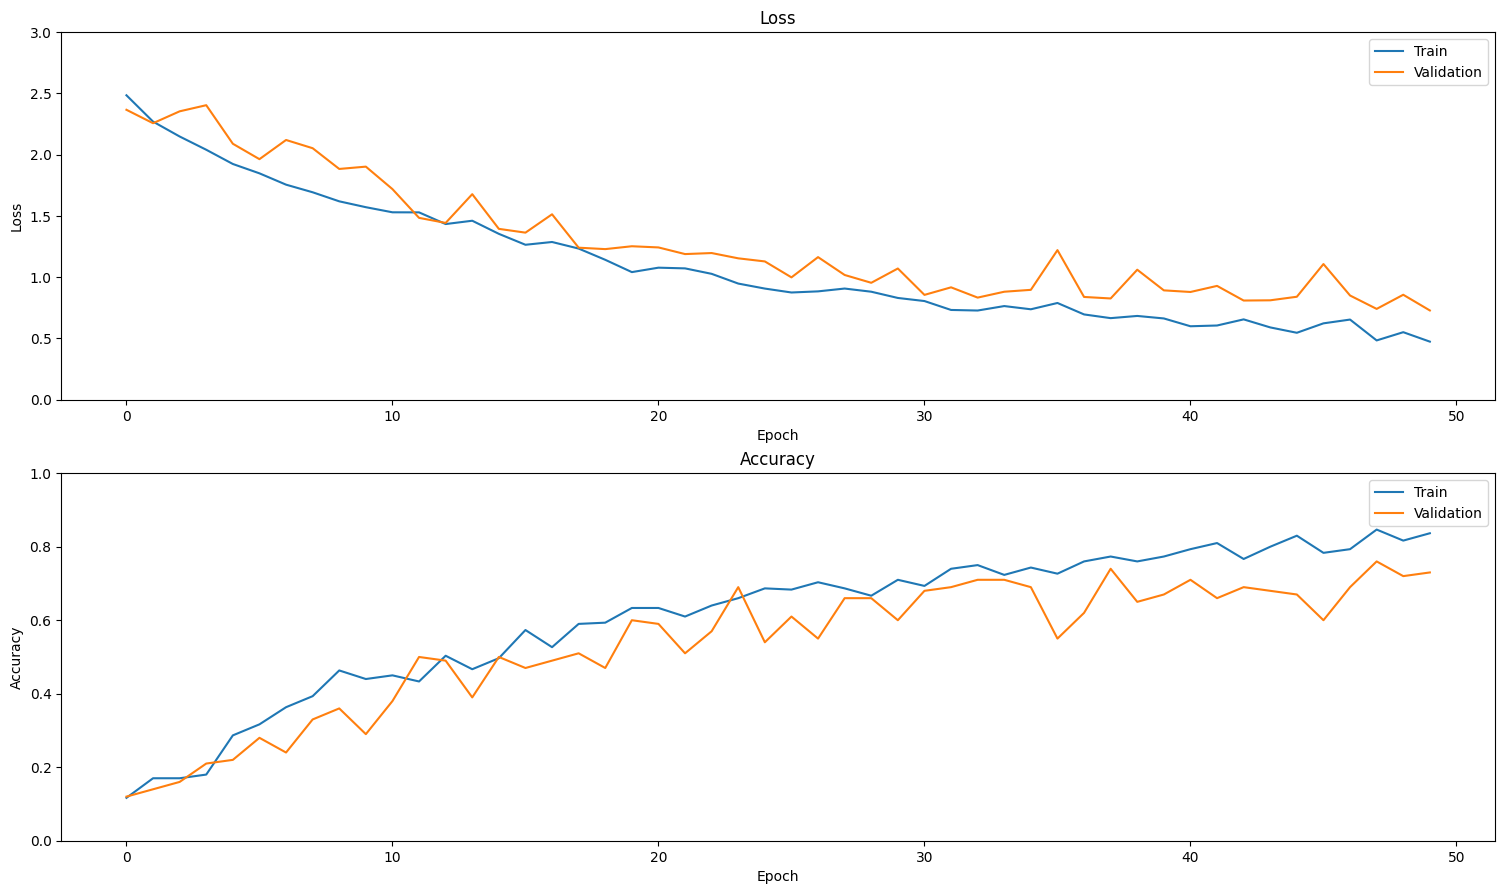

In [18]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## 评估模型

使用 Keras `Model.evaluate` 获取测试数据集的损失和准确率。

注：本教程中的示例模型使用 UCF101 数据集的子集来保持合理的训练时间。通过进一步的超参数调优或更多的训练数据，可以改善准确率和损失。 

In [19]:
model.evaluate(test_ds, return_dict = True)

      1/Unknown - 1s 839ms/step - loss: 0.6242 - accuracy: 0.8750

      2/Unknown - 2s 955ms/step - loss: 1.2343 - accuracy: 0.6875

      3/Unknown - 3s 881ms/step - loss: 1.1846 - accuracy: 0.7083

      4/Unknown - 3s 821ms/step - loss: 0.9936 - accuracy: 0.7188

      5/Unknown - 4s 882ms/step - loss: 1.0584 - accuracy: 0.6250

      6/Unknown - 5s 876ms/step - loss: 1.1583 - accuracy: 0.5625

      7/Unknown - 6s 887ms/step - loss: 1.0799 - accuracy: 0.6250

      8/Unknown - 7s 907ms/step - loss: 1.0903 - accuracy: 0.6250

      9/Unknown - 8s 909ms/step - loss: 1.0572 - accuracy: 0.6528

     10/Unknown - 9s 885ms/step - loss: 1.0455 - accuracy: 0.6625

     11/Unknown - 10s 902ms/step - loss: 1.0156 - accuracy: 0.6591

     12/Unknown - 11s 921ms/step - loss: 0.9863 - accuracy: 0.6771

     13/Unknown - 11s 884ms/step - loss: 0.9717 - accuracy: 0.6800

13/13 [==============================] - 11s 885ms/step - loss: 0.9717 - accuracy: 0.6800


{'loss': 0.9717392921447754, 'accuracy': 0.6800000071525574}

要进一步呈现模型性能，请使用[混淆矩阵](https://tensorflow.google.cn/api_docs/python/tf/math/confusion_matrix)。混淆矩阵允许评估分类模型的性能，而不仅仅是准确率。为了构建此多类分类问题的混淆矩阵，需要获得测试集中的实际值和预测值。 

In [20]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [21]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [22]:
labels = ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam',
          'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress']

      1/Unknown - 2s 2s/step

      2/Unknown - 3s 942ms/step

      3/Unknown - 4s 925ms/step

      4/Unknown - 5s 907ms/step

      5/Unknown - 5s 904ms/step

      6/Unknown - 6s 908ms/step

      7/Unknown - 7s 922ms/step

      8/Unknown - 8s 942ms/step

      9/Unknown - 9s 932ms/step

     10/Unknown - 10s 923ms/step

     11/Unknown - 11s 921ms/step

     12/Unknown - 12s 923ms/step

     13/Unknown - 13s 923ms/step

     14/Unknown - 14s 930ms/step

     15/Unknown - 15s 921ms/step

     16/Unknown - 16s 932ms/step

     17/Unknown - 17s 925ms/step

     18/Unknown - 18s 925ms/step

     19/Unknown - 18s 925ms/step

     20/Unknown - 19s 922ms/step

     21/Unknown - 20s 921ms/step

     22/Unknown - 21s 923ms/step

     23/Unknown - 22s 920ms/step

     24/Unknown - 23s 921ms/step

     25/Unknown - 24s 921ms/step

     26/Unknown - 25s 922ms/step

     27/Unknown - 26s 923ms/step

     28/Unknown - 27s 920ms/step

     29/Unknown - 28s 918ms/step

     30/Unknown - 28s 919ms/step

     31/Unknown - 29s 917ms/step

     32/Unknown - 30s 916ms/step

     33/Unknown - 31s 918ms/step

     34/Unknown - 32s 923ms/step

     35/Unknown - 33s 920ms/step

     36/Unknown - 34s 921ms/step

     37/Unknown - 35s 923ms/step

     38/Unknown - 35s 910ms/step

38/38 [==============================] - 36s 912ms/step


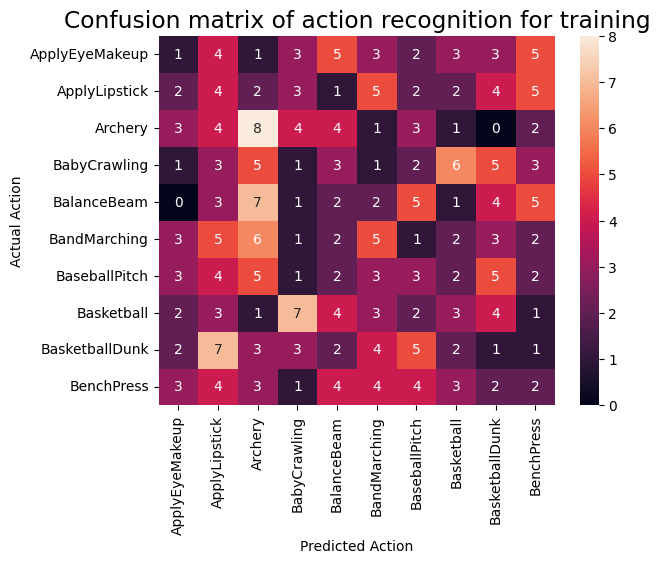

In [23]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

      1/Unknown - 1s 961ms/step

      2/Unknown - 2s 980ms/step

      3/Unknown - 3s 894ms/step

      4/Unknown - 3s 830ms/step

      5/Unknown - 5s 900ms/step

      6/Unknown - 5s 885ms/step

      7/Unknown - 6s 894ms/step

      8/Unknown - 7s 914ms/step

      9/Unknown - 8s 919ms/step

     10/Unknown - 9s 894ms/step

     11/Unknown - 10s 909ms/step

     12/Unknown - 11s 931ms/step

     13/Unknown - 12s 892ms/step

13/13 [==============================] - 12s 893ms/step


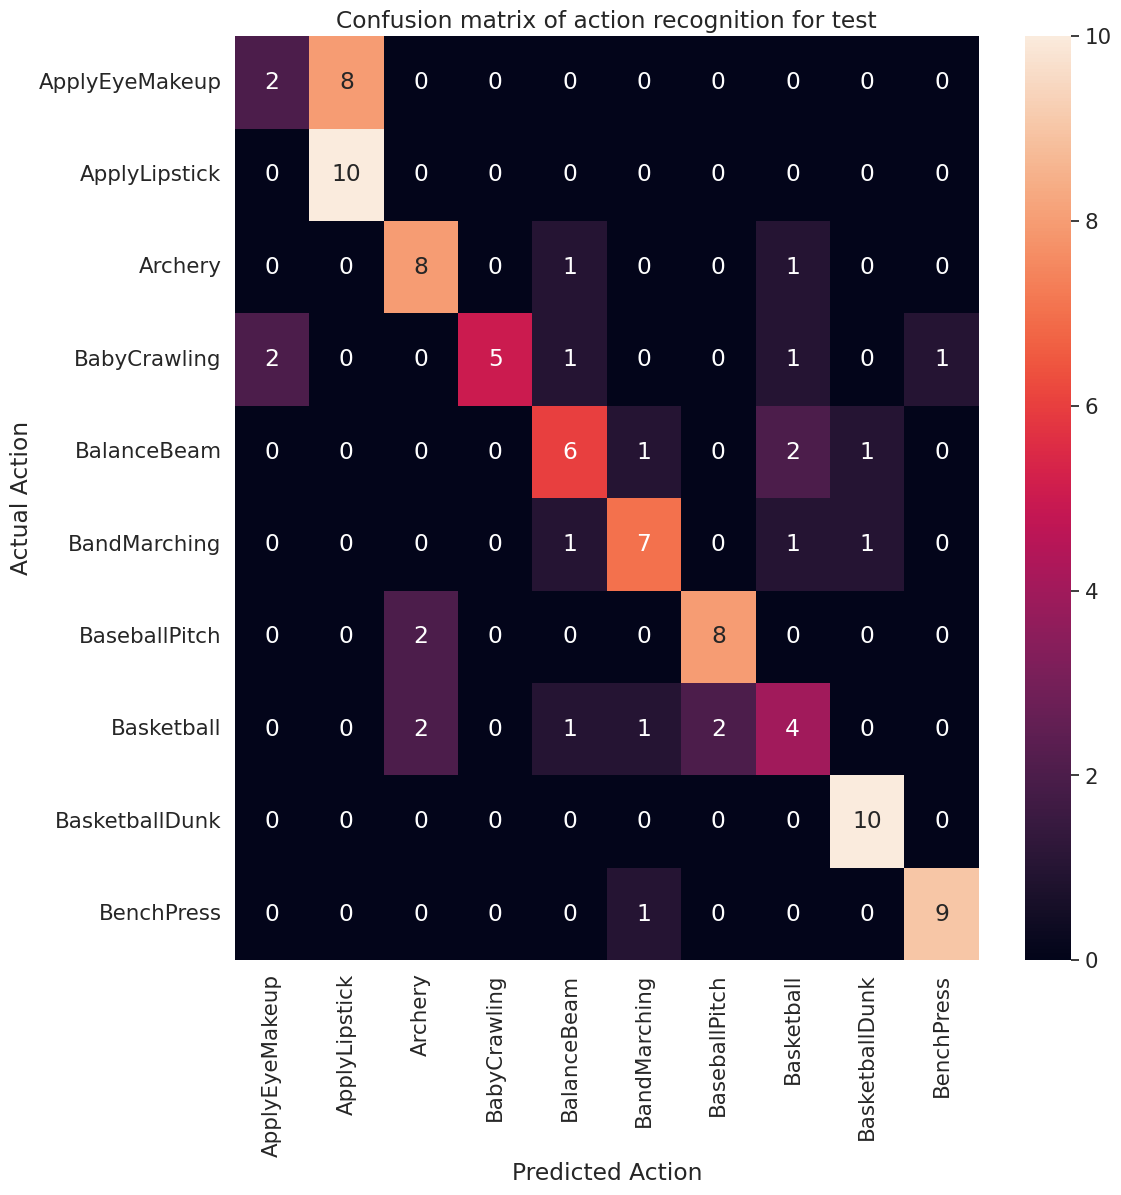

In [24]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

另外，还可以使用混淆矩阵计算每个类的准确率和召回率值。 

In [25]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [26]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [27]:
precision

{'ApplyEyeMakeup': 0.5,
 'ApplyLipstick': 0.5555555555555556,
 'Archery': 0.6666666666666666,
 'BabyCrawling': 1.0,
 'BalanceBeam': 0.6,
 'BandMarching': 0.7,
 'BaseballPitch': 0.8,
 'Basketball': 0.4444444444444444,
 'BasketballDunk': 0.8333333333333334,
 'BenchPress': 0.9}

In [28]:
recall

{'ApplyEyeMakeup': 0.2,
 'ApplyLipstick': 1.0,
 'Archery': 0.8,
 'BabyCrawling': 0.5,
 'BalanceBeam': 0.6,
 'BandMarching': 0.7,
 'BaseballPitch': 0.8,
 'Basketball': 0.4,
 'BasketballDunk': 1.0,
 'BenchPress': 0.9}